# Import library

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 139 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import math 
import numpy as np 
import pandas as pd
from datetime import date, timedelta, datetime 
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, SimpleRNN, GRU
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import seaborn as sns
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
import yfinance as yf
import datetime
import time

# Preparing input data

In [ ]:
def random_seed(seed = 1819642):
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.keras.utils.set_random_seed(seed)
random_seed()

In [ ]:
# Get data set
def get_data(symbol, start_date, end_date):
    df = yf.download(symbol, start = start_date, end = end_date)
    return df

In [ ]:
def plot_input_data(x_value, y_value, x_label, y_label, title,label):
  plt.plot(x_value, y_value,label = label)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.title(title)
  plt.show()


In [ ]:
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'
symbol = 'MSFT'
data = get_data(symbol, start_date, end_date)
data

[*********************100%***********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-01-04   30.620001   31.100000   30.590000   30.950001   23.683075   
2010-01-05   30.850000   31.100000   30.639999   30.959999   23.690716   
2010-01-06   30.879999   31.080000   30.520000   30.770000   23.545340   
2010-01-07   30.629999   30.700001   30.190001   30.450001   23.300467   
2010-01-08   30.280001   30.879999   30.240000   30.660000   23.461161   
...                ...         ...         ...         ...         ...   
2022-11-17  237.779999  243.250000  237.630005  241.679993  241.679993   
2022-11-18  243.509995  243.740005  239.029999  241.220001  241.220001   
2022-11-21  241.429993  244.669998  241.190002  242.050003  242.050003   
2022-11-22  243.589996  245.309998  240.710007  245.029999  245.029999   
2022-11-23  245.110001  248.279999  244.270004  247.580002  247.580002   

              Volume  
Date                  
2010-01-04  38409100  
2010-01-05  49749600  
2010-01-06  58182400  
2010-01-07  50559700  
2010-01-08  51197400  
...              ...  
2022-11-17  23123500  
2022-11-18  27591800  
2022-11-21  26394700  
2022-11-22  19665700  
2022-11-23  19489500  

[3247 rows x 6 columns]

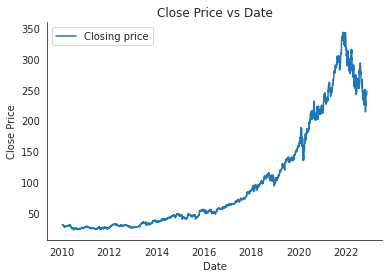

In [ ]:
x_value = data.index
y_value = data['Close'].values
plot_input_data(x_value, y_value, 'Date', 'Close Price', 'Close Price vs Date',"Closing price")

In [ ]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data, index_Close):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, index_Close]) 
        
    x = np.array(x)
    y = np.array(y)
    return x, y

#Baseline Models

##Simple Moving Average

### Experiment


In [ ]:
# Simple Moving Average
random_seed()
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'
symbol = "MSFT"
input_data_df = get_data(symbol, start_date, end_date)
true_value = input_data_df.tail(1)['Close'].values[0]
def get_sma(rolling):
    return input_data_df.rolling(rolling).mean().tail(1)['Close'].values[0]

results_sma = []
rolling_windows = [4,100,120]
for rolling in rolling_windows:
    predicted = get_sma(rolling)
    error = abs(predicted - true_value)
    results_sma.append({
        'rolling': rolling,
        'true_value': true_value,
        'predicted_value': predicted,
        'error': error})

[*********************100%***********************]  1 of 1 completed


### Result

In [ ]:
results_sma
results_sma_df = pd.DataFrame(results_sma)
results_sma_df.sort_values(by=['error'])

rolling  true_value  predicted_value     error
0        4  247.580002       243.970001  3.610001
1      100  247.580002       253.526099  5.946098
2      120  247.580002       254.229166  6.649165

In [ ]:
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'
symbol = "MSFT"
input_data_df = get_data(symbol, start_date, end_date)
rolling_windows = [4,100,120]
results_mse = []
for rolling_window in rolling_windows:
  predicted_sma = input_data_df.rolling(rolling_window).mean()[rolling_window:]
  true_sma = input_data_df[rolling_window:]
  mse = mean_squared_error(true_sma['Close'].values, predicted_sma['Close'].values)
  results_mse.append({
      'rolling_window': rolling_window,
      'mse': mse
  })

[*********************100%***********************]  1 of 1 completed


In [ ]:
result_df_mes = pd.DataFrame(results_mse)
result_df_mes.sort_values(by=["mse"])

rolling_window         mse
0               4    4.511548
1             100  123.905908
2             120  157.519630

# Get RNN Models

In [ ]:
def get_rnn_model(model_name, n_neurons, return_sequences, input_shape):
  if model_name == "LSTM":
    if input_shape == None:
      return LSTM(n_neurons, return_sequences=return_sequences)
    else:
      return LSTM(n_neurons, return_sequences=return_sequences, input_shape=input_shape)
  elif model_name == "SimpleRNN":
    if input_shape == None:
      return SimpleRNN(n_neurons, return_sequences=return_sequences)
    else:
      return SimpleRNN(n_neurons, return_sequences=return_sequences, input_shape=input_shape)
  elif model_name == "GRU":
    if input_shape == None:
      return GRU(n_neurons, return_sequences=return_sequences)
    else:
      return GRU(n_neurons, return_sequences=return_sequences, input_shape=input_shape)

# Train Models

In [ ]:
# Plot line charts
def plot_input_data(input_data_df):
    df_plot = input_data_df.copy()

    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
            sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
            ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()

In [ ]:
# Plot training & validation loss values
def plot_curve(history, epochs):
    training_loss = history.history["loss"]
    validation_loss = history.history["val_loss"]
    epochs_list = range(epochs)
    plt.plot(epochs_list, training_loss, label='Training')
    plt.plot(epochs_list, validation_loss, label='Validation')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss curve')
    plt.show()

In [ ]:
def plot_result(data_filtered_ext, train_data_len, y_pred):    
    # The date from which on the date is displayed
    display_start_date = "2010-01-01" 

    # Add the difference between the valid and predicted prices
    train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
    valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
    valid.insert(1, "y_pred", y_pred, True)
    valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
    df_union = pd.concat([train, valid])

    # Zoom in to a closer timeframe
    df_union_zoom = df_union[df_union.index > display_start_date]

    # Create the lineplot
    fig, ax1 = plt.subplots(figsize=(16, 8))
    plt.title("y_pred vs y_test")
    plt.ylabel(stockname, fontsize=18)
    sns.set_palette(["#090364", "#1960EF", "#EF5919"])
    sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

    # Create the bar plot with the differences
    df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
    ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
    plt.legend()
    plt.show() 

In [ ]:
def train_networks(input_data_df, features, model_name, epochs, batch_size, 
                   optimizer, loss_func, sequence_length, number_of_layers):
    train_df = input_data_df.sort_values(by=['Date']).copy()
    start_time = datetime.datetime.now()

    # Create the dataset with features and filter the data to the list of FEATURES
    data = pd.DataFrame(train_df)
    data_filtered = data[features]

    # We add a prediction column and set dummy values to prepare the data for scaling
    data_filtered_ext = data_filtered.copy()
    data_filtered_ext['Prediction'] = data_filtered_ext['Close']

    # Get the number of rows in the data
    nrows = data_filtered.shape[0]
    
    # Convert the data to numpy values
    np_data_unscaled = np.array(data_filtered)
    np_data = np.reshape(np_data_unscaled, (nrows, -1))

    # Transform the data by scaling each feature to a range between 0 and 1
    scaler = MinMaxScaler()
    np_data_scaled = scaler.fit_transform(np_data_unscaled)
    # Creating a separate scaler that works on a single column for scaling predictions
    scaler_pred = MinMaxScaler()
    df_Close = pd.DataFrame(data_filtered_ext['Close'])
    np_Close_scaled = scaler_pred.fit_transform(df_Close)

    # Prediction Index
    index_Close = data.columns.get_loc("Close")

    # Split the training data into train and train data sets
    # As a first step, we get the number of rows to train the model on 80% of the data 
    train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

    # Create the training and test data
    train_data = np_data_scaled[0:train_data_len, :]
    test_data = np_data_scaled[train_data_len - sequence_length:, :]

    # Generate training data and test data
    x_train, y_train = partition_dataset(sequence_length, train_data, index_Close)
    x_test, y_test = partition_dataset(sequence_length, test_data, index_Close)

    # Configure the neural network model
    model = Sequential()

    # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
    n_neurons = x_train.shape[1] * x_train.shape[2]
    input_shape=(x_train.shape[1], x_train.shape[2])
    model.add(get_rnn_model(model_name, n_neurons, True, input_shape))
    for i in range(number_of_layers):
        model.add(get_rnn_model(model_name, n_neurons, True, None))

    model.add(get_rnn_model(model_name, n_neurons, False, None))

    model.add(Dense(7))
    model.add(Dense(1))

    model.compile(optimizer = optimizer, loss= loss_func)

    # model.summary()

    history = model.fit(x_train, y_train, 
                        batch_size=batch_size, 
                        epochs=epochs,
                        validation_data=(x_test, y_test)
                      )
                    
    plot_curve(history, epochs)

    # Get the predicted values
    y_pred_scaled = model.predict(x_test)

    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled)
    y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test_unscaled, y_pred)

    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100

    # Median Absolute Percentage Error (MDAPE)
    mdape = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
    mse = mean_squared_error(y_test_unscaled, y_pred)
    df_temp = input_data_df[-sequence_length:]
    new_df = df_temp.filter(features)
    N = sequence_length

    # Get the last N day closing price values and scale the data to be values between 0 and 1
    last_N_days = new_df[-sequence_length:].values
    last_N_days_scaled = scaler.transform(last_N_days)

    # Create an empty list and Append past N days
    X_test_new = []
    X_test_new.append(last_N_days_scaled)

    # Convert the X_test data set to a numpy array and reshape the data
    pred_price_scaled = model.predict(np.array(X_test_new))
    pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

    # Print last price and predicted price for the next day
    price_today = np.round(new_df['Close'][-1], 2)
    predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
    test_prediction_difference = abs(predicted_price - price_today)

    plot_result(data_filtered_ext, train_data_len, y_pred)
    end_time =  datetime.datetime.now()
    difference = end_time - start_time
    difference_total_seconds = difference.total_seconds()
    return {
        'epochs': epochs,
        'batch_size': batch_size,
        'sequence_length': sequence_length,
        'mae': mae,
        'mape': mape,
        'mdape': mdape,
        'mse': mse,
        'test_prediction_difference': test_prediction_difference,
        'training_time': difference_total_seconds,
        'number_of_layers': number_of_layers 
    }

[*********************100%***********************]  1 of 1 completed
number_of_layers 0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 10)             640       
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 dense (Dense)               (None, 7)                 77        
                                                                 
 dense_1 (Dense)             (None, 1)                 8         
                                                                 
Total params: 1,565
Trainable params: 1,565
Non-trainable params: 0
_________________________________________________________________
163/163 [==============================] - 9s 10ms/step - loss: 0.0077 - val_loss: 5.5709e-04


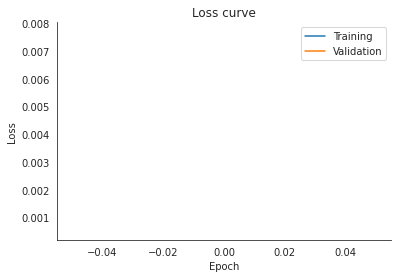

1/1 [==============================] - 0s 18ms/step


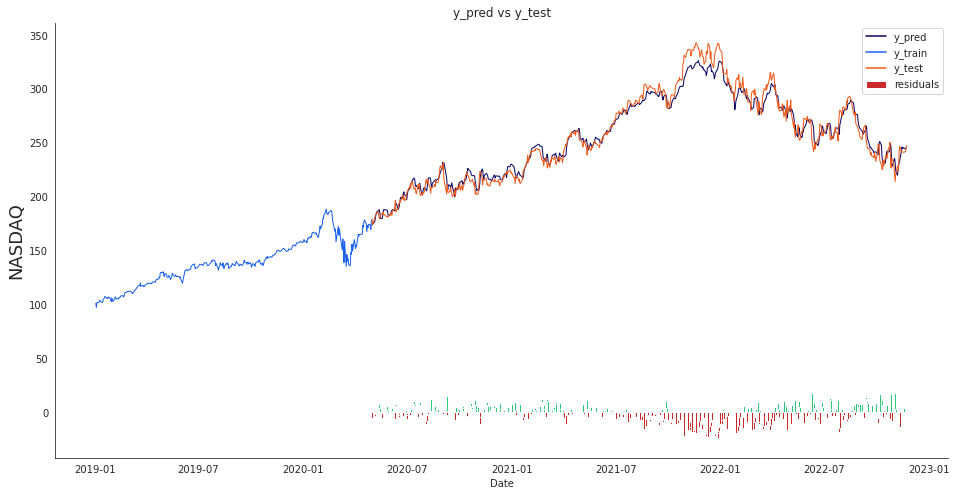

number_of_layers 0
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 2, 10)             160       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 7)                 77        
                                                                 
 dense_3 (Dense)             (None, 1)                 8         
                                                                 
Total params: 455
Trainable params: 455
Non-trainable params: 0
_________________________________________________________________
163/163 [==============================] - 3s 9ms/step - loss: 0.1422 - val_loss: 0.0186


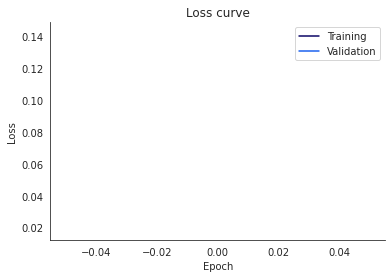

1/1 [==============================] - 0s 16ms/step


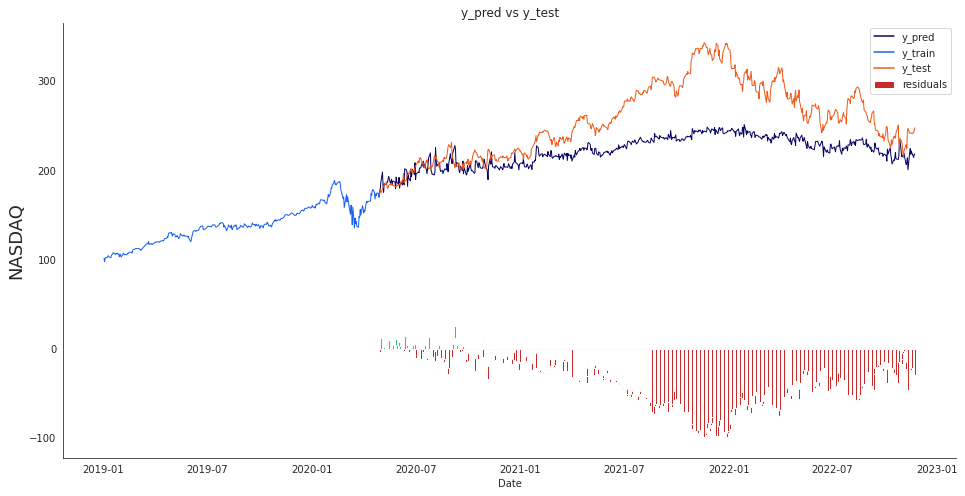

number_of_layers 0
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 2, 10)             510       
                                                                 
 gru_1 (GRU)                 (None, 10)                660       
                                                                 
 dense_4 (Dense)             (None, 7)                 77        
                                                                 
 dense_5 (Dense)             (None, 1)                 8         
                                                                 
Total params: 1,255
Trainable params: 1,255
Non-trainable params: 0
_________________________________________________________________
163/163 [==============================] - 4s 9ms/step - loss: 2.7024e-04 - val_loss: 0.0082


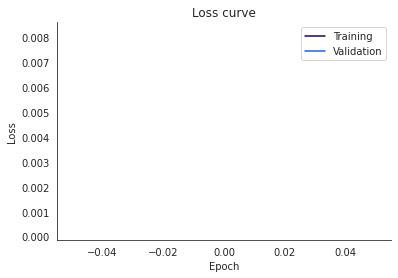

1/1 [==============================] - 0s 16ms/step


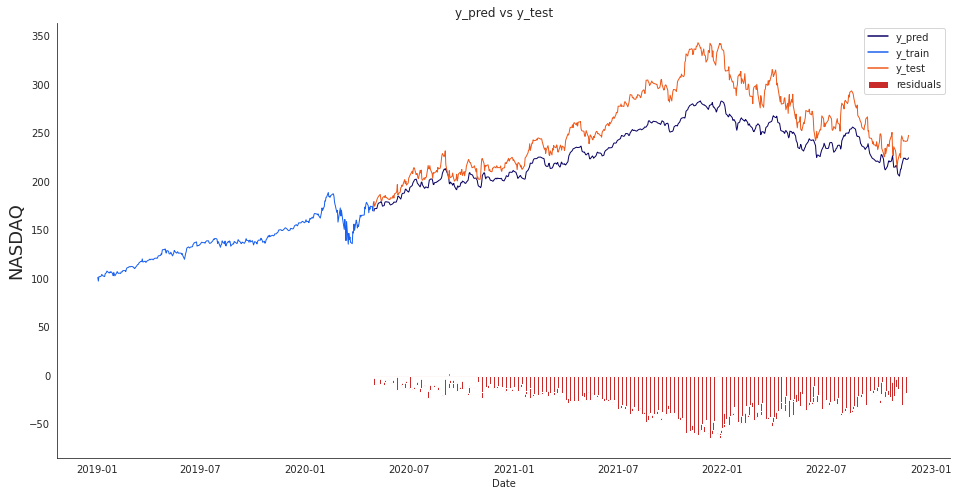

number_of_layers 1
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 2, 10)             640       
                                                                 
 lstm_3 (LSTM)               (None, 2, 10)             840       
                                                                 
 lstm_4 (LSTM)               (None, 10)                840       
                                                                 
 dense_6 (Dense)             (None, 7)                 77        
                                                                 
 dense_7 (Dense)             (None, 1)                 8         
                                                                 
Total params: 2,405
Trainable params: 2,405
Non-trainable params: 0
_________________________________________________________________
163/163 [========================

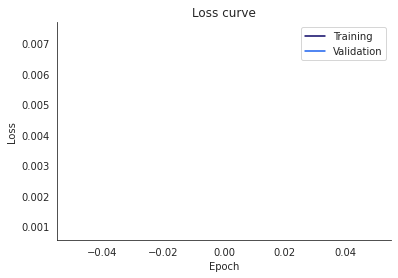

1/1 [==============================] - 0s 17ms/step


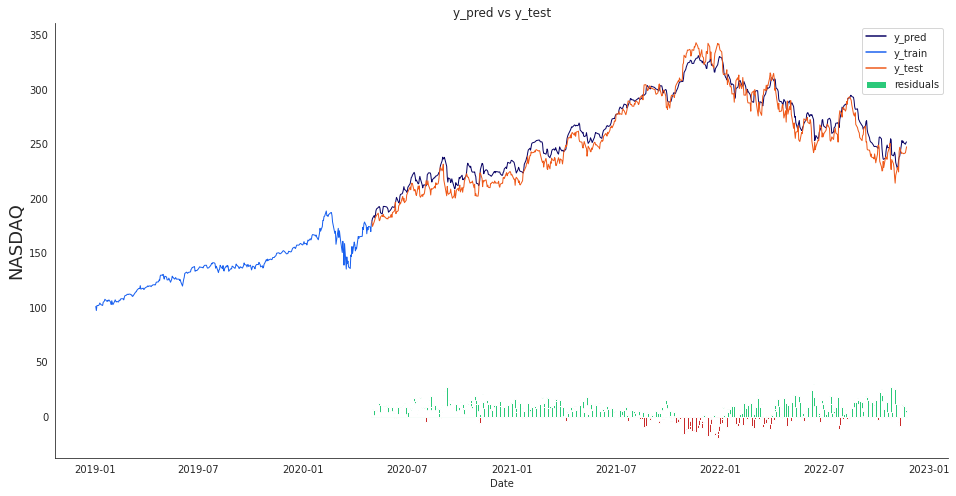

number_of_layers 1
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 2, 10)             160       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 2, 10)             210       
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 7)                 77        
                                                                 
 dense_9 (Dense)             (None, 1)                 8         
                                                                 
Total params: 665
Trainable params: 665
Non-trainable params: 0
_________________________________________________________________
163/163 [============================

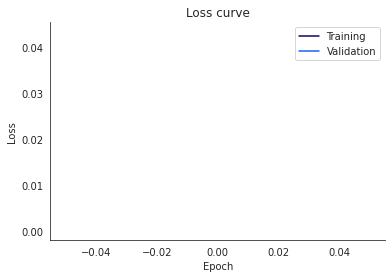

1/1 [==============================] - 0s 17ms/step


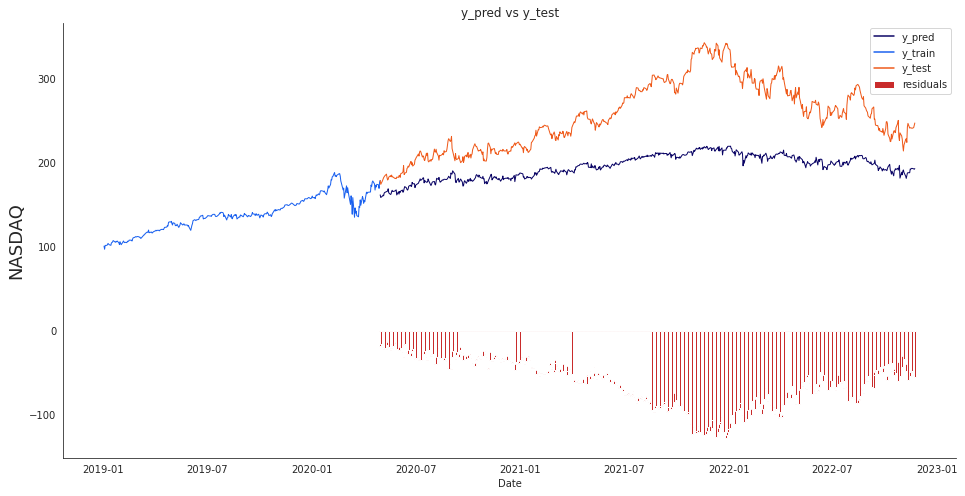

number_of_layers 1
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 2, 10)             510       
                                                                 
 gru_3 (GRU)                 (None, 2, 10)             660       
                                                                 
 gru_4 (GRU)                 (None, 10)                660       
                                                                 
 dense_10 (Dense)            (None, 7)                 77        
                                                                 
 dense_11 (Dense)            (None, 1)                 8         
                                                                 
Total params: 1,915
Trainable params: 1,915
Non-trainable params: 0
_________________________________________________________________
163/163 [========================

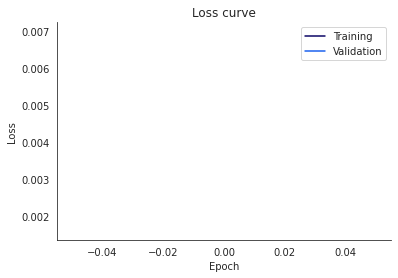

1/1 [==============================] - 0s 16ms/step


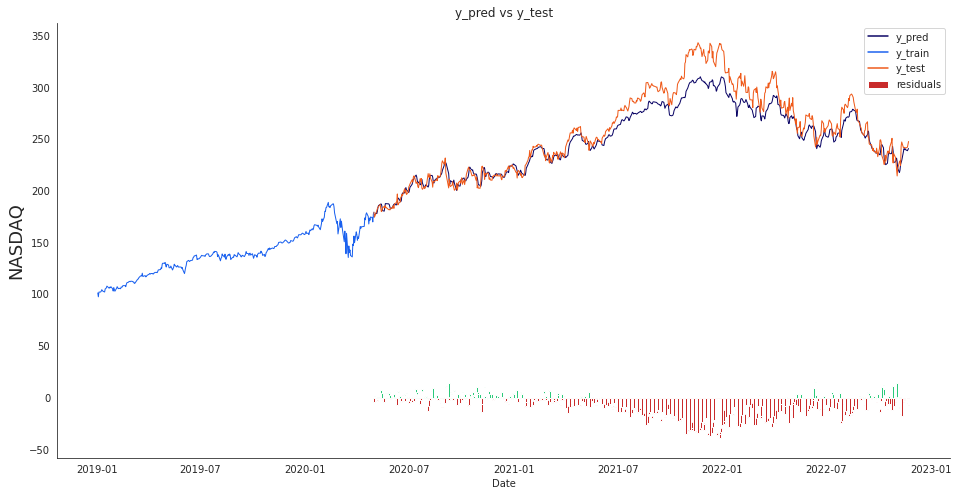

[{'epochs': 1, 'batch_size': 16, 'sequence_length': 2, 'mae': 5.80462148046273, 'mape': 2.2232300193441086, 'mdape': 1.8224588627329688, 'mse': 57.08122956440229, 'test_prediction_difference': 1.250001831054675, 'training_time': 14.935655, 'number_of_layers': 0, 'model_names': 'LSTM'}, {'epochs': 1, 'batch_size': 16, 'sequence_length': 2, 'mae': 35.42236746624914, 'mape': 12.660224597521621, 'mdape': 12.367690278963426, 'mse': 1903.6925282233412, 'test_prediction_difference': 31.880003051757825, 'training_time': 5.078899, 'number_of_layers': 0, 'model_names': 'SimpleRNN'}, {'epochs': 1, 'batch_size': 16, 'sequence_length': 2, 'mae': 25.126263070363642, 'mape': 9.20379470621346, 'mdape': 8.93557615133894, 'mse': 841.2985055381919, 'test_prediction_difference': 21.710004882812513, 'training_time': 8.597987, 'number_of_layers': 0, 'model_names': 'GRU'}, {'epochs': 1, 'batch_size': 16, 'sequence_length': 2, 'mae': 7.906951927808118, 'mape': 3.24137907439772, 'mdape': 2.924766740968569, 'ms

In [ ]:
# Get model architecture summary
random_seed()

end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'
stockname = 'NASDAQ'
symbol = 'MSFT'
model_names = ['LSTM', 'SimpleRNN', 'GRU']
epochs = 1
batch_size = 16
learning_rate = 0.001
number_of_layers = [0,1]

loss_func = tf.keras.losses.MeanSquaredError()
sequence_length = 2
features = ['High', 'Low', 'Open', 'Close', 'Volume']

# Train Model Architecture
input_data_df = get_data(symbol, start_date, end_date)
results_model_layer = []
for layer in number_of_layers:
  for model in model_names:
    print('number_of_layers', layer)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    
    result = train_networks(input_data_df, features, model, epochs, batch_size, optimizer,loss_func, sequence_length, layer)

    result['model_names'] = model
    result['number_of_layers'] = layer

    results_model_layer.append(result)
print(results_model_layer)



In [ ]:
results_model_layer
result_df_model_layer = pd.DataFrame(results_model_layer)
result_df_model_layer.sort_values(by=["model_names","mse"])

epochs  batch_size  sequence_length        mae       mape      mdape  \
5       1          16                2   9.538882   3.402037   2.766671   
2       1          16                2  25.126263   9.203795   8.935576   
0       1          16                2   5.804621   2.223230   1.822459   
3       1          16                2   7.906952   3.241379   2.924767   
1       1          16                2  35.422367  12.660225  12.367690   
4       1          16                2  60.499287  22.501542  22.502349   

           mse  test_prediction_difference  training_time  number_of_layers  \
5   166.657203                    5.199995      10.266519                 1   
2   841.298506                   21.710005       8.597987                 0   
0    57.081230                    1.250002      14.935655                 0   
3    89.741608                    6.119997      11.933264                 1   
1  1903.692528                   31.880003       5.078899                 0   
4  4439.714793                   53.900007       6.490259                 1   

  model_names  
5         GRU  
2         GRU  
0        LSTM  
3        LSTM  
1   SimpleRNN  
4   SimpleRNN

#Experiment for Model Architecture

##Experiment

[*********************100%***********************]  1 of 1 completed
number_of_layers 0
Epoch 1/20
163/163 [==============================] - 24s 10ms/step - loss: 0.0077 - val_loss: 5.5709e-04
Epoch 2/20
163/163 [==============================] - 1s 5ms/step - loss: 1.1192e-04 - val_loss: 5.6268e-04
Epoch 3/20
163/163 [==============================] - 1s 6ms/step - loss: 5.8368e-05 - val_loss: 0.0013
Epoch 4/20
163/163 [==============================] - 1s 6ms/step - loss: 3.6374e-05 - val_loss: 0.0022
Epoch 5/20
163/163 [==============================] - 1s 6ms/step - loss: 2.8898e-05 - val_loss: 0.0053
Epoch 6/20
163/163 [==============================] - 1s 5ms/step - loss: 2.6540e-05 - val_loss: 0.0072
Epoch 7/20
163/163 [==============================] - 1s 6ms/step - loss: 2.9871e-05 - val_loss: 0.0058
Epoch 8/20
163/163 [==============================] - 1s 6ms/step - loss: 2.6355e-05 - val_loss: 0.0075
Epoch 9/20
163/163 [==============================] - 1s 6ms/step - loss: 

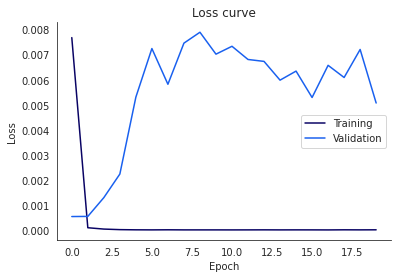

1/1 [==============================] - 0s 16ms/step


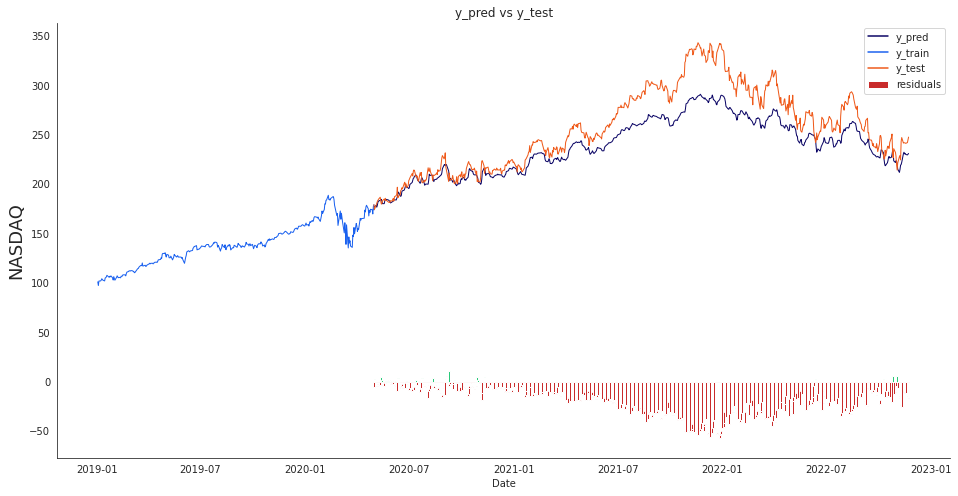

number_of_layers 0
Epoch 1/20
163/163 [==============================] - 3s 9ms/step - loss: 0.1422 - val_loss: 0.0186
Epoch 2/20
163/163 [==============================] - 2s 11ms/step - loss: 0.0028 - val_loss: 0.0309
Epoch 3/20
163/163 [==============================] - 1s 8ms/step - loss: 7.5959e-04 - val_loss: 0.0408
Epoch 4/20
163/163 [==============================] - 1s 7ms/step - loss: 2.2495e-04 - val_loss: 0.0397
Epoch 5/20
163/163 [==============================] - 1s 7ms/step - loss: 1.4227e-04 - val_loss: 0.0386
Epoch 6/20
163/163 [==============================] - 1s 8ms/step - loss: 1.2331e-04 - val_loss: 0.0369
Epoch 7/20
163/163 [==============================] - 1s 7ms/step - loss: 1.0869e-04 - val_loss: 0.0333
Epoch 8/20
163/163 [==============================] - 1s 8ms/step - loss: 9.9164e-05 - val_loss: 0.0303
Epoch 9/20
163/163 [==============================] - 1s 7ms/step - loss: 9.9558e-05 - val_loss: 0.0280
Epoch 10/20
163/163 [==============================]

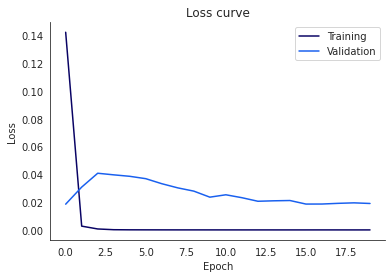

1/1 [==============================] - 0s 15ms/step


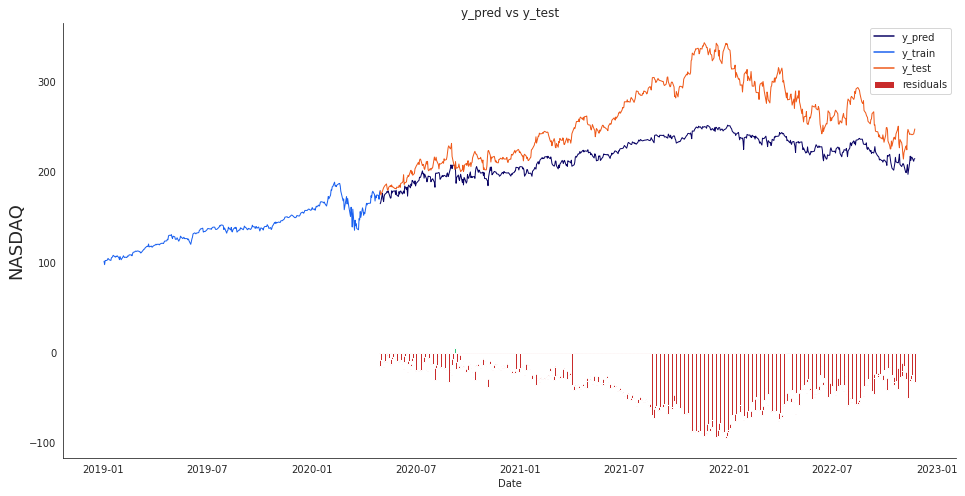

number_of_layers 0
Epoch 1/20
163/163 [==============================] - 5s 9ms/step - loss: 2.7024e-04 - val_loss: 0.0082
Epoch 2/20
163/163 [==============================] - 1s 6ms/step - loss: 2.5022e-05 - val_loss: 0.0058
Epoch 3/20
163/163 [==============================] - 1s 5ms/step - loss: 2.3547e-05 - val_loss: 0.0046
Epoch 4/20
163/163 [==============================] - 1s 6ms/step - loss: 2.5197e-05 - val_loss: 0.0026
Epoch 5/20
163/163 [==============================] - 1s 6ms/step - loss: 2.3879e-05 - val_loss: 0.0037
Epoch 6/20
163/163 [==============================] - 1s 5ms/step - loss: 2.5306e-05 - val_loss: 0.0045
Epoch 7/20
163/163 [==============================] - 1s 6ms/step - loss: 3.1802e-05 - val_loss: 0.0031
Epoch 8/20
163/163 [==============================] - 1s 6ms/step - loss: 2.5572e-05 - val_loss: 0.0026
Epoch 9/20
163/163 [==============================] - 1s 5ms/step - loss: 2.6747e-05 - val_loss: 0.0034
Epoch 10/20
163/163 [========================

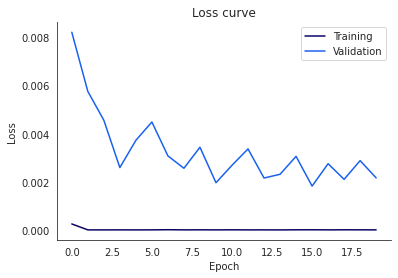

1/1 [==============================] - 0s 17ms/step


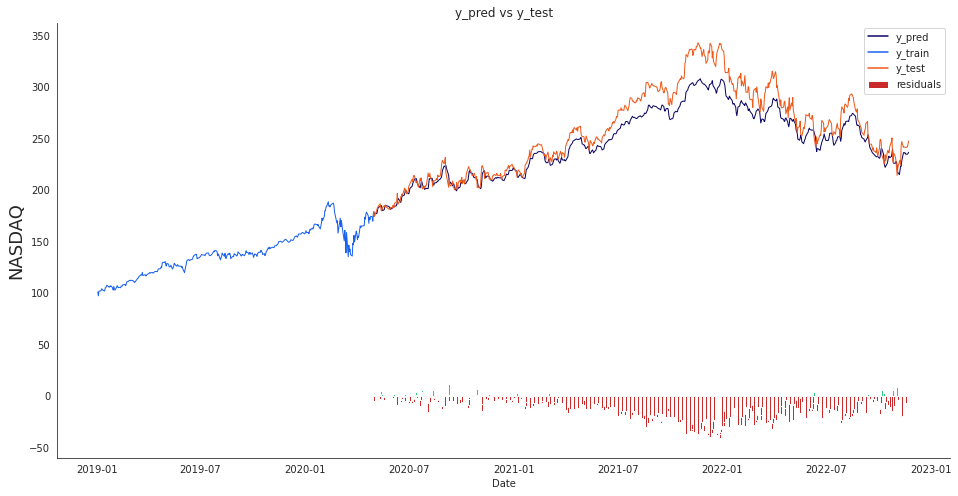

number_of_layers 1
Epoch 1/20
163/163 [==============================] - 8s 20ms/step - loss: 0.0074 - val_loss: 8.7584e-04
Epoch 2/20
163/163 [==============================] - 1s 7ms/step - loss: 5.8415e-05 - val_loss: 0.0037
Epoch 3/20
163/163 [==============================] - 1s 7ms/step - loss: 3.8081e-05 - val_loss: 0.0078
Epoch 4/20
163/163 [==============================] - 1s 7ms/step - loss: 2.8149e-05 - val_loss: 0.0071
Epoch 5/20
163/163 [==============================] - 1s 7ms/step - loss: 2.7759e-05 - val_loss: 0.0104
Epoch 6/20
163/163 [==============================] - 1s 7ms/step - loss: 2.9444e-05 - val_loss: 0.0121
Epoch 7/20
163/163 [==============================] - 1s 7ms/step - loss: 3.4441e-05 - val_loss: 0.0093
Epoch 8/20
163/163 [==============================] - 1s 7ms/step - loss: 3.0392e-05 - val_loss: 0.0094
Epoch 9/20
163/163 [==============================] - 1s 7ms/step - loss: 3.0297e-05 - val_loss: 0.0119
Epoch 10/20
163/163 [=======================

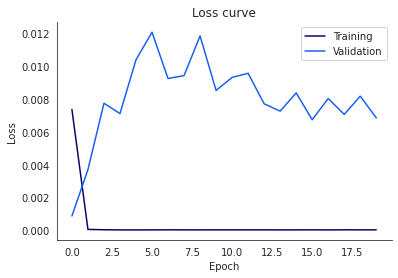

1/1 [==============================] - 0s 18ms/step


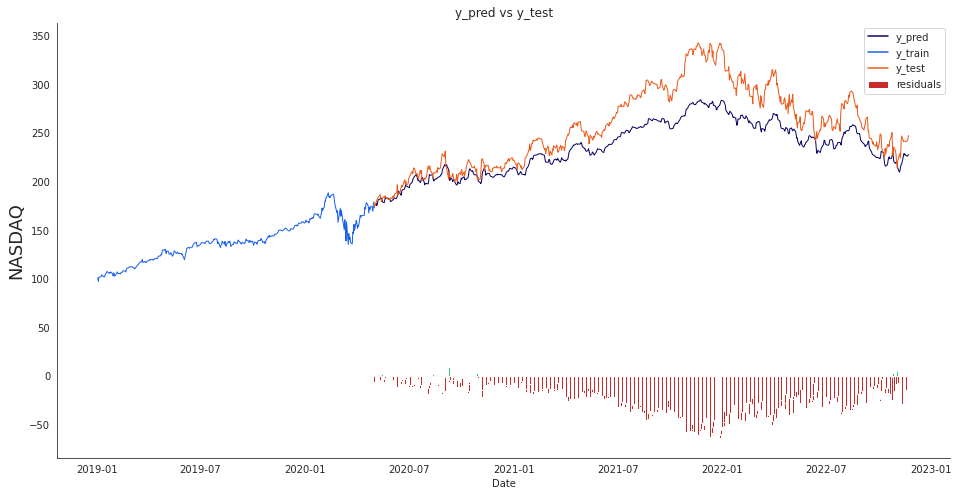

number_of_layers 1
Epoch 1/20
163/163 [==============================] - 4s 12ms/step - loss: 3.3887e-04 - val_loss: 0.0433
Epoch 2/20
163/163 [==============================] - 2s 10ms/step - loss: 9.6938e-05 - val_loss: 0.0200
Epoch 3/20
163/163 [==============================] - 2s 10ms/step - loss: 4.6569e-05 - val_loss: 0.0132
Epoch 4/20
163/163 [==============================] - 2s 10ms/step - loss: 4.4661e-05 - val_loss: 0.0083
Epoch 5/20
163/163 [==============================] - 2s 10ms/step - loss: 4.4996e-05 - val_loss: 0.0099
Epoch 6/20
163/163 [==============================] - 2s 10ms/step - loss: 4.1707e-05 - val_loss: 0.0123
Epoch 7/20
163/163 [==============================] - 2s 10ms/step - loss: 4.9054e-05 - val_loss: 0.0091
Epoch 8/20
163/163 [==============================] - 2s 10ms/step - loss: 5.0631e-05 - val_loss: 0.0101
Epoch 9/20
163/163 [==============================] - 2s 10ms/step - loss: 4.0598e-05 - val_loss: 0.0104
Epoch 10/20
163/163 [===============

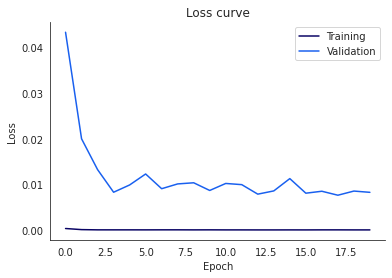

1/1 [==============================] - 0s 15ms/step


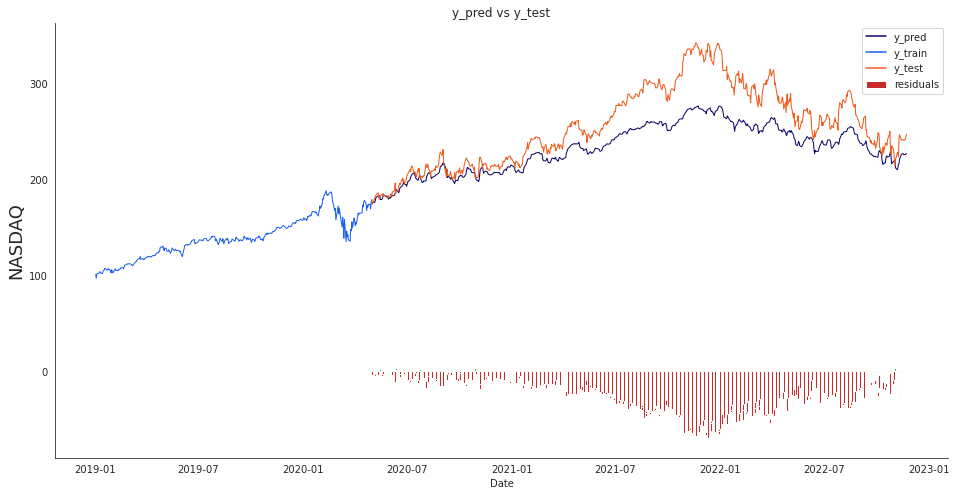

number_of_layers 1
Epoch 1/20
163/163 [==============================] - 6s 12ms/step - loss: 0.0070 - val_loss: 0.0016
Epoch 2/20
163/163 [==============================] - 1s 7ms/step - loss: 3.7885e-05 - val_loss: 0.0026
Epoch 3/20
163/163 [==============================] - 1s 7ms/step - loss: 3.0811e-05 - val_loss: 0.0034
Epoch 4/20
163/163 [==============================] - 1s 7ms/step - loss: 2.5210e-05 - val_loss: 0.0035
Epoch 5/20
163/163 [==============================] - 1s 7ms/step - loss: 2.5079e-05 - val_loss: 0.0058
Epoch 6/20
163/163 [==============================] - 1s 7ms/step - loss: 2.6835e-05 - val_loss: 0.0070
Epoch 7/20
163/163 [==============================] - 1s 7ms/step - loss: 3.0858e-05 - val_loss: 0.0060
Epoch 8/20
163/163 [==============================] - 1s 7ms/step - loss: 2.7011e-05 - val_loss: 0.0061
Epoch 9/20
163/163 [==============================] - 1s 7ms/step - loss: 2.8114e-05 - val_loss: 0.0076
Epoch 10/20
163/163 [===========================

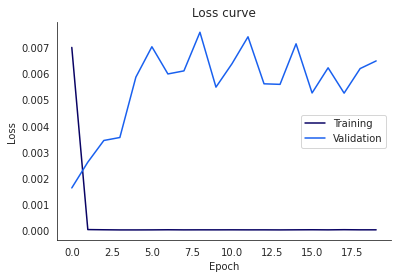

1/1 [==============================] - 0s 17ms/step


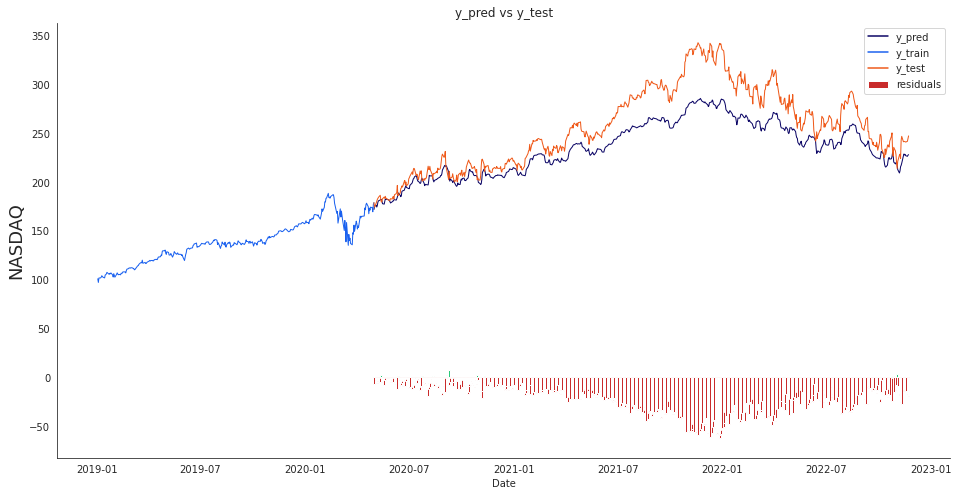

number_of_layers 2
Epoch 1/20
163/163 [==============================] - 10s 17ms/step - loss: 0.0086 - val_loss: 8.8043e-04
Epoch 2/20
163/163 [==============================] - 1s 9ms/step - loss: 8.5904e-05 - val_loss: 0.0049
Epoch 3/20
163/163 [==============================] - 1s 9ms/step - loss: 5.0899e-05 - val_loss: 0.0097
Epoch 4/20
163/163 [==============================] - 1s 9ms/step - loss: 3.4273e-05 - val_loss: 0.0099
Epoch 5/20
163/163 [==============================] - 1s 9ms/step - loss: 3.3473e-05 - val_loss: 0.0137
Epoch 6/20
163/163 [==============================] - 1s 9ms/step - loss: 3.4830e-05 - val_loss: 0.0157
Epoch 7/20
163/163 [==============================] - 1s 9ms/step - loss: 4.1883e-05 - val_loss: 0.0134
Epoch 8/20
163/163 [==============================] - 1s 9ms/step - loss: 3.5002e-05 - val_loss: 0.0127
Epoch 9/20
163/163 [==============================] - 1s 9ms/step - loss: 3.5707e-05 - val_loss: 0.0155
Epoch 10/20
163/163 [======================

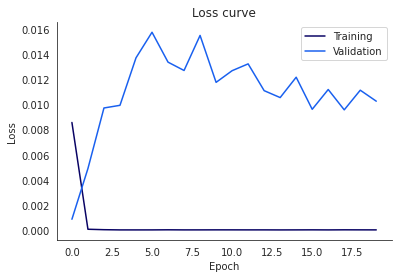

1/1 [==============================] - 0s 19ms/step


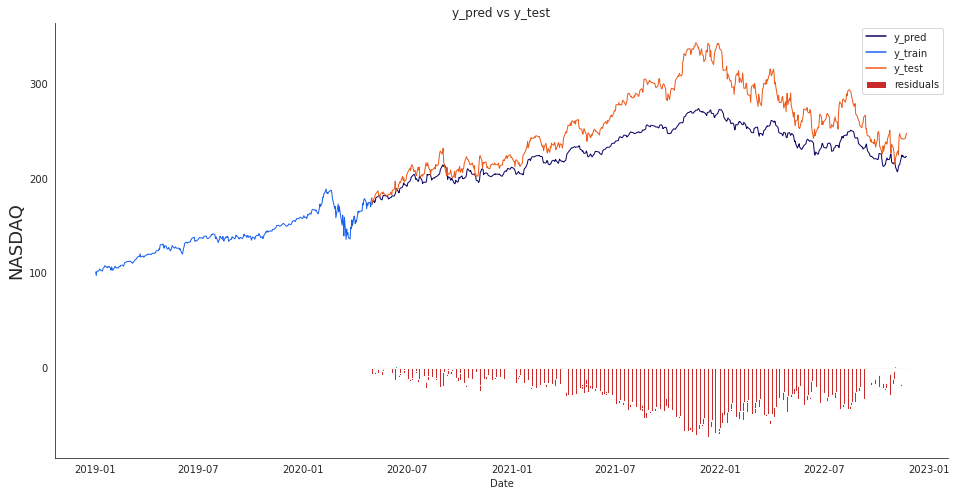

number_of_layers 2
Epoch 1/20
163/163 [==============================] - 5s 15ms/step - loss: 0.0067 - val_loss: 0.0920
Epoch 2/20
163/163 [==============================] - 2s 13ms/step - loss: 1.4369e-04 - val_loss: 0.0606
Epoch 3/20
163/163 [==============================] - 2s 13ms/step - loss: 9.4776e-05 - val_loss: 0.0499
Epoch 4/20
163/163 [==============================] - 2s 13ms/step - loss: 8.2060e-05 - val_loss: 0.0349
Epoch 5/20
163/163 [==============================] - 2s 13ms/step - loss: 7.1316e-05 - val_loss: 0.0337
Epoch 6/20
163/163 [==============================] - 2s 13ms/step - loss: 6.8813e-05 - val_loss: 0.0298
Epoch 7/20
163/163 [==============================] - 2s 13ms/step - loss: 5.7822e-05 - val_loss: 0.0300
Epoch 8/20
163/163 [==============================] - 2s 13ms/step - loss: 5.5673e-05 - val_loss: 0.0234
Epoch 9/20
163/163 [==============================] - 2s 13ms/step - loss: 5.3748e-05 - val_loss: 0.0264
Epoch 10/20
163/163 [===================

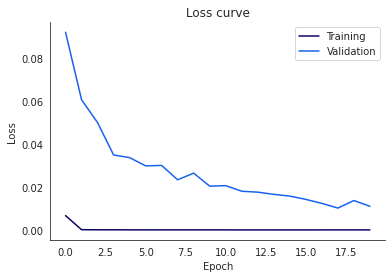

1/1 [==============================] - 0s 17ms/step


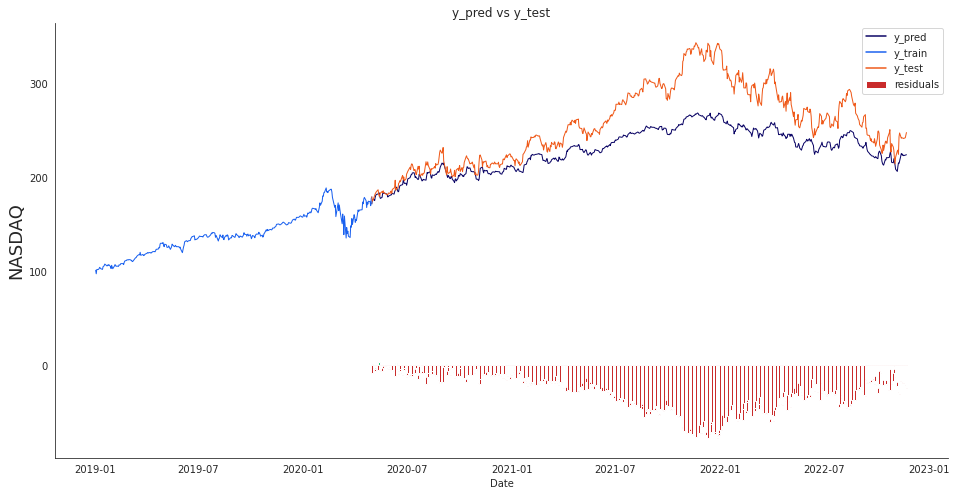

number_of_layers 2
Epoch 1/20
163/163 [==============================] - 9s 17ms/step - loss: 0.0054 - val_loss: 0.0111
Epoch 2/20
163/163 [==============================] - 2s 12ms/step - loss: 2.6873e-05 - val_loss: 0.0114
Epoch 3/20
163/163 [==============================] - 2s 12ms/step - loss: 2.9000e-05 - val_loss: 0.0115
Epoch 4/20
163/163 [==============================] - 1s 9ms/step - loss: 2.9280e-05 - val_loss: 0.0098
Epoch 5/20
163/163 [==============================] - 1s 8ms/step - loss: 2.8904e-05 - val_loss: 0.0119
Epoch 6/20
163/163 [==============================] - 1s 8ms/step - loss: 3.2643e-05 - val_loss: 0.0136
Epoch 7/20
163/163 [==============================] - 1s 9ms/step - loss: 3.7237e-05 - val_loss: 0.0119
Epoch 8/20
163/163 [==============================] - 1s 8ms/step - loss: 3.2228e-05 - val_loss: 0.0104
Epoch 9/20
163/163 [==============================] - 1s 8ms/step - loss: 3.4094e-05 - val_loss: 0.0130
Epoch 10/20
163/163 [=========================

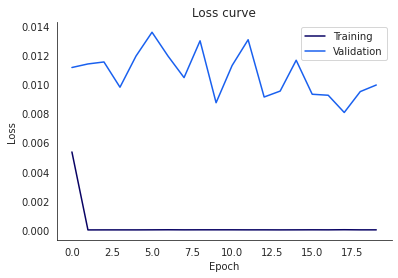

1/1 [==============================] - 0s 18ms/step


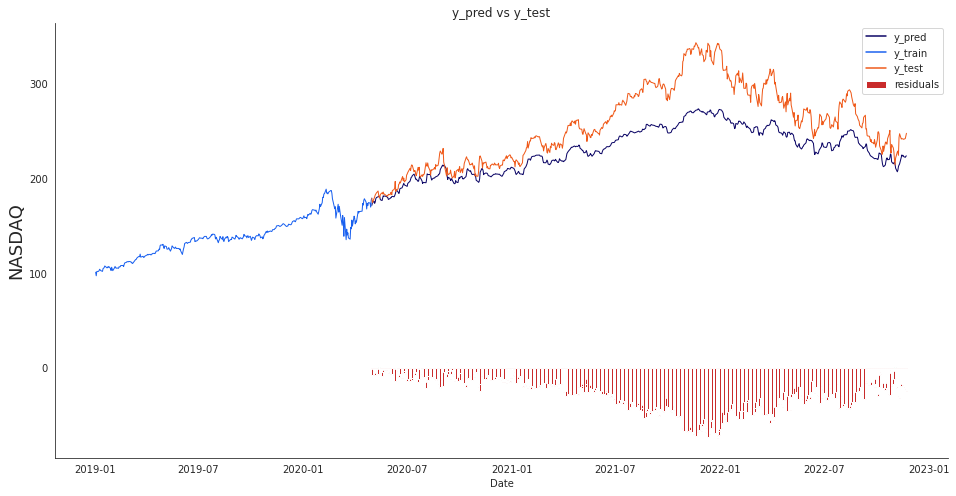

[{'epochs': 20, 'batch_size': 16, 'sequence_length': 2, 'mae': 18.326827509193812, 'mape': 6.550539895192843, 'mdape': 6.077880920774372, 'mse': 519.9367577710486, 'test_prediction_difference': 15.35000427246095, 'training_time': 46.33417, 'number_of_layers': 0, 'model_names': 'LSTM'}, {'epochs': 20, 'batch_size': 16, 'sequence_length': 2, 'mae': 38.066838786120755, 'mape': 13.886999586079025, 'mdape': 13.669362173603878, 'mse': 1955.0317528287571, 'test_prediction_difference': 31.960004882812513, 'training_time': 29.238325, 'number_of_layers': 0, 'model_names': 'SimpleRNN'}, {'epochs': 20, 'batch_size': 16, 'sequence_length': 2, 'mae': 11.720371052370218, 'mape': 4.197813668203483, 'mdape': 3.804706020089003, 'mse': 223.09970161273748, 'test_prediction_difference': 9.270002441406263, 'training_time': 28.755312, 'number_of_layers': 0, 'model_names': 'GRU'}, {'epochs': 20, 'batch_size': 16, 'sequence_length': 2, 'mae': 21.741181877618192, 'mape': 7.813133694104662, 'mdape': 7.5009500293

In [ ]:
#Experiment for Model Architecture
random_seed()
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'
stockname = 'NASDAQ'
symbol = 'MSFT'
model_names = ['LSTM', 'SimpleRNN', 'GRU']
epochs = 20
batch_size = 16
learning_rate = 0.001
number_of_layers = [0,1,2]

loss_func = tf.keras.losses.MeanSquaredError()
sequence_length = 2
features = ['High', 'Low', 'Open', 'Close', 'Volume']

# Train Model Architecture
input_data_df = get_data(symbol, start_date, end_date)
results_model_layer = []
for layer in number_of_layers:
  for model in model_names:
    print('number_of_layers', layer)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    
    result = train_networks(input_data_df, features, model, epochs, batch_size, optimizer,loss_func, sequence_length, layer)

    result['model_names'] = model
    result['number_of_layers'] = layer

    results_model_layer.append(result)
print(results_model_layer)



##Result

In [ ]:
results_model_layer
result_df_model_layer = pd.DataFrame(results_model_layer)
result_df_model_layer.sort_values(by=["model_names","mse"])
# The number of layers column will be added 2 more compared to the value in the table.

epochs  batch_size  sequence_length        mae       mape      mdape  \
2      20          16                2   9.079109   3.241656   2.770493   
5      20          16                2  16.738499   5.927750   5.290604   
8      20          16                2  21.402995   7.598663   7.014974   
0      20          16                2  16.233158   5.754046   5.125161   
3      20          16                2  18.741952   6.666792   6.190559   
6      20          16                2  23.670922   8.455764   8.070077   
4      20          16                2  19.708020   6.951637   6.063500   
7      20          16                2  24.853973   8.814659   8.106803   
1      20          16                2  31.085078  11.127438  10.879755   

           mse  test_prediction_difference  training_time  number_of_layers  \
2   147.964879                    4.740007      24.436170                 0   
5   464.489266                   11.759996      48.450773                 1   
8   731.154134                   15.800004      36.045654                 2   
0   434.681735                   11.669999      41.616786                 0   
3   560.165173                   13.979997      31.945563                 1   
6   855.875736                   18.360002      39.996686                 2   
4   648.376329                   13.350007      44.884033                 1   
7   979.855470                   18.160005      86.942785                 2   
1  1451.171362                   23.280000      27.334841                 0   

  model_names  
2         GRU  
5         GRU  
8         GRU  
0        LSTM  
3        LSTM  
6        LSTM  
4   SimpleRNN  
7   SimpleRNN  
1   SimpleRNN

# Experiment for LSTM

##Experiment for learning rates

###Experiment

[*********************100%***********************]  1 of 1 completed
learning rate 0.1
Epoch 1/20
163/163 [==============================] - 5s 10ms/step - loss: 0.0030 - val_loss: 0.0485
Epoch 2/20
163/163 [==============================] - 1s 6ms/step - loss: 1.1374e-04 - val_loss: 0.0252
Epoch 3/20
163/163 [==============================] - 1s 5ms/step - loss: 1.5255e-04 - val_loss: 0.0252
Epoch 4/20
163/163 [==============================] - 1s 5ms/step - loss: 5.0496e-04 - val_loss: 0.0053
Epoch 5/20
163/163 [==============================] - 1s 5ms/step - loss: 3.6903e-04 - val_loss: 0.0157
Epoch 6/20
163/163 [==============================] - 1s 5ms/step - loss: 5.9441e-05 - val_loss: 0.0619
Epoch 7/20
163/163 [==============================] - 1s 5ms/step - loss: 5.6831e-04 - val_loss: 0.0283
Epoch 8/20
163/163 [==============================] - 1s 5ms/step - loss: 9.3567e-05 - val_loss: 0.0301
Epoch 9/20
163/163 [==============================] - 1s 5ms/step - loss: 1.4284e-04

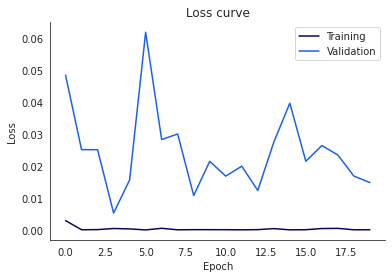

1/1 [==============================] - 0s 18ms/step


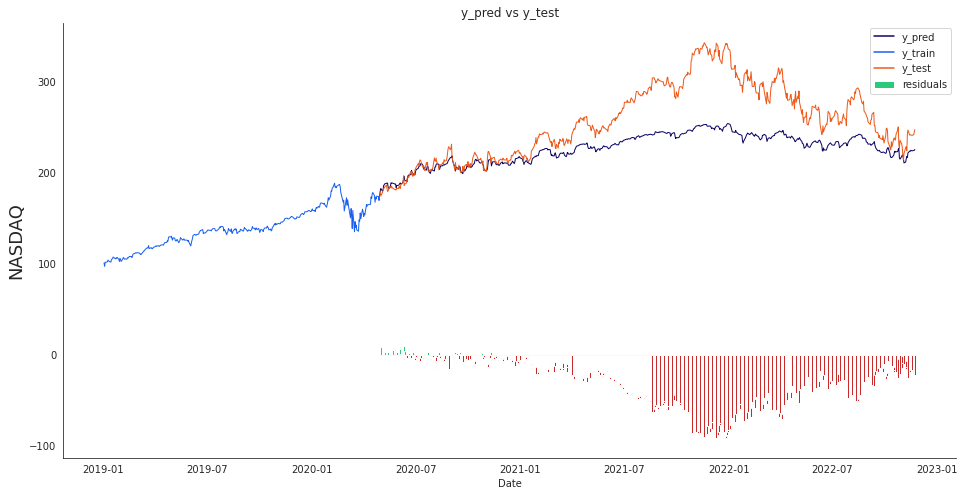

learning rate 0.001
Epoch 1/20
163/163 [==============================] - 4s 10ms/step - loss: 0.0053 - val_loss: 0.0034
Epoch 2/20
163/163 [==============================] - 1s 6ms/step - loss: 5.1572e-05 - val_loss: 0.0012
Epoch 3/20
163/163 [==============================] - 1s 5ms/step - loss: 3.8989e-05 - val_loss: 4.3802e-04
Epoch 4/20
163/163 [==============================] - 1s 5ms/step - loss: 2.8975e-05 - val_loss: 6.4768e-04
Epoch 5/20
163/163 [==============================] - 1s 6ms/step - loss: 2.5673e-05 - val_loss: 0.0021
Epoch 6/20
163/163 [==============================] - 1s 5ms/step - loss: 2.5816e-05 - val_loss: 0.0032
Epoch 7/20
163/163 [==============================] - 1s 5ms/step - loss: 2.9619e-05 - val_loss: 0.0019
Epoch 8/20
163/163 [==============================] - 1s 5ms/step - loss: 2.5772e-05 - val_loss: 0.0030
Epoch 9/20
163/163 [==============================] - 1s 5ms/step - loss: 2.5776e-05 - val_loss: 0.0035
Epoch 10/20
163/163 [==================

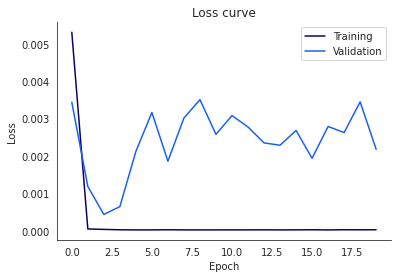

1/1 [==============================] - 0s 16ms/step


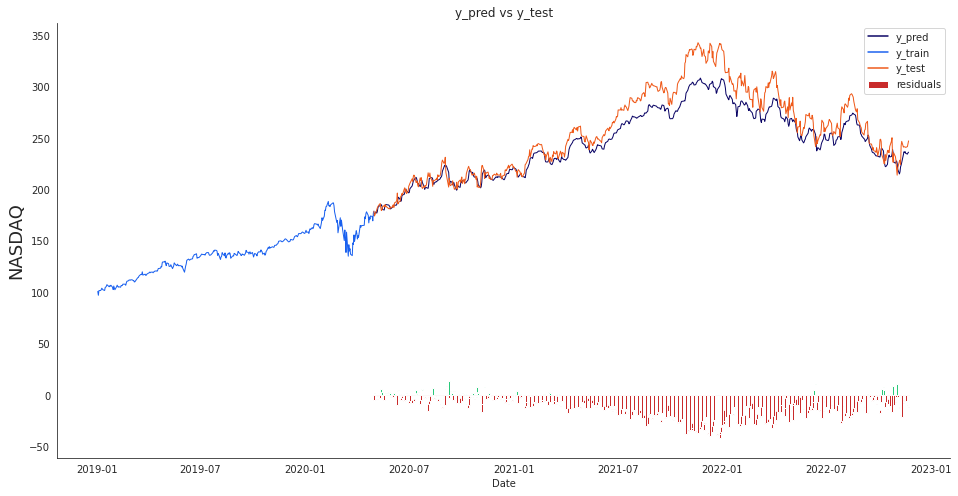

learning rate 0.0001
Epoch 1/20
163/163 [==============================] - 4s 9ms/step - loss: 0.0218 - val_loss: 0.4405
Epoch 2/20
163/163 [==============================] - 1s 5ms/step - loss: 0.0132 - val_loss: 0.3292
Epoch 3/20
163/163 [==============================] - 1s 6ms/step - loss: 0.0101 - val_loss: 0.2410
Epoch 4/20
163/163 [==============================] - 1s 6ms/step - loss: 0.0069 - val_loss: 0.1447
Epoch 5/20
163/163 [==============================] - 1s 5ms/step - loss: 0.0035 - val_loss: 0.0574
Epoch 6/20
163/163 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0139
Epoch 7/20
163/163 [==============================] - 1s 6ms/step - loss: 1.8833e-04 - val_loss: 0.0025
Epoch 8/20
163/163 [==============================] - 1s 6ms/step - loss: 4.6939e-05 - val_loss: 0.0012
Epoch 9/20
163/163 [==============================] - 1s 5ms/step - loss: 3.7296e-05 - val_loss: 0.0012
Epoch 10/20
163/163 [==============================] - 1s 6ms/step 

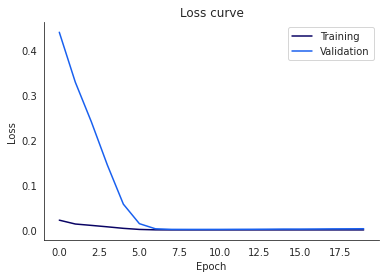

1/1 [==============================] - 0s 15ms/step


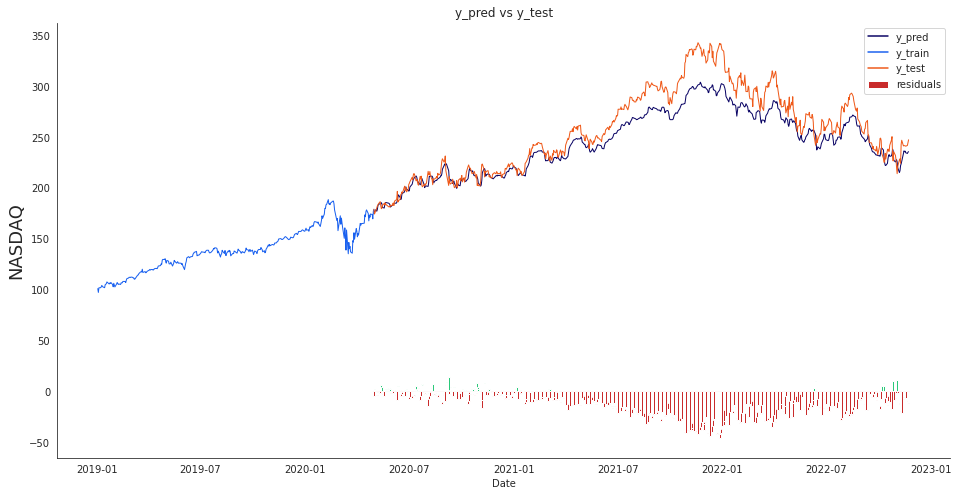

learning rate 1e-05
Epoch 1/20
163/163 [==============================] - 4s 9ms/step - loss: 0.0244 - val_loss: 0.4939
Epoch 2/20
163/163 [==============================] - 1s 5ms/step - loss: 0.0223 - val_loss: 0.4761
Epoch 3/20
163/163 [==============================] - 1s 6ms/step - loss: 0.0205 - val_loss: 0.4587
Epoch 4/20
163/163 [==============================] - 1s 6ms/step - loss: 0.0190 - val_loss: 0.4422
Epoch 5/20
163/163 [==============================] - 1s 6ms/step - loss: 0.0176 - val_loss: 0.4260
Epoch 6/20
163/163 [==============================] - 1s 5ms/step - loss: 0.0164 - val_loss: 0.4104
Epoch 7/20
163/163 [==============================] - 1s 6ms/step - loss: 0.0154 - val_loss: 0.3952
Epoch 8/20
163/163 [==============================] - 1s 6ms/step - loss: 0.0145 - val_loss: 0.3806
Epoch 9/20
163/163 [==============================] - 1s 5ms/step - loss: 0.0138 - val_loss: 0.3665
Epoch 10/20
163/163 [==============================] - 1s 6ms/step - loss: 0.013

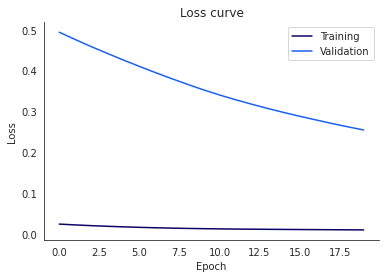

1/1 [==============================] - 0s 15ms/step


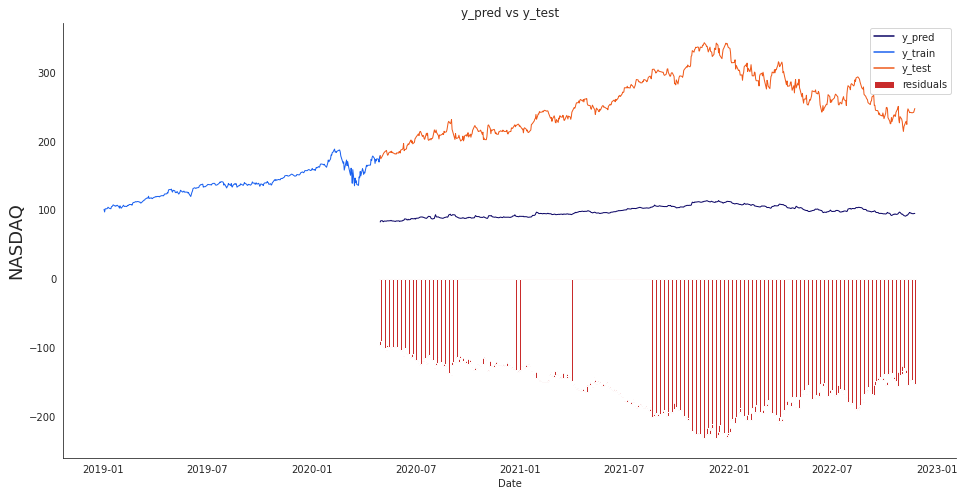

[{'epochs': 20, 'batch_size': 16, 'sequence_length': 2, 'mae': 30.196434996712174, 'mape': 10.606195365829171, 'mdape': 9.65373491389371, 'mse': 1524.3589515935473, 'test_prediction_difference': 20.210004882812513, 'training_time': 26.837549, 'number_of_layers': 0, 'learning_rate': 0.1}, {'epochs': 20, 'batch_size': 16, 'sequence_length': 2, 'mae': 11.630530758521209, 'mape': 4.165075228858071, 'mdape': 3.7514271649293116, 'mse': 223.1711045522408, 'test_prediction_difference': 9.650007324218763, 'training_time': 24.268736, 'number_of_layers': 0, 'learning_rate': 0.001}, {'epochs': 20, 'batch_size': 16, 'sequence_length': 2, 'mae': 12.818029982650575, 'mape': 4.568061097643325, 'mdape': 4.0552639339346515, 'mse': 274.2066199567734, 'test_prediction_difference': 10.669996337890638, 'training_time': 26.052419, 'number_of_layers': 0, 'learning_rate': 0.0001}, {'epochs': 20, 'batch_size': 16, 'sequence_length': 2, 'mae': 158.02064816279477, 'mape': 61.19390087970993, 'mdape': 61.6065319129

In [ ]:
#Experiment for learning rates
random_seed()
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'
stockname = 'NASDAQ'
symbol = 'MSFT'
model_name = 'LSTM'
epochs = 20
batch_size = 16
learning_rates = [0.1, 0.001, 0.0001, 0.00001]
number_of_layer = 0

loss_func = tf.keras.losses.MeanSquaredError()
sequence_length = 2
features = ['High', 'Low', 'Open', 'Close', 'Volume']
# features = ['High', 'Low', 'Open', 'Close']

# Train LSTM model
input_data_df = get_data(symbol, start_date, end_date)
results_lstm_lr = []
for lr in learning_rates:
  print('learning rate', lr)
  optimizer = tf.keras.optimizers.Adam(lr)
  
  result = train_networks(input_data_df, features, model_name, epochs, batch_size, optimizer,loss_func, sequence_length,number_of_layer)

  result['learning_rate'] = lr  
  results_lstm_lr.append(result)
print(results_lstm_lr)



###Result

In [ ]:
results_lstm_lr
result_df_lstm_lr = pd.DataFrame(results_lstm_lr)
result_df_lstm_lr.sort_values(by=["mse"])

epochs  batch_size  sequence_length         mae       mape      mdape  \
1      20          16                2   11.630531   4.165075   3.751427   
2      20          16                2   12.818030   4.568061   4.055264   
0      20          16                2   30.196435  10.606195   9.653735   
3      20          16                2  158.020648  61.193901  61.606532   

            mse  test_prediction_difference  training_time  number_of_layers  \
1    223.171105                    9.650007      24.268736                 0   
2    274.206620                   10.669996      26.052419                 0   
0   1524.358952                   20.210005      26.837549                 0   
3  26099.132671                  152.349997      26.175170                 0   

   learning_rate  
1        0.00100  
2        0.00010  
0        0.10000  
3        0.00001

## Experiment for batch sizes

###Experiment

start time  2022-11-24 00:10:13.478377
[*********************100%***********************]  1 of 1 completed
batch_size 2
Epoch 1/20
163/163 [==============================] - 4s 9ms/step - loss: 0.0077 - val_loss: 5.5709e-04
Epoch 2/20
163/163 [==============================] - 1s 6ms/step - loss: 1.1192e-04 - val_loss: 5.6268e-04
Epoch 3/20
163/163 [==============================] - 1s 6ms/step - loss: 5.8368e-05 - val_loss: 0.0013
Epoch 4/20
163/163 [==============================] - 1s 5ms/step - loss: 3.6374e-05 - val_loss: 0.0022
Epoch 5/20
163/163 [==============================] - 1s 6ms/step - loss: 2.8898e-05 - val_loss: 0.0053
Epoch 6/20
163/163 [==============================] - 1s 5ms/step - loss: 2.6540e-05 - val_loss: 0.0072
Epoch 7/20
163/163 [==============================] - 1s 5ms/step - loss: 2.9871e-05 - val_loss: 0.0058
Epoch 8/20
163/163 [==============================] - 1s 5ms/step - loss: 2.6355e-05 - val_loss: 0.0075
Epoch 9/20
163/163 [=======================

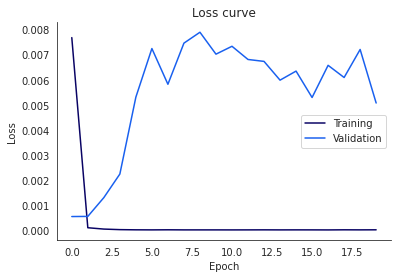

1/1 [==============================] - 0s 15ms/step


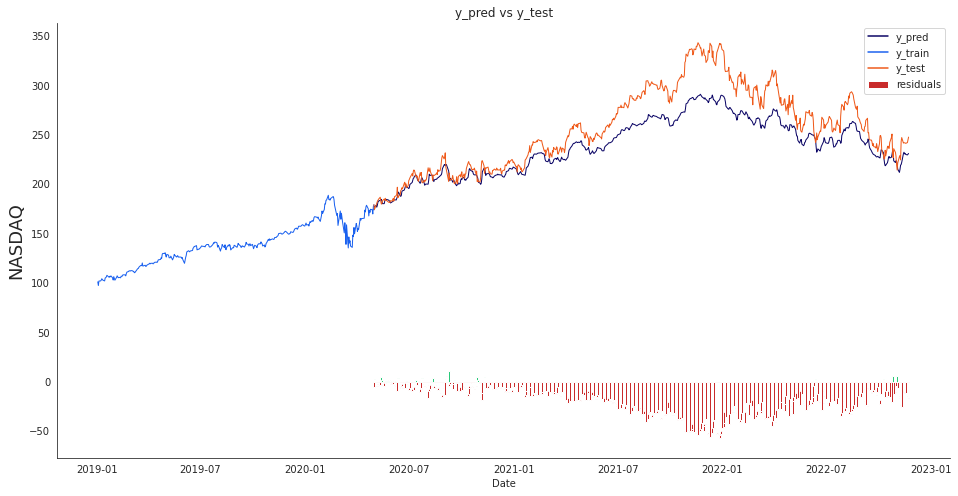

batch_size 8
Epoch 1/20
163/163 [==============================] - 4s 9ms/step - loss: 0.0053 - val_loss: 0.0034
Epoch 2/20
163/163 [==============================] - 1s 5ms/step - loss: 5.1572e-05 - val_loss: 0.0012
Epoch 3/20
163/163 [==============================] - 1s 5ms/step - loss: 3.8989e-05 - val_loss: 4.3802e-04
Epoch 4/20
163/163 [==============================] - 1s 6ms/step - loss: 2.8975e-05 - val_loss: 6.4768e-04
Epoch 5/20
163/163 [==============================] - 1s 6ms/step - loss: 2.5673e-05 - val_loss: 0.0021
Epoch 6/20
163/163 [==============================] - 1s 6ms/step - loss: 2.5816e-05 - val_loss: 0.0032
Epoch 7/20
163/163 [==============================] - 1s 6ms/step - loss: 2.9619e-05 - val_loss: 0.0019
Epoch 8/20
163/163 [==============================] - 1s 6ms/step - loss: 2.5772e-05 - val_loss: 0.0030
Epoch 9/20
163/163 [==============================] - 1s 5ms/step - loss: 2.5776e-05 - val_loss: 0.0035
Epoch 10/20
163/163 [==========================

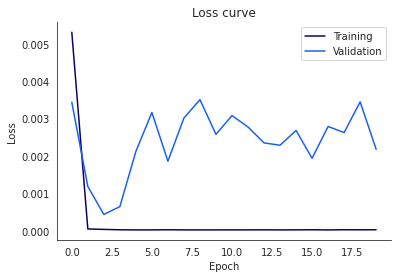

1/1 [==============================] - 0s 20ms/step


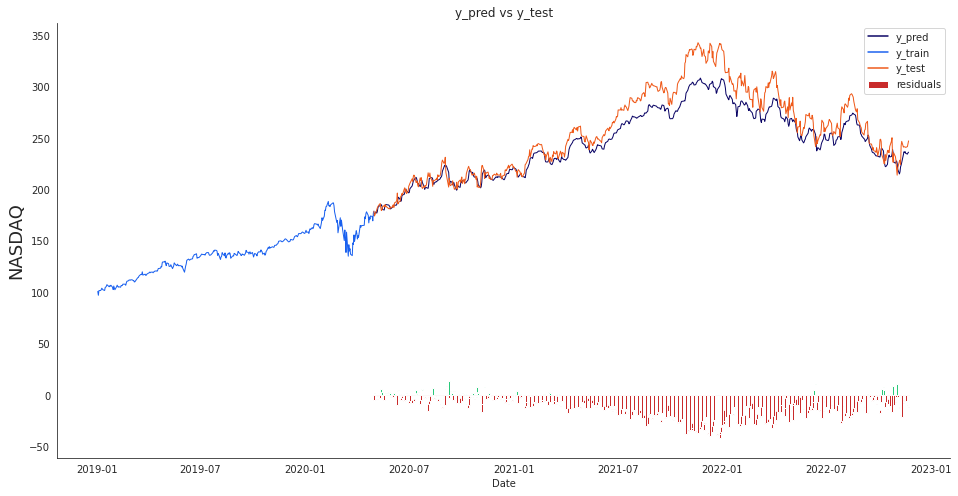

batch_size 16
Epoch 1/20
163/163 [==============================] - 4s 11ms/step - loss: 0.0063 - val_loss: 0.0017
Epoch 2/20
163/163 [==============================] - 1s 5ms/step - loss: 3.5244e-05 - val_loss: 0.0031
Epoch 3/20
163/163 [==============================] - 1s 5ms/step - loss: 3.0595e-05 - val_loss: 0.0053
Epoch 4/20
163/163 [==============================] - 1s 6ms/step - loss: 2.6695e-05 - val_loss: 0.0054
Epoch 5/20
163/163 [==============================] - 1s 6ms/step - loss: 2.5901e-05 - val_loss: 0.0078
Epoch 6/20
163/163 [==============================] - 1s 6ms/step - loss: 2.6292e-05 - val_loss: 0.0090
Epoch 7/20
163/163 [==============================] - 1s 6ms/step - loss: 3.0972e-05 - val_loss: 0.0070
Epoch 8/20
163/163 [==============================] - 1s 6ms/step - loss: 2.7693e-05 - val_loss: 0.0082
Epoch 9/20
163/163 [==============================] - 1s 5ms/step - loss: 2.7851e-05 - val_loss: 0.0084
Epoch 10/20
163/163 [==============================] 

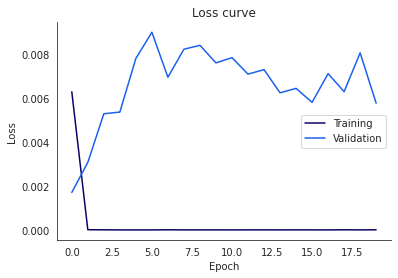

1/1 [==============================] - 0s 14ms/step


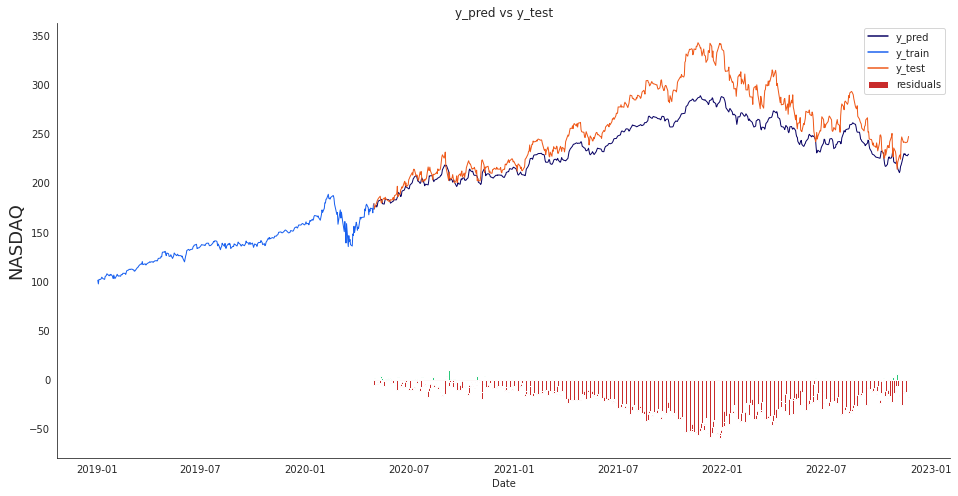

batch_size 32
Epoch 1/20
163/163 [==============================] - 4s 9ms/step - loss: 0.0052 - val_loss: 0.0024
Epoch 2/20
163/163 [==============================] - 1s 5ms/step - loss: 8.1618e-05 - val_loss: 7.7950e-04
Epoch 3/20
163/163 [==============================] - 1s 5ms/step - loss: 3.2197e-05 - val_loss: 0.0030
Epoch 4/20
163/163 [==============================] - 1s 5ms/step - loss: 2.4616e-05 - val_loss: 0.0028
Epoch 5/20
163/163 [==============================] - 1s 6ms/step - loss: 2.4104e-05 - val_loss: 0.0054
Epoch 6/20
163/163 [==============================] - 1s 6ms/step - loss: 2.5403e-05 - val_loss: 0.0058
Epoch 7/20
163/163 [==============================] - 1s 5ms/step - loss: 2.8748e-05 - val_loss: 0.0043
Epoch 8/20
163/163 [==============================] - 1s 5ms/step - loss: 2.5798e-05 - val_loss: 0.0052
Epoch 9/20
163/163 [==============================] - 1s 6ms/step - loss: 2.5840e-05 - val_loss: 0.0061
Epoch 10/20
163/163 [=============================

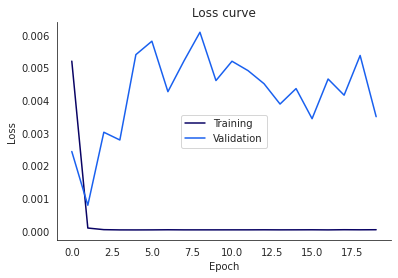

1/1 [==============================] - 0s 15ms/step


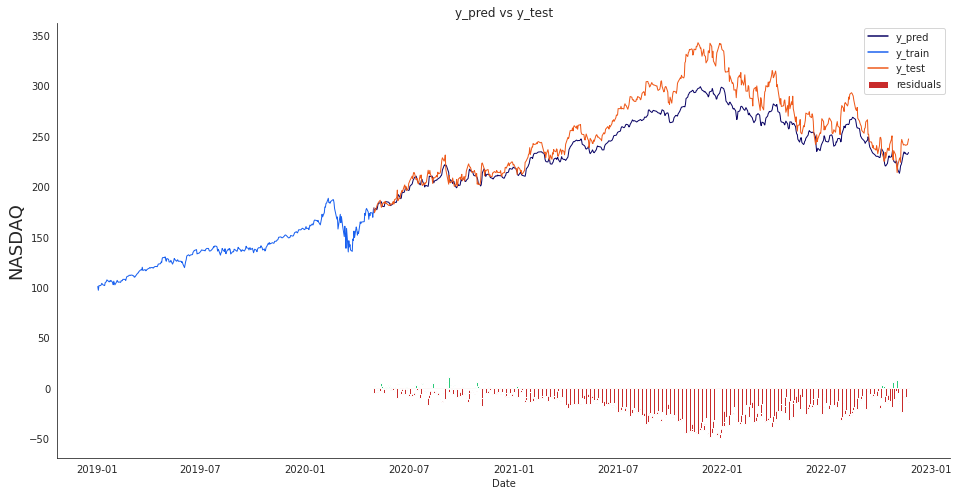

batch_size 64
Epoch 1/20
163/163 [==============================] - 4s 9ms/step - loss: 0.0079 - val_loss: 0.0014
Epoch 2/20
163/163 [==============================] - 1s 6ms/step - loss: 5.8198e-05 - val_loss: 8.2127e-04
Epoch 3/20
163/163 [==============================] - 1s 6ms/step - loss: 4.1958e-05 - val_loss: 0.0023
Epoch 4/20
163/163 [==============================] - 1s 5ms/step - loss: 3.0694e-05 - val_loss: 0.0032
Epoch 5/20
163/163 [==============================] - 1s 6ms/step - loss: 2.6463e-05 - val_loss: 0.0059
Epoch 6/20
163/163 [==============================] - 1s 5ms/step - loss: 2.5550e-05 - val_loss: 0.0073
Epoch 7/20
163/163 [==============================] - 1s 6ms/step - loss: 2.8377e-05 - val_loss: 0.0060
Epoch 8/20
163/163 [==============================] - 1s 6ms/step - loss: 2.6145e-05 - val_loss: 0.0074
Epoch 9/20
163/163 [==============================] - 1s 6ms/step - loss: 2.6310e-05 - val_loss: 0.0074
Epoch 10/20
163/163 [=============================

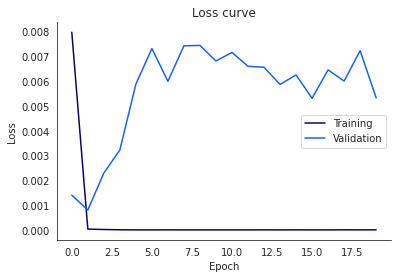

1/1 [==============================] - 0s 16ms/step


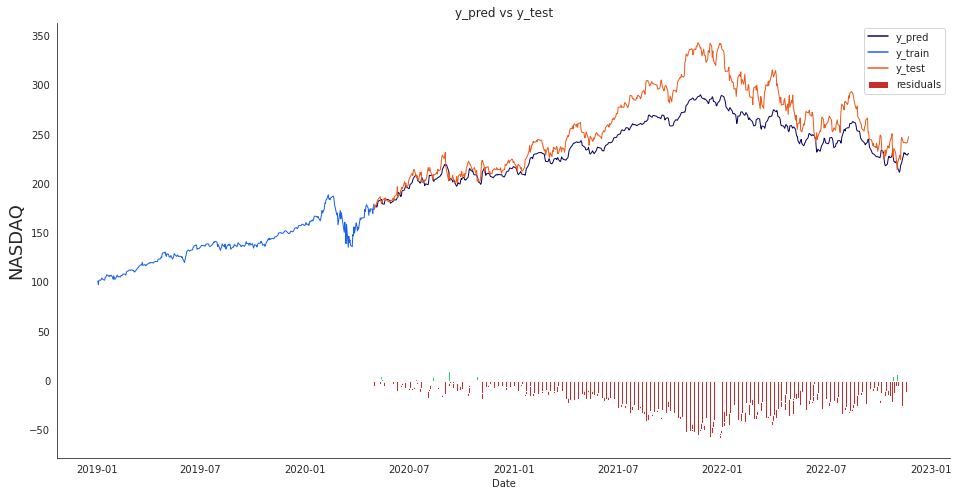

batch_size 128
Epoch 1/20
163/163 [==============================] - 4s 10ms/step - loss: 0.0053 - val_loss: 0.0016
Epoch 2/20
163/163 [==============================] - 1s 5ms/step - loss: 3.0524e-05 - val_loss: 0.0023
Epoch 3/20
163/163 [==============================] - 1s 6ms/step - loss: 2.7467e-05 - val_loss: 0.0037
Epoch 4/20
163/163 [==============================] - 1s 6ms/step - loss: 2.3932e-05 - val_loss: 0.0031
Epoch 5/20
163/163 [==============================] - 1s 6ms/step - loss: 2.3954e-05 - val_loss: 0.0055
Epoch 6/20
163/163 [==============================] - 1s 6ms/step - loss: 2.5135e-05 - val_loss: 0.0063
Epoch 7/20
163/163 [==============================] - 1s 6ms/step - loss: 2.9582e-05 - val_loss: 0.0043
Epoch 8/20
163/163 [==============================] - 1s 6ms/step - loss: 2.6280e-05 - val_loss: 0.0054
Epoch 9/20
163/163 [==============================] - 1s 6ms/step - loss: 2.6141e-05 - val_loss: 0.0062
Epoch 10/20
163/163 [==============================]

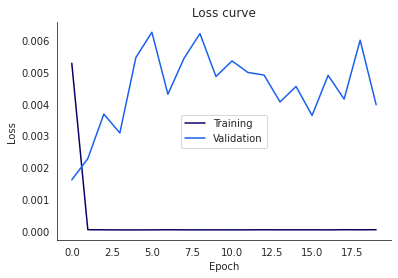

1/1 [==============================] - 0s 18ms/step


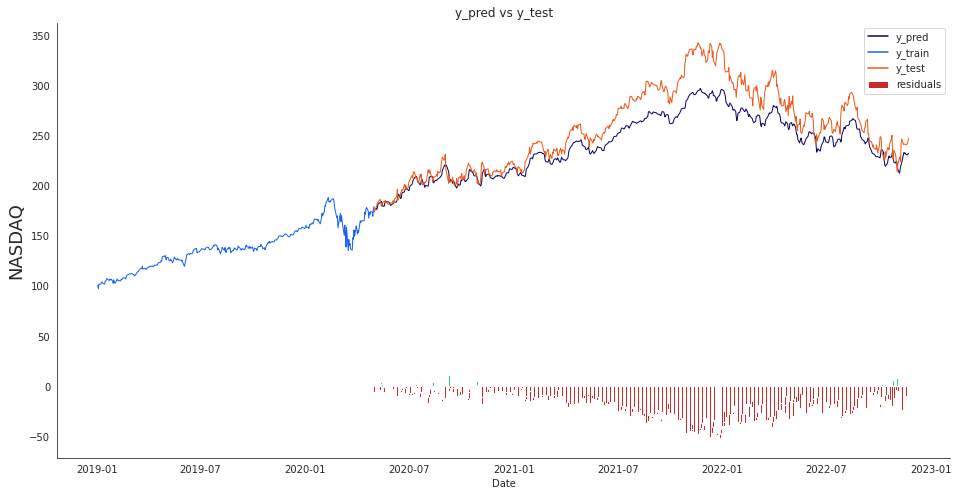

[{'epochs': 20, 'batch_size': 2, 'sequence_length': 2, 'mae': 18.326827509193812, 'mape': 6.550539895192843, 'mdape': 6.077880920774372, 'mse': 519.9367577710486, 'test_prediction_difference': 15.35000427246095, 'training_time': 23.532746, 'number_of_layers': 0}, {'epochs': 20, 'batch_size': 8, 'sequence_length': 2, 'mae': 11.630530758521209, 'mape': 4.165075228858071, 'mdape': 3.7514271649293116, 'mse': 223.1711045522408, 'test_prediction_difference': 9.650007324218763, 'training_time': 26.745223, 'number_of_layers': 0}, {'epochs': 20, 'batch_size': 16, 'sequence_length': 2, 'mae': 19.86750842830615, 'mape': 7.13386140568016, 'mdape': 6.772608592027472, 'mse': 592.5539056501289, 'test_prediction_difference': 17.059995727539075, 'training_time': 24.770391, 'number_of_layers': 0}, {'epochs': 20, 'batch_size': 32, 'sequence_length': 2, 'mae': 14.963259610262767, 'mape': 5.34151211419382, 'mdape': 4.847947279839135, 'mse': 357.5750975212671, 'test_prediction_difference': 12.38000305175782

In [ ]:
#Experiment for batch sizes
random_seed()
start_time = datetime.datetime.now()
print("start time ", start_time)

end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'
stockname = 'NASDAQ'
symbol = 'MSFT'
model_name = 'LSTM'
epochs = 20
batch_sizes = [2,8,16,32,64,128]
learning_rate = 0.001
number_of_layer = 0


loss_func = tf.keras.losses.MeanSquaredError()
sequence_length = 2
features = ['High', 'Low', 'Open', 'Close', 'Volume']
# features = ['High', 'Low', 'Open', 'Close']

# Train LSTM model
input_data_df = get_data(symbol, start_date, end_date)
results_lstm_bs = []
for bs in batch_sizes:
  print('batch_size', bs)
  optimizer = tf.keras.optimizers.Adam(learning_rate)
  result = train_networks(input_data_df, features, model_name, epochs, batch_size, optimizer,loss_func, sequence_length, number_of_layer)
  result['batch_size'] = bs
  results_lstm_bs.append(result)
print(results_lstm_bs)

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)

###Result

In [ ]:
results_lstm_bs
result_df_lstm_bs = pd.DataFrame(results_lstm_bs)
result_df_lstm_bs.sort_values(by=["mse"])

epochs  batch_size  sequence_length        mae      mape     mdape  \
1      20           8                2  11.630531  4.165075  3.751427   
3      20          32                2  14.963260  5.341512  4.847947   
5      20         128                2  16.161295  5.786034  5.341764   
0      20           2                2  18.326828  6.550540  6.077881   
4      20          64                2  18.806419  6.730461  6.295665   
2      20          16                2  19.867508  7.133861  6.772609   

          mse  test_prediction_difference  training_time  number_of_layers  
1  223.171105                    9.650007      26.745223                 0  
3  357.575098                   12.380003      24.728079                 0  
5  407.142584                   13.600004      25.599147                 0  
0  519.936758                   15.350004      23.532746                 0  
4  544.264880                   15.830000      25.103954                 0  
2  592.553906                   17.059996      24.770391                 0

##Experiment for sequence length

###Experiment

[*********************100%***********************]  1 of 1 completed
sequence_length 20 , model  SimpleRNN
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100, 500)          253000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 500)               500500    
                                                                 
 dense_16 (Dense)            (None, 7)                 3507      
                                                                 
 dense_17 (Dense)            (None, 1)                 8         
                                                                 
Total params: 757,015
Trainable params: 757,015
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
313/313 [==============================] - 54s 168ms/step - lo

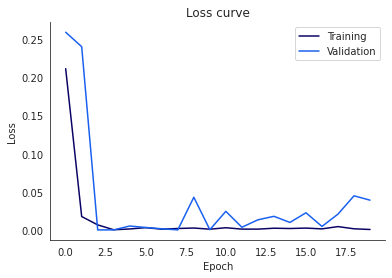

1/1 [==============================] - 0s 33ms/step


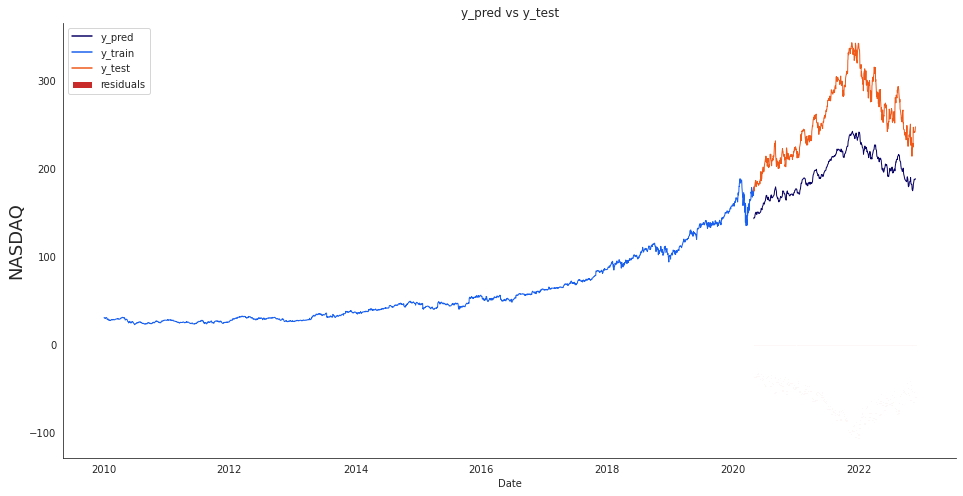

sequence_length 20 , model  LSTM
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100, 500)          1012000   
                                                                 
 lstm_3 (LSTM)               (None, 500)               2002000   
                                                                 
 dense_18 (Dense)            (None, 7)                 3507      
                                                                 
 dense_19 (Dense)            (None, 1)                 8         
                                                                 
Total params: 3,017,515
Trainable params: 3,017,515
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
313/313 [==============================] - 10s 24ms/step - loss: 5.6799e-04 - val_loss: 6.5338e-04
Epoch 2/20
313/313 [=============

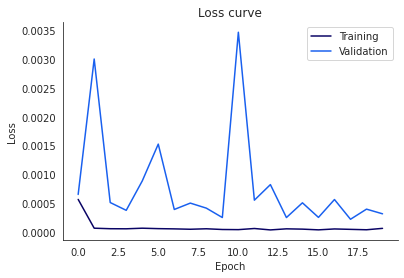

1/1 [==============================] - 0s 22ms/step


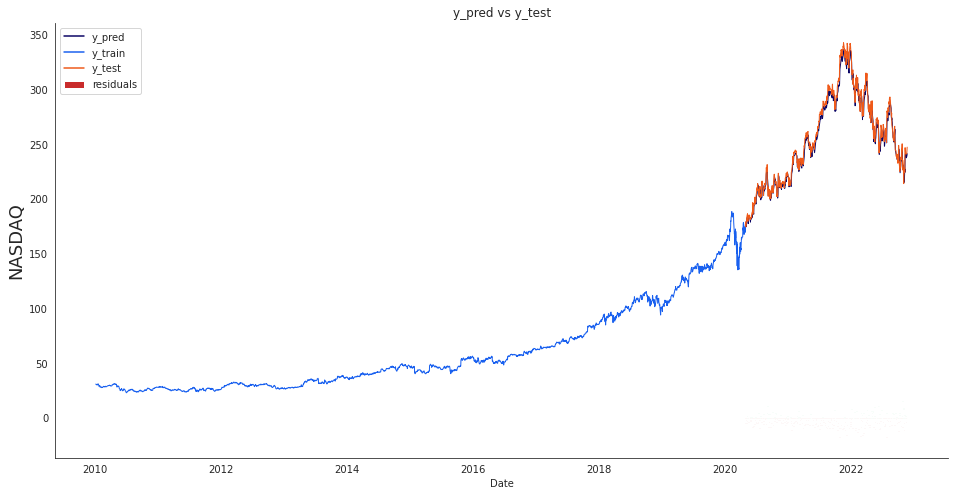

sequence_length 20 , model  GRU
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_14 (GRU)                (None, 100, 500)          760500    
                                                                 
 gru_15 (GRU)                (None, 500)               1503000   
                                                                 
 dense_20 (Dense)            (None, 7)                 3507      
                                                                 
 dense_21 (Dense)            (None, 1)                 8         
                                                                 
Total params: 2,267,015
Trainable params: 2,267,015
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
313/313 [==============================] - 9s 20ms/step - loss: 3.3405e-04 - val_loss: 4.5649e-04
Epoch 2/20
313/313 [==============

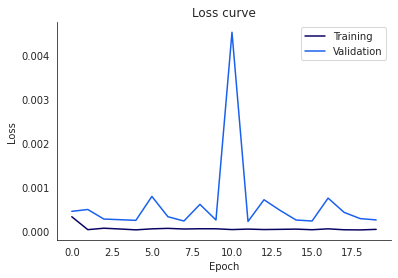

1/1 [==============================] - 0s 23ms/step


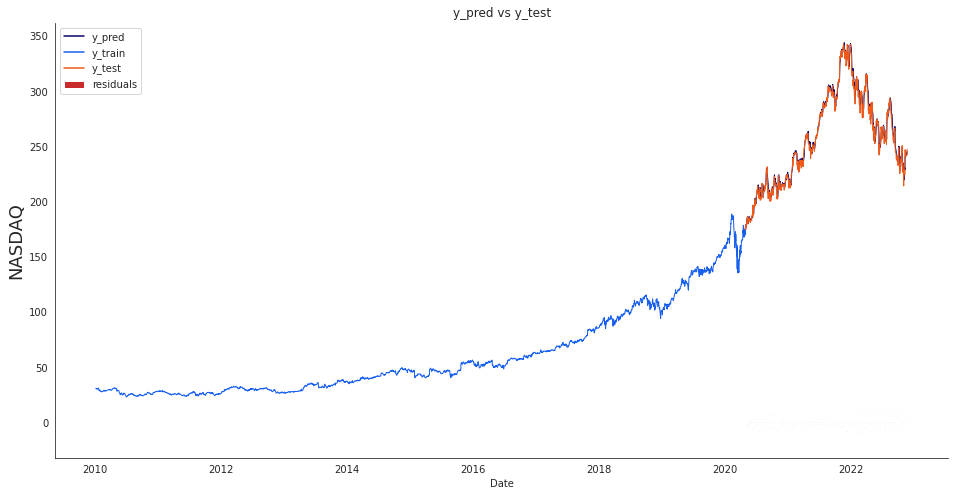

sequence_length 40 , model  SimpleRNN
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 100, 500)          253000    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 500)               500500    
                                                                 
 dense_22 (Dense)            (None, 7)                 3507      
                                                                 
 dense_23 (Dense)            (None, 1)                 8         
                                                                 
Total params: 757,015
Trainable params: 757,015
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
313/313 [==============================] - 54s 169ms/step - loss: 0.3687 - val_loss: 0.2849
Epoch 2/20
313/313 [==================

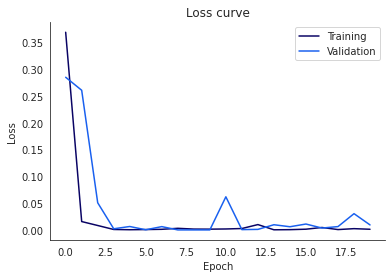

1/1 [==============================] - 0s 35ms/step


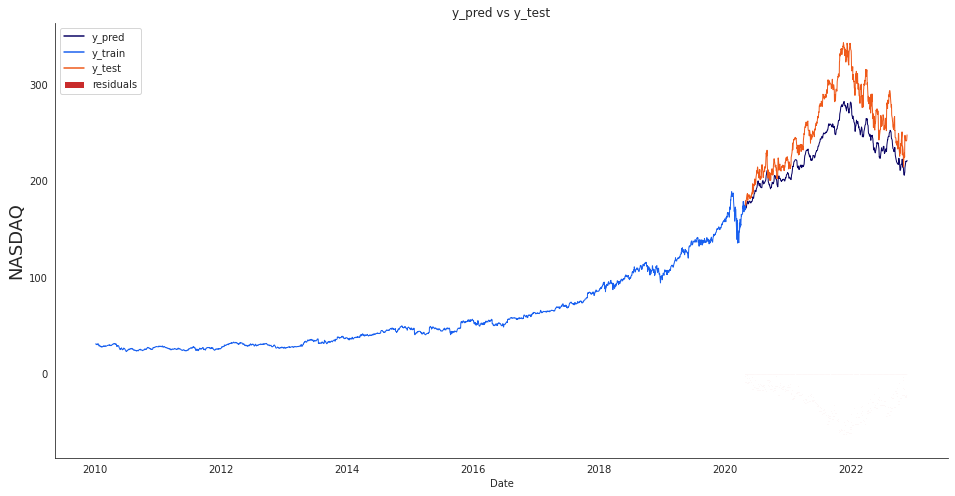

sequence_length 40 , model  LSTM
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 500)          1012000   
                                                                 
 lstm_5 (LSTM)               (None, 500)               2002000   
                                                                 
 dense_24 (Dense)            (None, 7)                 3507      
                                                                 
 dense_25 (Dense)            (None, 1)                 8         
                                                                 
Total params: 3,017,515
Trainable params: 3,017,515
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
313/313 [==============================] - 10s 25ms/step - loss: 4.4842e-04 - val_loss: 6.3698e-04
Epoch 2/20
313/313 [============

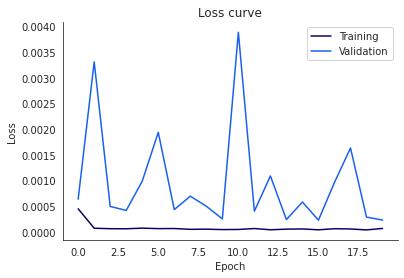

1/1 [==============================] - 0s 27ms/step


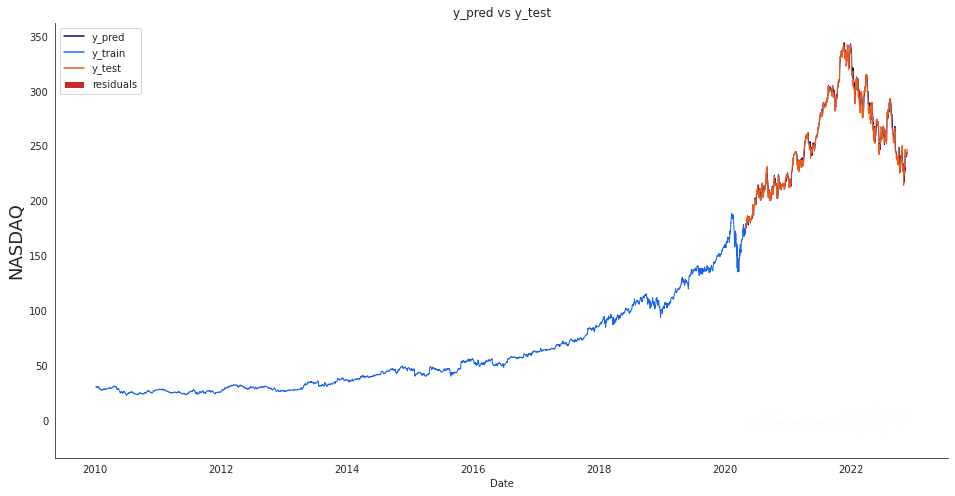

sequence_length 40 , model  GRU
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_16 (GRU)                (None, 100, 500)          760500    
                                                                 
 gru_17 (GRU)                (None, 500)               1503000   
                                                                 
 dense_26 (Dense)            (None, 7)                 3507      
                                                                 
 dense_27 (Dense)            (None, 1)                 8         
                                                                 
Total params: 2,267,015
Trainable params: 2,267,015
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
313/313 [==============================] - 9s 21ms/step - loss: 4.3111e-04 - val_loss: 3.4035e-04
Epoch 2/20
313/313 [==============

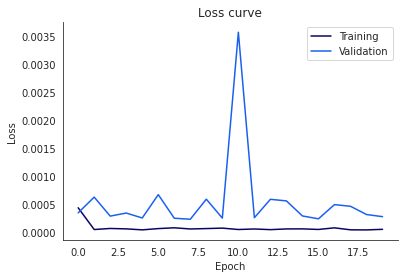

1/1 [==============================] - 0s 24ms/step


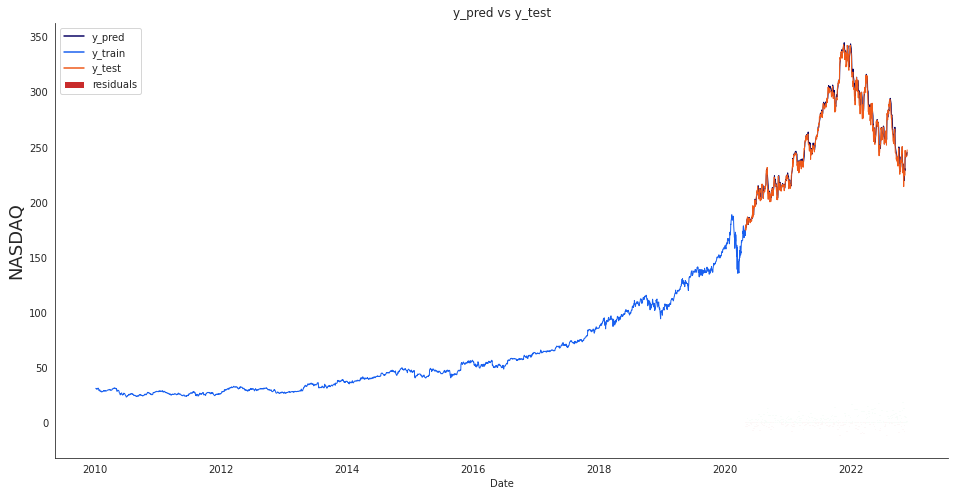

sequence_length 60 , model  SimpleRNN
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 100, 500)          253000    
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 500)               500500    
                                                                 
 dense_28 (Dense)            (None, 7)                 3507      
                                                                 
 dense_29 (Dense)            (None, 1)                 8         
                                                                 
Total params: 757,015
Trainable params: 757,015
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
313/313 [==============================] - 56s 175ms/step - loss: 0.2141 - val_loss: 0.2341
Epoch 2/20
313/313 [==================

In [ ]:
#Experiment for sequence length
random_seed()

end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'
stockname = 'NASDAQ'
symbol = 'MSFT'
# model_name = 'LSTM'
epochs = 20
batch_size = 8
learning_rate = 0.001
number_of_layer = 0

loss_func = tf.keras.losses.MeanSquaredError()
sequence_lengths = [20, 40, 60, 80, 100]
features = ['High', 'Low', 'Open', 'Close', 'Volume']
# features = ['High', 'Low', 'Open', 'Close']

# Train LSTM model
input_data_df = get_data(symbol, start_date, end_date)
results_lstm_sl_2 = []
for sl in sequence_lengths:
  for model_name in ['SimpleRNN','LSTM','GRU']:
    print('sequence_length', sl, ', model ', model_name)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    result = train_networks(input_data_df, features, model_name, epochs, batch_size, optimizer,loss_func, sequence_length,number_of_layer)
    result['sequence_length'] = sl
    results_lstm_sl_2.append(result)


###Result

In [ ]:
results_lstm_sl_2
result_df_lstm_sl_2 = pd.DataFrame(results_lstm_sl_2)
result_df_lstm_sl_2.sort_values(by=["mse"])

epochs  batch_size  sequence_length        mae      mape     mdape  \
1      20           8                4  12.189044  4.346215  3.864119   
3      20           8               40  15.081429  5.391080  4.940353   
5      20           8              100  17.617042  6.321894  5.913813   
6      20           8              120  18.044568  6.462756  6.019792   
0      20           8                2  18.708068  6.700789  6.250108   
4      20           8               80  18.804031  6.737928  6.287416   
2      20           8               20  20.073848  7.212389  6.868467   

          mse  test_prediction_difference  training_time  number_of_layers  
1  248.409317                    9.790007      46.542578                 0  
3  359.698455                   12.580000      87.576824                 0  
5  472.422609                   14.999998      44.880183                 0  
6  499.839325                   15.309996      46.650483                 0  
0  534.266698                   15.800001      46.370617                 0  
4  540.098549                   15.859999      45.894254                 0  
2  601.817948                   17.229994      87.716630                 0

# Experiment for Simple RNN

## Experiment for learning rates

###Experiment

[*********************100%***********************]  1 of 1 completed
learning rate 0.1
Epoch 1/20
163/163 [==============================] - 4s 11ms/step - loss: 0.0723 - val_loss: 0.0294
Epoch 2/20
163/163 [==============================] - 1s 9ms/step - loss: 8.4064e-04 - val_loss: 0.0820
Epoch 3/20
163/163 [==============================] - 1s 9ms/step - loss: 3.2722e-04 - val_loss: 0.0441
Epoch 4/20
163/163 [==============================] - 3s 15ms/step - loss: 2.7394e-04 - val_loss: 0.0020
Epoch 5/20
163/163 [==============================] - 2s 15ms/step - loss: 2.4887e-04 - val_loss: 0.0112
Epoch 6/20
163/163 [==============================] - 2s 12ms/step - loss: 1.8031e-04 - val_loss: 0.0426
Epoch 7/20
163/163 [==============================] - 2s 13ms/step - loss: 4.1357e-04 - val_loss: 0.0143
Epoch 8/20
163/163 [==============================] - 1s 9ms/step - loss: 2.1194e-04 - val_loss: 0.0532
Epoch 9/20
163/163 [==============================] - 1s 9ms/step - loss: 4.4742

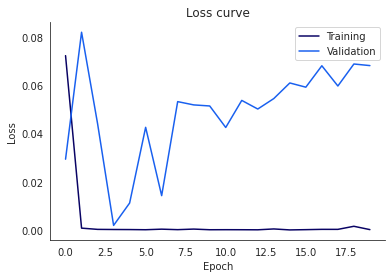

1/1 [==============================] - 0s 14ms/step


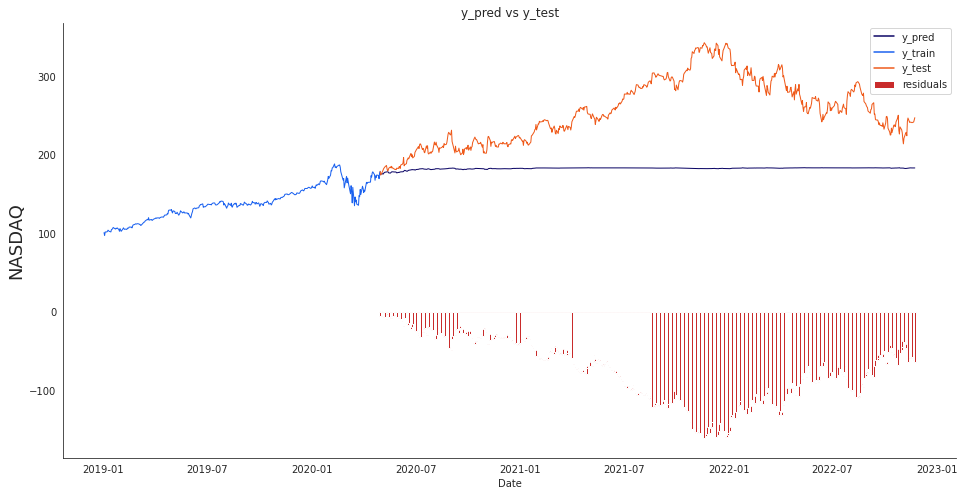

learning rate 0.001
Epoch 1/20
163/163 [==============================] - 3s 11ms/step - loss: 0.0012 - val_loss: 0.0214
Epoch 2/20
163/163 [==============================] - 2s 9ms/step - loss: 7.7951e-05 - val_loss: 0.0128
Epoch 3/20
163/163 [==============================] - 2s 9ms/step - loss: 5.3841e-05 - val_loss: 0.0109
Epoch 4/20
163/163 [==============================] - 1s 9ms/step - loss: 4.9965e-05 - val_loss: 0.0059
Epoch 5/20
163/163 [==============================] - 2s 9ms/step - loss: 5.1628e-05 - val_loss: 0.0072
Epoch 6/20
163/163 [==============================] - 1s 9ms/step - loss: 4.9131e-05 - val_loss: 0.0076
Epoch 7/20
163/163 [==============================] - 2s 9ms/step - loss: 5.1380e-05 - val_loss: 0.0047
Epoch 8/20
163/163 [==============================] - 1s 9ms/step - loss: 6.0883e-05 - val_loss: 0.0059
Epoch 9/20
163/163 [==============================] - 2s 9ms/step - loss: 4.3257e-05 - val_loss: 0.0051
Epoch 10/20
163/163 [==========================

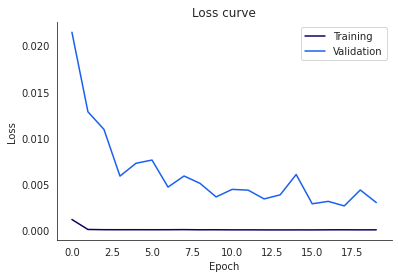

1/1 [==============================] - 0s 18ms/step


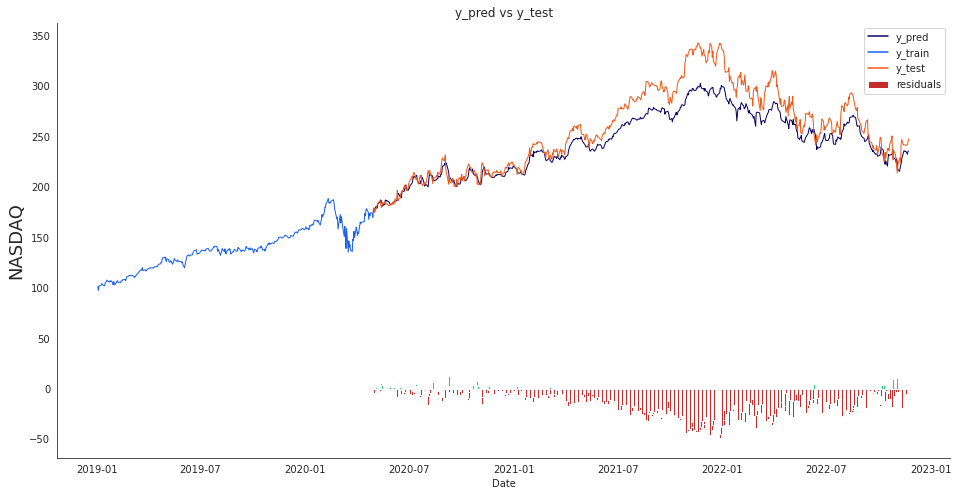

learning rate 0.0001
Epoch 1/20
163/163 [==============================] - 3s 11ms/step - loss: 0.0303 - val_loss: 0.2270
Epoch 2/20
163/163 [==============================] - 2s 10ms/step - loss: 0.0031 - val_loss: 0.0501
Epoch 3/20
163/163 [==============================] - 2s 10ms/step - loss: 1.9833e-04 - val_loss: 0.0328
Epoch 4/20
163/163 [==============================] - 2s 9ms/step - loss: 1.2270e-04 - val_loss: 0.0294
Epoch 5/20
163/163 [==============================] - 2s 9ms/step - loss: 9.6413e-05 - val_loss: 0.0282
Epoch 6/20
163/163 [==============================] - 1s 9ms/step - loss: 8.1293e-05 - val_loss: 0.0276
Epoch 7/20
163/163 [==============================] - 2s 10ms/step - loss: 7.2319e-05 - val_loss: 0.0273
Epoch 8/20
163/163 [==============================] - 2s 9ms/step - loss: 6.5857e-05 - val_loss: 0.0267
Epoch 9/20
163/163 [==============================] - 2s 9ms/step - loss: 6.2225e-05 - val_loss: 0.0261
Epoch 10/20
163/163 [==========================

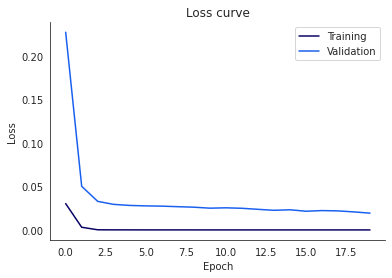

1/1 [==============================] - 0s 15ms/step


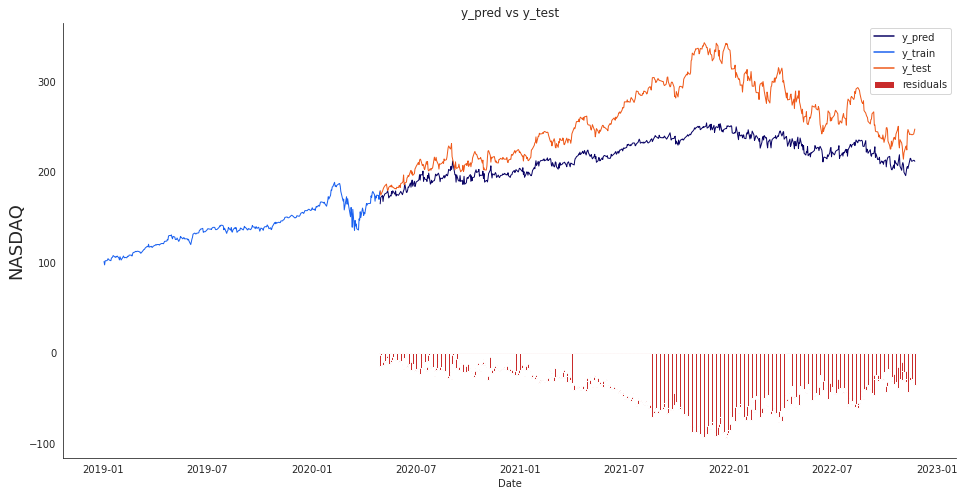

learning rate 1e-05
Epoch 1/20
163/163 [==============================] - 3s 11ms/step - loss: 0.1930 - val_loss: 2.2054
Epoch 2/20
163/163 [==============================] - 2s 9ms/step - loss: 0.1607 - val_loss: 1.9908
Epoch 3/20
163/163 [==============================] - 2s 9ms/step - loss: 0.1346 - val_loss: 1.7961
Epoch 4/20
163/163 [==============================] - 2s 9ms/step - loss: 0.1132 - val_loss: 1.6243
Epoch 5/20
163/163 [==============================] - 2s 10ms/step - loss: 0.0954 - val_loss: 1.4677
Epoch 6/20
163/163 [==============================] - 2s 9ms/step - loss: 0.0809 - val_loss: 1.3277
Epoch 7/20
163/163 [==============================] - 2s 9ms/step - loss: 0.0689 - val_loss: 1.2015
Epoch 8/20
163/163 [==============================] - 1s 9ms/step - loss: 0.0591 - val_loss: 1.0885
Epoch 9/20
163/163 [==============================] - 2s 10ms/step - loss: 0.0510 - val_loss: 0.9869
Epoch 10/20
163/163 [==============================] - 2s 9ms/step - loss: 0.

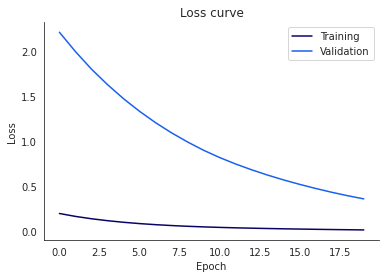

1/1 [==============================] - 0s 15ms/step


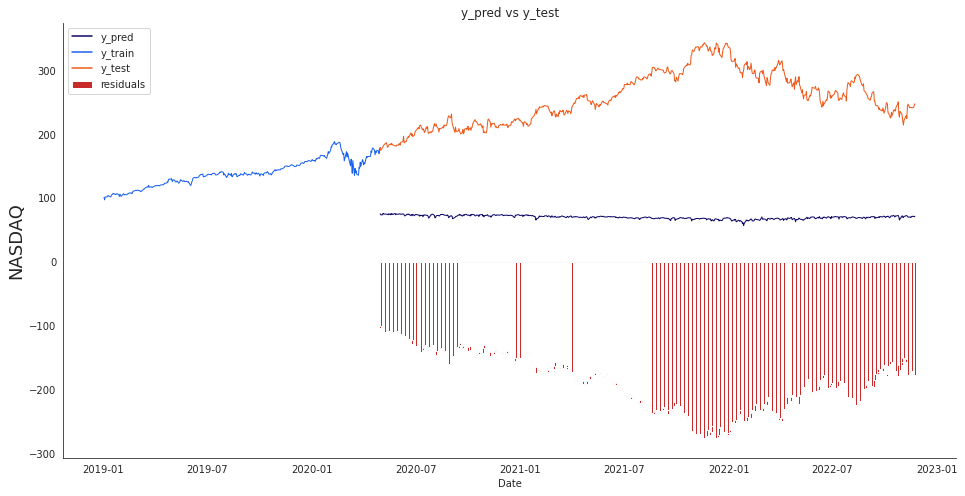

[{'epochs': 20, 'batch_size': 16, 'sequence_length': 2, 'mae': 73.12400730879537, 'mape': 26.72386275178706, 'mdape': 27.411714788553876, 'mse': 6984.389731207713, 'test_prediction_difference': 64.0400067138672, 'training_time': 44.877679, 'number_of_layers': 1, 'learning_rate': 0.1}, {'epochs': 20, 'batch_size': 16, 'sequence_length': 2, 'mae': 13.513839627634745, 'mape': 4.801357497655866, 'mdape': 4.127298722987676, 'mse': 306.9228680594235, 'test_prediction_difference': 11.309995727539075, 'training_time': 45.321683, 'number_of_layers': 1, 'learning_rate': 0.001}, {'epochs': 20, 'batch_size': 16, 'sequence_length': 2, 'mae': 38.65017695493064, 'mape': 14.140864219303984, 'mdape': 13.786486173860895, 'mse': 1978.2368780031745, 'test_prediction_difference': 33.46999938964845, 'training_time': 44.845434, 'number_of_layers': 1, 'learning_rate': 0.0001}, {'epochs': 20, 'batch_size': 16, 'sequence_length': 2, 'mae': 185.71857689268234, 'mape': 71.66000608966867, 'mdape': 72.3235935005143

In [ ]:
#Experiment for learning rates
random_seed()
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'
stockname = 'NASDAQ'
symbol = 'MSFT'
model_name = 'SimpleRNN'
epochs = 20
batch_size = 16
learning_rates = [0.1, 0.001, 0.0001, 0.00001]
number_of_layer = 1

loss_func = tf.keras.losses.MeanSquaredError()
sequence_length = 2
features = ['High', 'Low', 'Open', 'Close', 'Volume']
# features = ['High', 'Low', 'Open', 'Close']

# Train LSTM model
input_data_df = get_data(symbol, start_date, end_date)
results_simpleRNN_lr = []
for lr in learning_rates:
  print('learning rate', lr)
  optimizer = tf.keras.optimizers.Adam(lr)
  
  result = train_networks(input_data_df, features, model_name, epochs, batch_size, optimizer,loss_func, sequence_length, number_of_layer)

  result['learning_rate'] = lr  
  results_simpleRNN_lr.append(result)
print(results_simpleRNN_lr)



###Result

In [ ]:
results_simpleRNN_lr
result_df_simpleRNN_lr = pd.DataFrame(results_simpleRNN_lr)
result_df_simpleRNN_lr.sort_values(by=["mse"])

epochs  batch_size  sequence_length         mae       mape      mdape  \
1      20          16                2   13.513840   4.801357   4.127299   
2      20          16                2   38.650177  14.140864  13.786486   
0      20          16                2   73.124007  26.723863  27.411715   
3      20          16                2  185.718577  71.660006  72.323594   

            mse  test_prediction_difference  training_time  number_of_layers  \
1    306.922868                   11.309996      45.321683                 1   
2   1978.236878                   33.469999      44.845434                 1   
0   6984.389731                   64.040007      44.877679                 1   
3  36378.844973                  175.260000      45.331544                 1   

   learning_rate  
1        0.00100  
2        0.00010  
0        0.10000  
3        0.00001

##Experiment for batch sizes

###Experiment

[*********************100%***********************]  1 of 1 completed
batch_size 2
Epoch 1/20
163/163 [==============================] - 4s 15ms/step - loss: 0.0033 - val_loss: 0.0450
Epoch 2/20
163/163 [==============================] - 2s 13ms/step - loss: 8.2396e-05 - val_loss: 0.0343
Epoch 3/20
163/163 [==============================] - 1s 9ms/step - loss: 6.6978e-05 - val_loss: 0.0287
Epoch 4/20
163/163 [==============================] - 1s 9ms/step - loss: 5.3080e-05 - val_loss: 0.0190
Epoch 5/20
163/163 [==============================] - 2s 9ms/step - loss: 4.2745e-05 - val_loss: 0.0177
Epoch 6/20
163/163 [==============================] - 2s 9ms/step - loss: 4.1946e-05 - val_loss: 0.0165
Epoch 7/20
163/163 [==============================] - 1s 9ms/step - loss: 4.1922e-05 - val_loss: 0.0110
Epoch 8/20
163/163 [==============================] - 1s 9ms/step - loss: 3.3247e-05 - val_loss: 0.0096
Epoch 9/20
163/163 [==============================] - 1s 9ms/step - loss: 3.3860e-05 - v

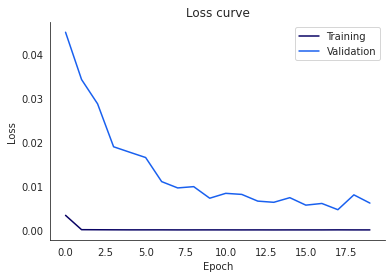

1/1 [==============================] - 0s 15ms/step


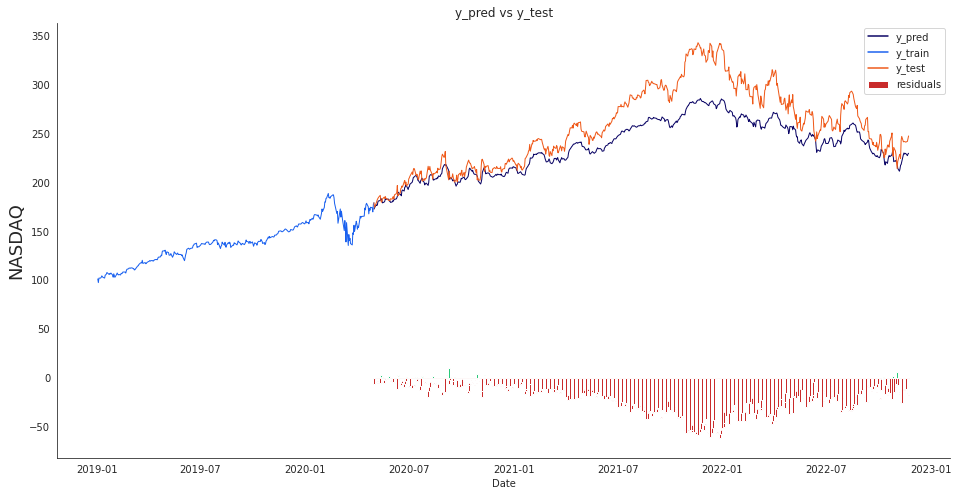

batch_size 8
Epoch 1/20
163/163 [==============================] - 3s 11ms/step - loss: 0.0012 - val_loss: 0.0214
Epoch 2/20
163/163 [==============================] - 2s 9ms/step - loss: 7.7951e-05 - val_loss: 0.0128
Epoch 3/20
163/163 [==============================] - 1s 9ms/step - loss: 5.3841e-05 - val_loss: 0.0109
Epoch 4/20
163/163 [==============================] - 2s 9ms/step - loss: 4.9965e-05 - val_loss: 0.0059
Epoch 5/20
163/163 [==============================] - 1s 9ms/step - loss: 5.1628e-05 - val_loss: 0.0072
Epoch 6/20
163/163 [==============================] - 1s 9ms/step - loss: 4.9131e-05 - val_loss: 0.0076
Epoch 7/20
163/163 [==============================] - 2s 9ms/step - loss: 5.1380e-05 - val_loss: 0.0047
Epoch 8/20
163/163 [==============================] - 2s 9ms/step - loss: 6.0883e-05 - val_loss: 0.0059
Epoch 9/20
163/163 [==============================] - 1s 9ms/step - loss: 4.3257e-05 - val_loss: 0.0051
Epoch 10/20
163/163 [==============================] -

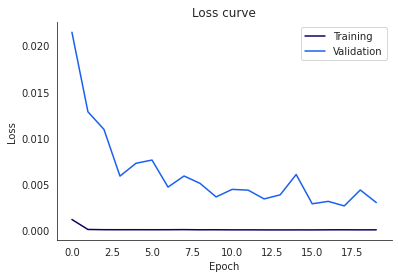

1/1 [==============================] - 0s 17ms/step


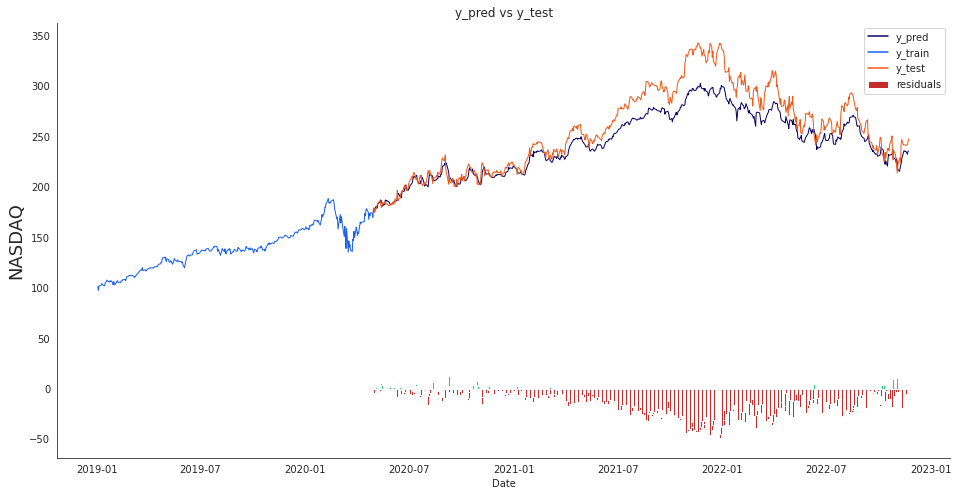

batch_size 16
Epoch 1/20
163/163 [==============================] - 4s 17ms/step - loss: 0.0036 - val_loss: 0.0232
Epoch 2/20
163/163 [==============================] - 1s 9ms/step - loss: 5.6830e-05 - val_loss: 0.0211
Epoch 3/20
163/163 [==============================] - 1s 9ms/step - loss: 5.4879e-05 - val_loss: 0.0193
Epoch 4/20
163/163 [==============================] - 1s 9ms/step - loss: 5.7744e-05 - val_loss: 0.0156
Epoch 5/20
163/163 [==============================] - 1s 9ms/step - loss: 5.0489e-05 - val_loss: 0.0152
Epoch 6/20
163/163 [==============================] - 2s 9ms/step - loss: 5.2378e-05 - val_loss: 0.0141
Epoch 7/20
163/163 [==============================] - 2s 9ms/step - loss: 5.2686e-05 - val_loss: 0.0138
Epoch 8/20
163/163 [==============================] - 1s 9ms/step - loss: 4.9367e-05 - val_loss: 0.0120
Epoch 9/20
163/163 [==============================] - 2s 9ms/step - loss: 5.8906e-05 - val_loss: 0.0112
Epoch 10/20
163/163 [==============================] 

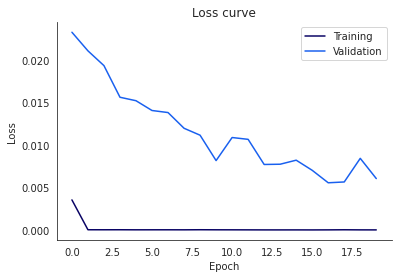

1/1 [==============================] - 0s 14ms/step


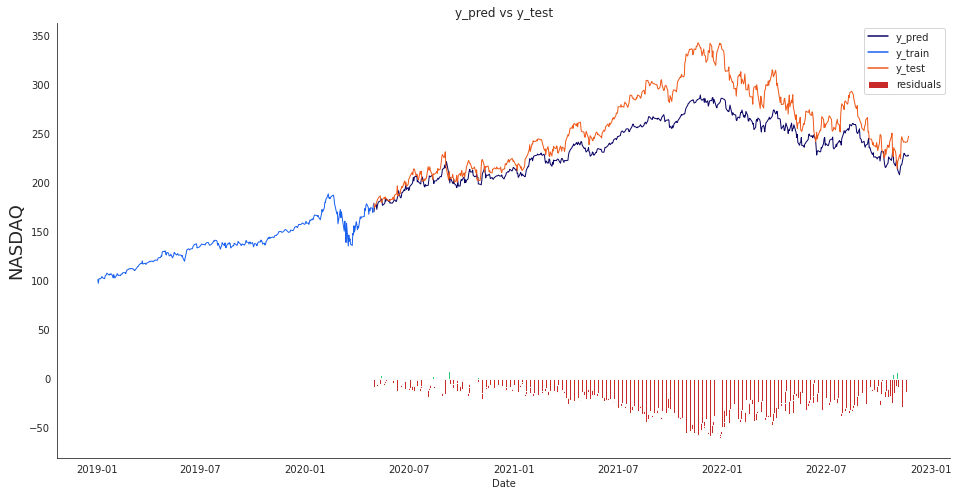

batch_size 32
Epoch 1/20
163/163 [==============================] - 3s 11ms/step - loss: 0.0135 - val_loss: 0.0805
Epoch 2/20
163/163 [==============================] - 2s 9ms/step - loss: 1.9055e-04 - val_loss: 0.0598
Epoch 3/20
163/163 [==============================] - 2s 10ms/step - loss: 1.2564e-04 - val_loss: 0.0465
Epoch 4/20
163/163 [==============================] - 2s 9ms/step - loss: 9.4470e-05 - val_loss: 0.0327
Epoch 5/20
163/163 [==============================] - 2s 9ms/step - loss: 7.1594e-05 - val_loss: 0.0259
Epoch 6/20
163/163 [==============================] - 2s 9ms/step - loss: 6.2247e-05 - val_loss: 0.0224
Epoch 7/20
163/163 [==============================] - 2s 9ms/step - loss: 5.5770e-05 - val_loss: 0.0186
Epoch 8/20
163/163 [==============================] - 2s 9ms/step - loss: 4.7045e-05 - val_loss: 0.0154
Epoch 9/20
163/163 [==============================] - 2s 9ms/step - loss: 4.3572e-05 - val_loss: 0.0147
Epoch 10/20
163/163 [==============================]

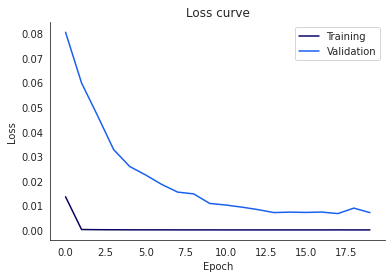

1/1 [==============================] - 0s 14ms/step


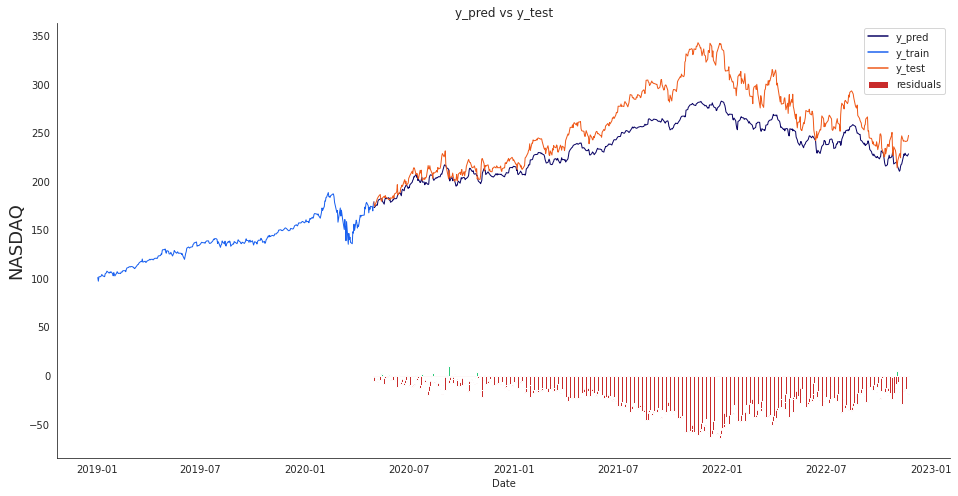

batch_size 64
Epoch 1/20
163/163 [==============================] - 4s 12ms/step - loss: 2.5695e-04 - val_loss: 0.0156
Epoch 2/20
163/163 [==============================] - 2s 10ms/step - loss: 4.3308e-05 - val_loss: 0.0135
Epoch 3/20
163/163 [==============================] - 2s 10ms/step - loss: 3.9163e-05 - val_loss: 0.0149
Epoch 4/20
163/163 [==============================] - 2s 9ms/step - loss: 3.8493e-05 - val_loss: 0.0098
Epoch 5/20
163/163 [==============================] - 2s 10ms/step - loss: 4.8846e-05 - val_loss: 0.0131
Epoch 6/20
163/163 [==============================] - 2s 9ms/step - loss: 3.7517e-05 - val_loss: 0.0129
Epoch 7/20
163/163 [==============================] - 2s 10ms/step - loss: 4.1987e-05 - val_loss: 0.0110
Epoch 8/20
163/163 [==============================] - 2s 10ms/step - loss: 6.0332e-05 - val_loss: 0.0114
Epoch 9/20
163/163 [==============================] - 2s 10ms/step - loss: 3.7601e-05 - val_loss: 0.0116
Epoch 10/20
163/163 [======================

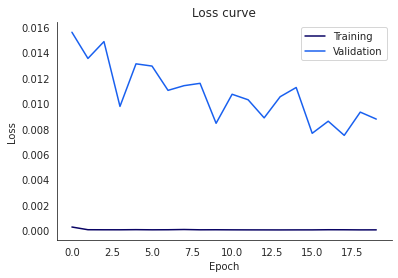

1/1 [==============================] - 0s 17ms/step


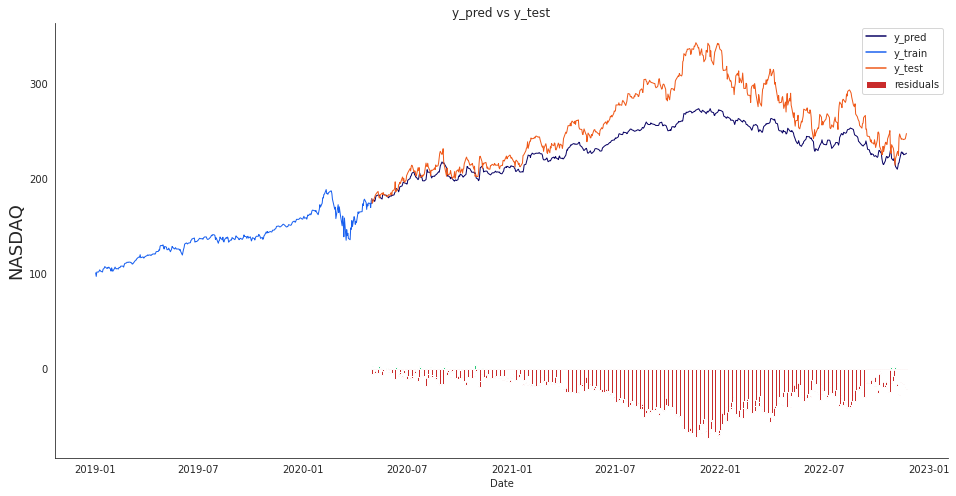

batch_size 128
Epoch 1/20
163/163 [==============================] - 4s 12ms/step - loss: 0.0011 - val_loss: 0.0334
Epoch 2/20
163/163 [==============================] - 2s 10ms/step - loss: 1.0675e-04 - val_loss: 0.0117
Epoch 3/20
163/163 [==============================] - 2s 10ms/step - loss: 3.6782e-05 - val_loss: 0.0082
Epoch 4/20
163/163 [==============================] - 2s 10ms/step - loss: 3.1285e-05 - val_loss: 0.0037
Epoch 5/20
163/163 [==============================] - 2s 10ms/step - loss: 4.3833e-05 - val_loss: 0.0079
Epoch 6/20
163/163 [==============================] - 2s 10ms/step - loss: 3.3946e-05 - val_loss: 0.0091
Epoch 7/20
163/163 [==============================] - 2s 9ms/step - loss: 4.6822e-05 - val_loss: 0.0054
Epoch 8/20
163/163 [==============================] - 2s 10ms/step - loss: 4.0119e-05 - val_loss: 0.0056
Epoch 9/20
163/163 [==============================] - 2s 10ms/step - loss: 3.8664e-05 - val_loss: 0.0058
Epoch 10/20
163/163 [========================

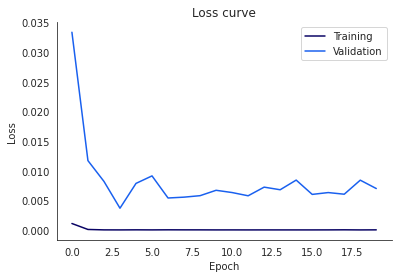

1/1 [==============================] - 0s 19ms/step


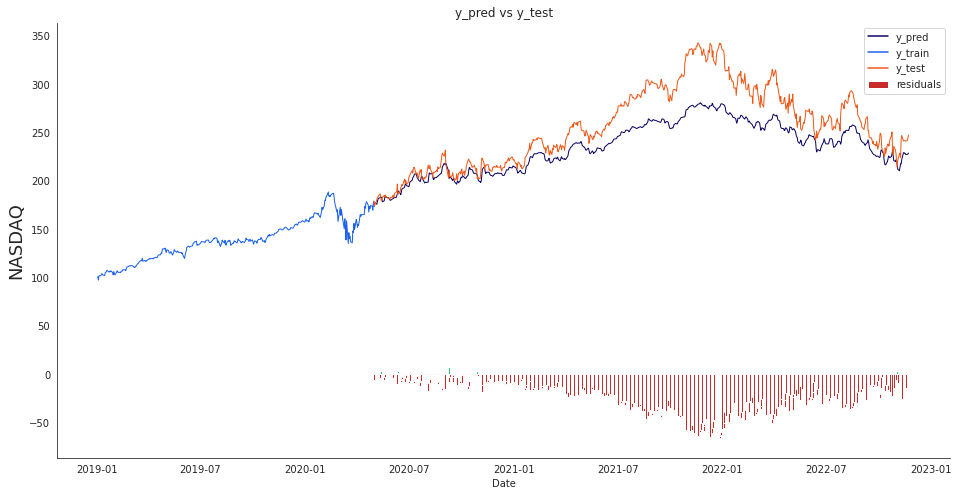

[{'epochs': 20, 'batch_size': 2, 'sequence_length': 2, 'mae': 20.306189726607624, 'mape': 7.274424409734497, 'mdape': 6.842531351080222, 'mse': 628.6285292405294, 'test_prediction_difference': 16.520002441406263, 'training_time': 34.900964, 'number_of_layers': 1}, {'epochs': 20, 'batch_size': 8, 'sequence_length': 2, 'mae': 13.513839627634745, 'mape': 4.801357497655866, 'mdape': 4.127298722987676, 'mse': 306.9228680594235, 'test_prediction_difference': 11.309995727539075, 'training_time': 45.319366, 'number_of_layers': 1}, {'epochs': 20, 'batch_size': 16, 'sequence_length': 2, 'mae': 20.605841426526066, 'mape': 7.4432079465486, 'mdape': 7.106877716494278, 'mse': 621.3960976717783, 'test_prediction_difference': 17.96999938964845, 'training_time': 35.26856, 'number_of_layers': 1}, {'epochs': 20, 'batch_size': 32, 'sequence_length': 2, 'mae': 22.0192972897381, 'mape': 7.908297223922828, 'mdape': 7.49342099297937, 'mse': 724.2725704269335, 'test_prediction_difference': 17.869993286132825, 

In [ ]:
#Experiment for batch sizes
random_seed()
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'
stockname = 'NASDAQ'
symbol = 'MSFT'
model_name = 'SimpleRNN'
epochs = 20
batch_sizes = [2,8,16,32,64,128]
learning_rate = 0.001
number_of_layer = 1


loss_func = tf.keras.losses.MeanSquaredError()
sequence_length = 2
features = ['High', 'Low', 'Open', 'Close', 'Volume']
# features = ['High', 'Low', 'Open', 'Close']

# Train SimpleRNN model
input_data_df = get_data(symbol, start_date, end_date)
results_simpleRNN_bs = []
for bs in batch_sizes:
  print('batch_size', bs)
  optimizer = tf.keras.optimizers.Adam(learning_rate)
  result = train_networks(input_data_df, features, model_name, epochs, batch_size, optimizer,loss_func, sequence_length,number_of_layer)
  result['batch_size'] = bs
  results_simpleRNN_bs.append(result)
print(results_simpleRNN_bs)

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)

###Result

In [ ]:
results_simpleRNN_bs
result_df_simpleRNN_bs = pd.DataFrame(results_simpleRNN_bs)
result_df_simpleRNN_bs.sort_values(by=["mse"])

epochs  batch_size  sequence_length        mae      mape     mdape  \
1      20           8                2  13.513840  4.801357  4.127299   
2      20          16                2  20.605841  7.443208  7.106878   
0      20           2                2  20.306190  7.274424  6.842531   
5      20         128                2  21.631599  7.730694  7.150246   
3      20          32                2  22.019297  7.908297  7.493421   
4      20          64                2  24.177882  8.630502  8.106702   

          mse  test_prediction_difference  training_time  number_of_layers  
1  306.922868                   11.309996      45.319366                 1  
2  621.396098                   17.969999      35.268560                 1  
0  628.628529                   16.520002      34.900964                 1  
5  718.088268                   17.529997      37.692838                 1  
3  724.272570                   17.869993      35.461508                 1  
4  897.201685                   20.020002      44.817305                 1

##Experiment for sequence length

###Experiment

[*********************100%***********************]  1 of 1 completed
sequence_length 2
Epoch 1/20
325/325 [==============================] - 5s 10ms/step - loss: 0.0019 - val_loss: 0.0354
Epoch 2/20
325/325 [==============================] - 3s 9ms/step - loss: 7.2328e-05 - val_loss: 0.0242
Epoch 3/20
325/325 [==============================] - 3s 10ms/step - loss: 5.1698e-05 - val_loss: 0.0202
Epoch 4/20
325/325 [==============================] - 3s 9ms/step - loss: 4.5647e-05 - val_loss: 0.0113
Epoch 5/20
325/325 [==============================] - 3s 9ms/step - loss: 3.7871e-05 - val_loss: 0.0091
Epoch 6/20
325/325 [==============================] - 3s 9ms/step - loss: 4.4609e-05 - val_loss: 0.0100
Epoch 7/20
325/325 [==============================] - 3s 9ms/step - loss: 4.7331e-05 - val_loss: 0.0075
Epoch 8/20
325/325 [==============================] - 3s 9ms/step - loss: 3.9130e-05 - val_loss: 0.0079
Epoch 9/20
325/325 [==============================] - 3s 9ms/step - loss: 4.7613e-0

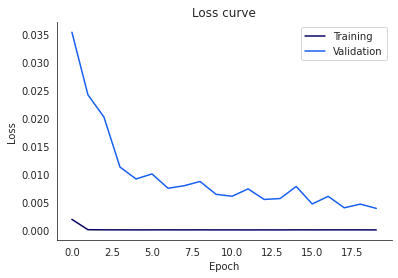

1/1 [==============================] - 0s 15ms/step


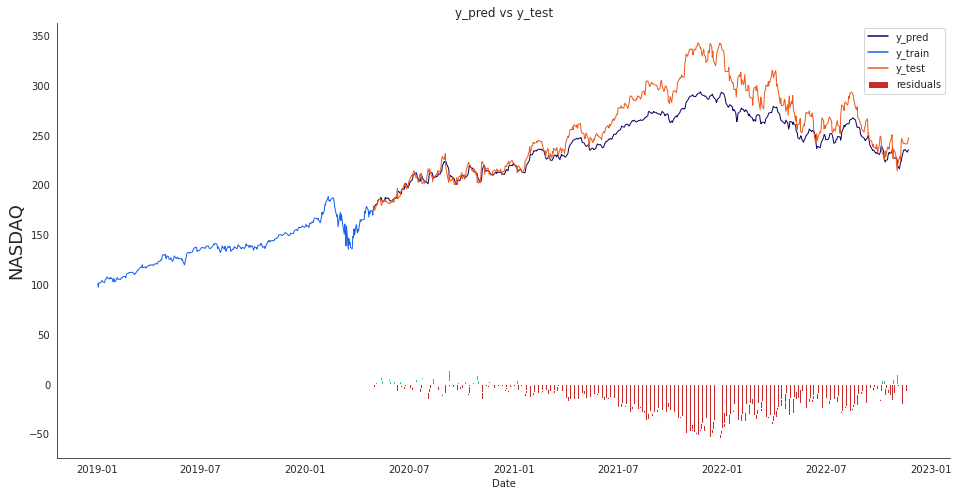

sequence_length 4
Epoch 1/20
325/325 [==============================] - 5s 10ms/step - loss: 6.5646e-04 - val_loss: 0.0145
Epoch 2/20
325/325 [==============================] - 3s 9ms/step - loss: 7.3734e-05 - val_loss: 0.0095
Epoch 3/20
325/325 [==============================] - 3s 9ms/step - loss: 7.1248e-05 - val_loss: 0.0095
Epoch 4/20
325/325 [==============================] - 3s 9ms/step - loss: 5.5318e-05 - val_loss: 0.0036
Epoch 5/20
325/325 [==============================] - 3s 9ms/step - loss: 5.4703e-05 - val_loss: 0.0071
Epoch 6/20
325/325 [==============================] - 3s 9ms/step - loss: 5.0471e-05 - val_loss: 0.0061
Epoch 7/20
325/325 [==============================] - 3s 9ms/step - loss: 6.3323e-05 - val_loss: 0.0040
Epoch 8/20
325/325 [==============================] - 3s 10ms/step - loss: 4.6409e-05 - val_loss: 0.0062
Epoch 9/20
325/325 [==============================] - 3s 9ms/step - loss: 5.1388e-05 - val_loss: 0.0052
Epoch 10/20
325/325 [=======================

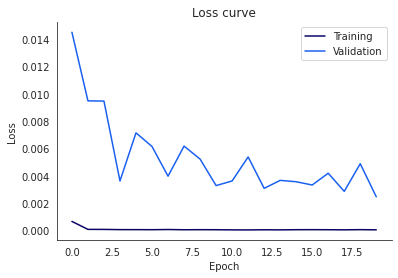

1/1 [==============================] - 0s 18ms/step


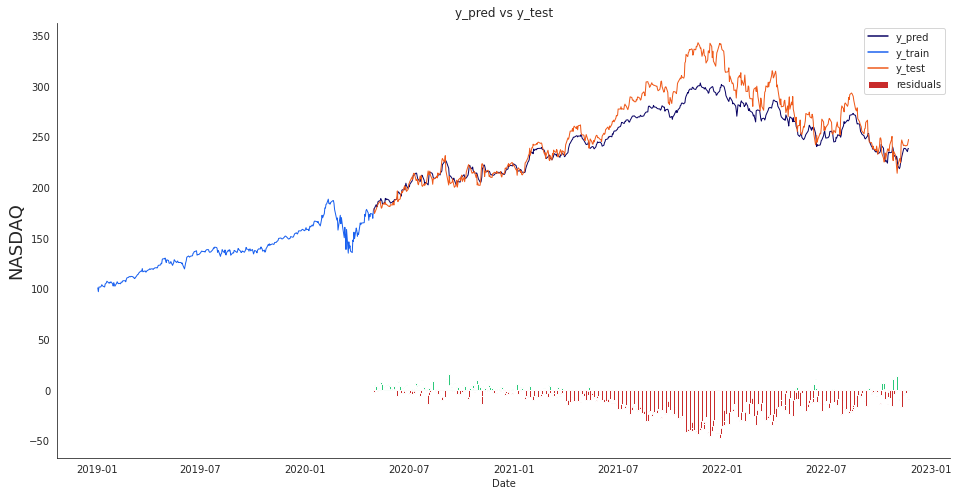

sequence_length 20
Epoch 1/20
325/325 [==============================] - 5s 11ms/step - loss: 0.0022 - val_loss: 0.0208
Epoch 2/20
325/325 [==============================] - 3s 10ms/step - loss: 6.3312e-05 - val_loss: 0.0189
Epoch 3/20
325/325 [==============================] - 3s 10ms/step - loss: 5.6335e-05 - val_loss: 0.0190
Epoch 4/20
325/325 [==============================] - 3s 9ms/step - loss: 6.0840e-05 - val_loss: 0.0120
Epoch 5/20
325/325 [==============================] - 3s 9ms/step - loss: 5.4231e-05 - val_loss: 0.0115
Epoch 6/20
325/325 [==============================] - 3s 9ms/step - loss: 6.2209e-05 - val_loss: 0.0109
Epoch 7/20
325/325 [==============================] - 3s 9ms/step - loss: 5.7890e-05 - val_loss: 0.0100
Epoch 8/20
325/325 [==============================] - 3s 10ms/step - loss: 5.9575e-05 - val_loss: 0.0098
Epoch 9/20
325/325 [==============================] - 3s 9ms/step - loss: 5.7915e-05 - val_loss: 0.0103
Epoch 10/20
325/325 [========================

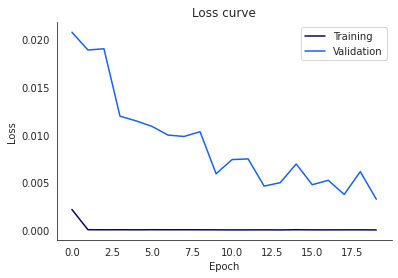

1/1 [==============================] - 0s 15ms/step


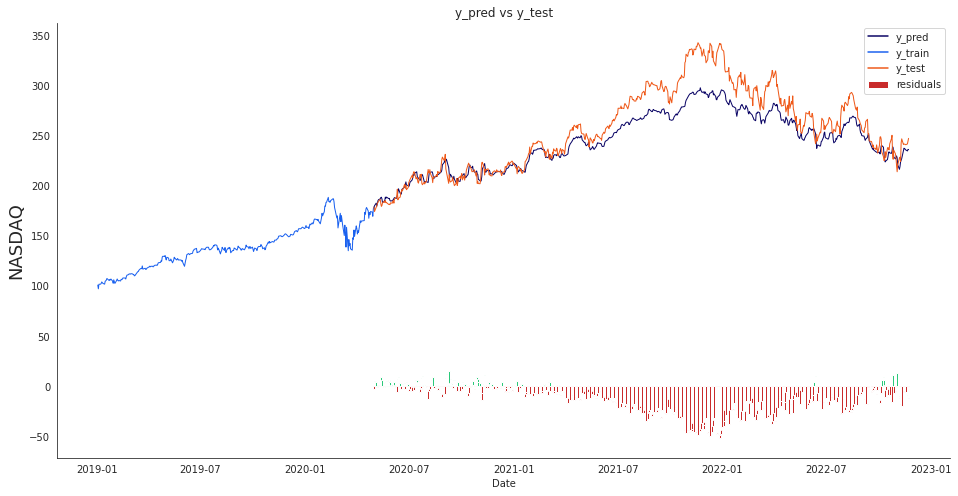

sequence_length 40
Epoch 1/20
325/325 [==============================] - 5s 11ms/step - loss: 0.0073 - val_loss: 0.0608
Epoch 2/20
325/325 [==============================] - 3s 10ms/step - loss: 1.2256e-04 - val_loss: 0.0376
Epoch 3/20
325/325 [==============================] - 3s 10ms/step - loss: 7.7055e-05 - val_loss: 0.0297
Epoch 4/20
325/325 [==============================] - 3s 10ms/step - loss: 6.0286e-05 - val_loss: 0.0172
Epoch 5/20
325/325 [==============================] - 3s 10ms/step - loss: 4.9132e-05 - val_loss: 0.0152
Epoch 6/20
325/325 [==============================] - 3s 10ms/step - loss: 4.5657e-05 - val_loss: 0.0119
Epoch 7/20
325/325 [==============================] - 3s 10ms/step - loss: 4.3821e-05 - val_loss: 0.0082
Epoch 8/20
325/325 [==============================] - 3s 10ms/step - loss: 4.3051e-05 - val_loss: 0.0075
Epoch 9/20
325/325 [==============================] - 3s 10ms/step - loss: 4.4131e-05 - val_loss: 0.0107
Epoch 10/20
325/325 [===================

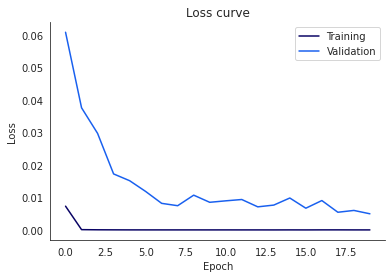

1/1 [==============================] - 0s 16ms/step


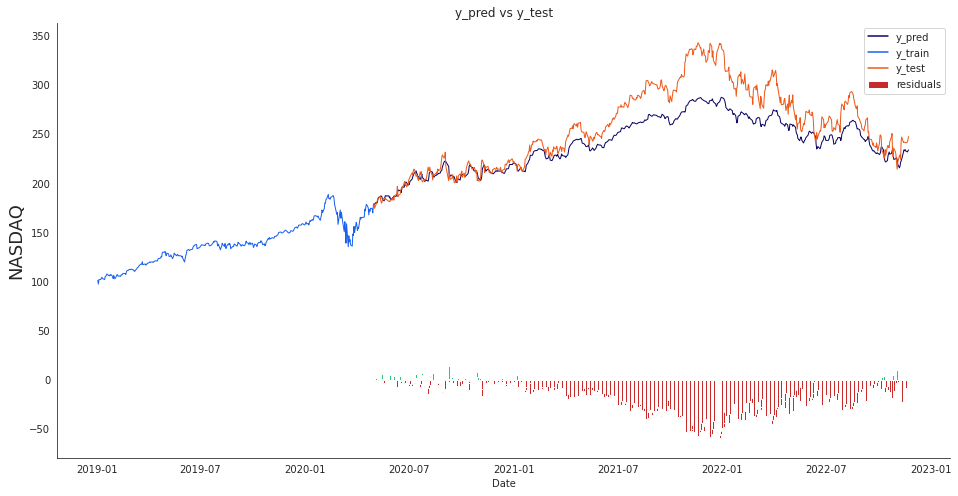

sequence_length 80
Epoch 1/20
325/325 [==============================] - 5s 11ms/step - loss: 1.4940e-04 - val_loss: 0.0127
Epoch 2/20
325/325 [==============================] - 3s 10ms/step - loss: 5.4411e-05 - val_loss: 0.0130
Epoch 3/20
325/325 [==============================] - 3s 9ms/step - loss: 5.7305e-05 - val_loss: 0.0151
Epoch 4/20
325/325 [==============================] - 3s 9ms/step - loss: 4.6433e-05 - val_loss: 0.0092
Epoch 5/20
325/325 [==============================] - 3s 10ms/step - loss: 4.6430e-05 - val_loss: 0.0138
Epoch 6/20
325/325 [==============================] - 3s 9ms/step - loss: 4.3219e-05 - val_loss: 0.0135
Epoch 7/20
325/325 [==============================] - 3s 9ms/step - loss: 5.1687e-05 - val_loss: 0.0100
Epoch 8/20
325/325 [==============================] - 3s 10ms/step - loss: 4.4075e-05 - val_loss: 0.0121
Epoch 9/20
325/325 [==============================] - 3s 10ms/step - loss: 4.7649e-05 - val_loss: 0.0112
Epoch 10/20
325/325 [===================

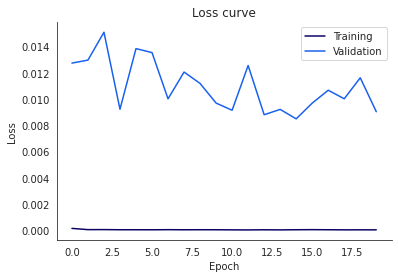

1/1 [==============================] - 0s 14ms/step


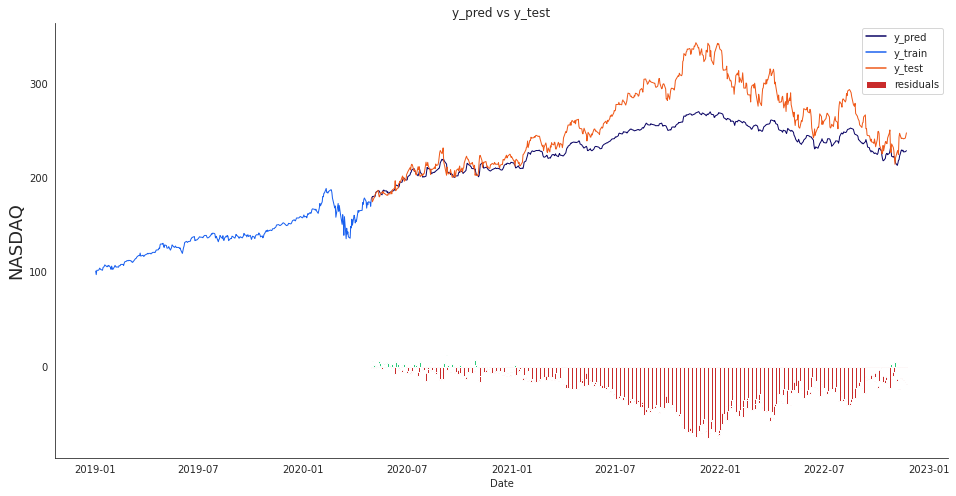

sequence_length 100
Epoch 1/20
325/325 [==============================] - 5s 11ms/step - loss: 7.4529e-04 - val_loss: 0.0176
Epoch 2/20
325/325 [==============================] - 3s 9ms/step - loss: 5.5115e-05 - val_loss: 0.0070
Epoch 3/20
325/325 [==============================] - 3s 9ms/step - loss: 4.0513e-05 - val_loss: 0.0078
Epoch 4/20
325/325 [==============================] - 3s 10ms/step - loss: 4.8458e-05 - val_loss: 0.0055
Epoch 5/20
325/325 [==============================] - 3s 10ms/step - loss: 4.5451e-05 - val_loss: 0.0122
Epoch 6/20
325/325 [==============================] - 3s 9ms/step - loss: 4.7319e-05 - val_loss: 0.0115
Epoch 7/20
325/325 [==============================] - 3s 9ms/step - loss: 4.1146e-05 - val_loss: 0.0076
Epoch 8/20
325/325 [==============================] - 3s 10ms/step - loss: 3.9682e-05 - val_loss: 0.0085
Epoch 9/20
325/325 [==============================] - 3s 10ms/step - loss: 4.3492e-05 - val_loss: 0.0077
Epoch 10/20
325/325 [==================

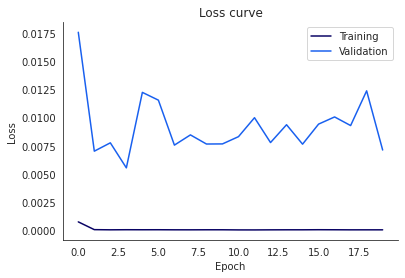

1/1 [==============================] - 0s 19ms/step


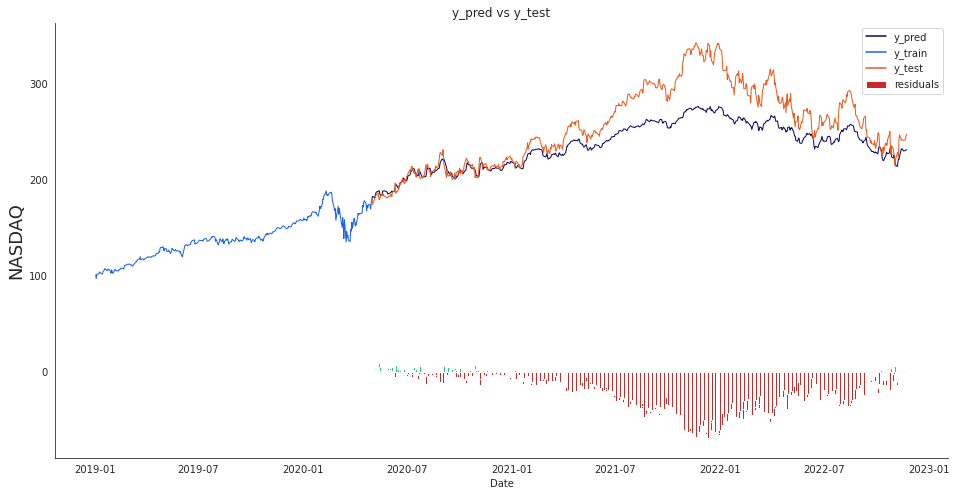

sequence_length 120
Epoch 1/20
325/325 [==============================] - 6s 12ms/step - loss: 0.0030 - val_loss: 0.0152
Epoch 2/20
325/325 [==============================] - 4s 12ms/step - loss: 9.4033e-05 - val_loss: 0.0080
Epoch 3/20
325/325 [==============================] - 3s 10ms/step - loss: 6.6149e-05 - val_loss: 0.0057
Epoch 4/20
325/325 [==============================] - 3s 10ms/step - loss: 5.6015e-05 - val_loss: 0.0013
Epoch 5/20
325/325 [==============================] - 3s 10ms/step - loss: 4.5923e-05 - val_loss: 0.0030
Epoch 6/20
325/325 [==============================] - 3s 10ms/step - loss: 5.5823e-05 - val_loss: 0.0038
Epoch 7/20
325/325 [==============================] - 3s 10ms/step - loss: 5.5038e-05 - val_loss: 9.0296e-04
Epoch 8/20
325/325 [==============================] - 3s 10ms/step - loss: 4.8745e-05 - val_loss: 5.5164e-04
Epoch 9/20
325/325 [==============================] - 3s 10ms/step - loss: 5.4751e-05 - val_loss: 0.0010
Epoch 10/20
325/325 [==========

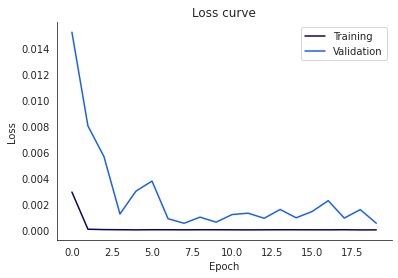

1/1 [==============================] - 0s 24ms/step


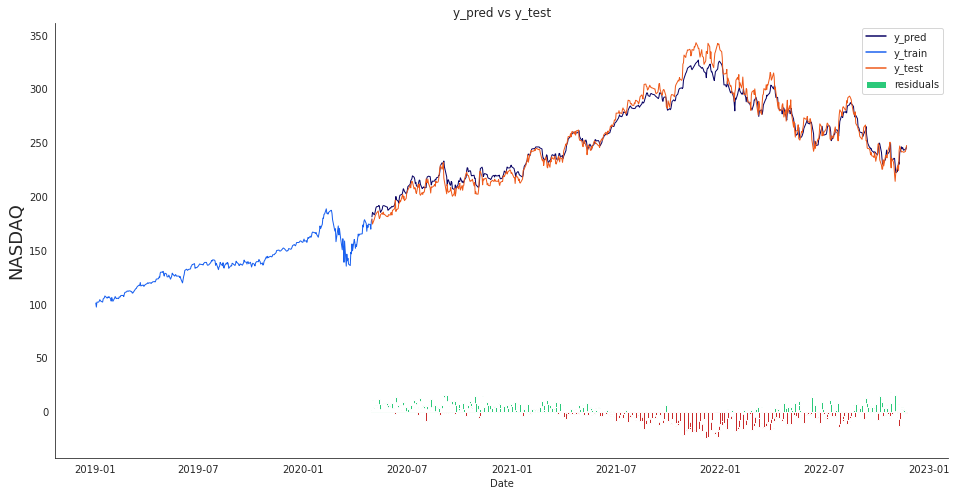

In [ ]:
#Experiment for sequence length
random_seed()

end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'
stockname = 'NASDAQ'
symbol = 'MSFT'
model_name = 'SimpleRNN'
epochs = 20
batch_size = 8
learning_rate = 0.001
number_of_layer = 1

loss_func = tf.keras.losses.MeanSquaredError()
sequence_lengths = [2, 4, 20, 40, 80, 100, 120]
features = ['High', 'Low', 'Open', 'Close', 'Volume']
# features = ['High', 'Low', 'Open', 'Close']

# Train simpleRNN model
input_data_df = get_data(symbol, start_date, end_date)
results_simpleRNN_sl = []
for sl in sequence_lengths:
  print('sequence_length', sl)
  optimizer = tf.keras.optimizers.Adam(learning_rate)
  result = train_networks(input_data_df, features, model_name, epochs, batch_size, optimizer,loss_func, sequence_length, number_of_layer)
  result['sequence_length'] = sl
  results_simpleRNN_sl.append(result)


###Result

In [ ]:
results_simpleRNN_sl
result_df_simpleRNN_sl = pd.DataFrame(results_simpleRNN_sl)
result_df_simpleRNN_sl.sort_values(by=["mse"])

epochs  batch_size  sequence_length        mae      mape     mdape  \
6      20           8              120   5.978067  2.306687  1.921252   
1      20           8                4  11.727673  4.144180  3.489933   
2      20           8               20  13.664136  4.819780  4.147665   
0      20           8                2  15.083878  5.310629  4.449394   
3      20           8               40  17.289464  6.091734  5.298718   
5      20           8              100  20.570351  7.222000  6.226948   
4      20           8               80  23.639231  8.332675  7.635330   

          mse  test_prediction_difference  training_time  number_of_layers  
6   56.985249                    0.069994      71.733276                 1  
1  251.905496                    8.219999      65.725265                 1  
2  334.108724                    9.680006      86.315188                 1  
0  397.940211                   10.759993      86.064621                 1  
3  511.588738                   12.460005      85.812336                 1  
5  729.707853                   14.490004      85.894587                 1  
4  925.909257                   18.160002      86.255252                 1

#Experiment for GRU

##Experiment for learning rates

###Experiment

[*********************100%***********************]  1 of 1 completed
learning rate 0.1
Epoch 1/20
163/163 [==============================] - 4s 9ms/step - loss: 0.0170 - val_loss: 0.0384
Epoch 2/20
163/163 [==============================] - 1s 5ms/step - loss: 7.1430e-05 - val_loss: 0.0298
Epoch 3/20
163/163 [==============================] - 1s 5ms/step - loss: 7.2526e-05 - val_loss: 0.0347
Epoch 4/20
163/163 [==============================] - 1s 5ms/step - loss: 8.1505e-05 - val_loss: 0.0110
Epoch 5/20
163/163 [==============================] - 1s 5ms/step - loss: 6.7072e-05 - val_loss: 0.0203
Epoch 6/20
163/163 [==============================] - 1s 5ms/step - loss: 6.3556e-05 - val_loss: 0.0319
Epoch 7/20
163/163 [==============================] - 1s 5ms/step - loss: 1.8512e-04 - val_loss: 0.0227
Epoch 8/20
163/163 [==============================] - 1s 5ms/step - loss: 6.8550e-05 - val_loss: 0.0254
Epoch 9/20
163/163 [==============================] - 1s 5ms/step - loss: 1.1426e-04 

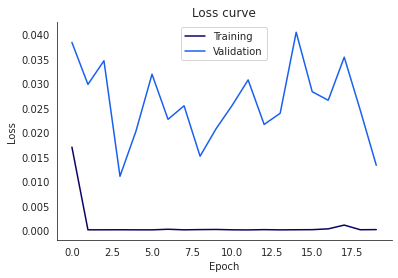

1/1 [==============================] - 0s 19ms/step


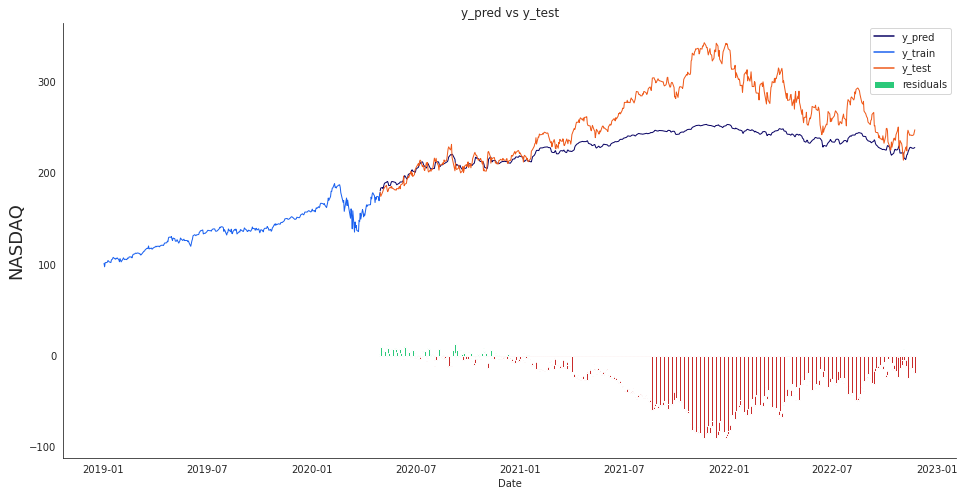

learning rate 0.001
Epoch 1/20
163/163 [==============================] - 4s 11ms/step - loss: 0.0050 - val_loss: 0.0015
Epoch 2/20
163/163 [==============================] - 1s 5ms/step - loss: 8.2490e-05 - val_loss: 0.0023
Epoch 3/20
163/163 [==============================] - 1s 5ms/step - loss: 4.6404e-05 - val_loss: 8.9087e-04
Epoch 4/20
163/163 [==============================] - 1s 5ms/step - loss: 3.5468e-05 - val_loss: 7.6299e-04
Epoch 5/20
163/163 [==============================] - 1s 5ms/step - loss: 2.9409e-05 - val_loss: 5.4704e-04
Epoch 6/20
163/163 [==============================] - 1s 5ms/step - loss: 2.7237e-05 - val_loss: 9.3933e-04
Epoch 7/20
163/163 [==============================] - 1s 5ms/step - loss: 2.7159e-05 - val_loss: 7.4992e-04
Epoch 8/20
163/163 [==============================] - 1s 5ms/step - loss: 2.3625e-05 - val_loss: 0.0015
Epoch 9/20
163/163 [==============================] - 1s 5ms/step - loss: 2.3418e-05 - val_loss: 0.0020
Epoch 10/20
163/163 [======

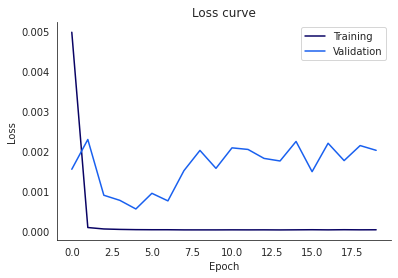

1/1 [==============================] - 0s 16ms/step


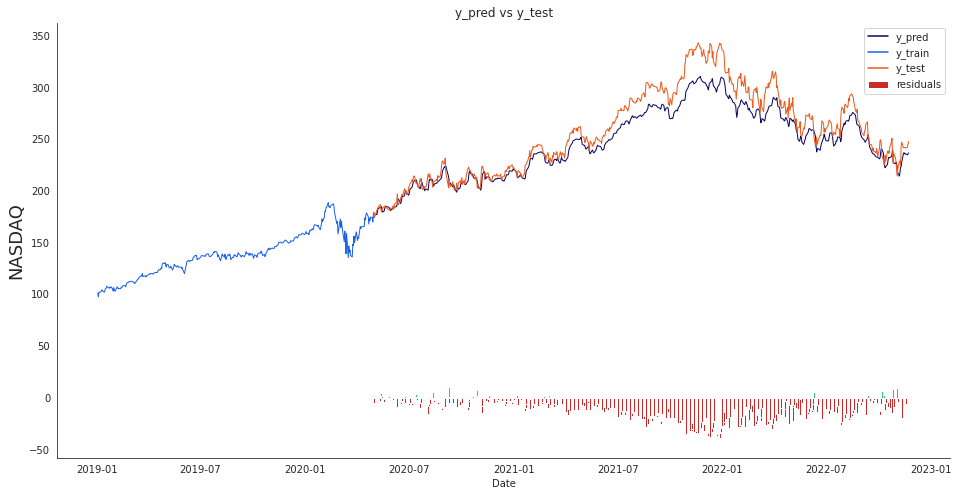

learning rate 0.0001
Epoch 1/20
163/163 [==============================] - 4s 9ms/step - loss: 0.0013 - val_loss: 0.0294
Epoch 2/20
163/163 [==============================] - 1s 5ms/step - loss: 1.8262e-04 - val_loss: 0.0152
Epoch 3/20
163/163 [==============================] - 1s 5ms/step - loss: 1.0667e-04 - val_loss: 0.0130
Epoch 4/20
163/163 [==============================] - 1s 5ms/step - loss: 7.6143e-05 - val_loss: 0.0108
Epoch 5/20
163/163 [==============================] - 1s 5ms/step - loss: 5.5673e-05 - val_loss: 0.0100
Epoch 6/20
163/163 [==============================] - 1s 5ms/step - loss: 4.2314e-05 - val_loss: 0.0098
Epoch 7/20
163/163 [==============================] - 1s 5ms/step - loss: 3.4805e-05 - val_loss: 0.0090
Epoch 8/20
163/163 [==============================] - 1s 5ms/step - loss: 2.9210e-05 - val_loss: 0.0090
Epoch 9/20
163/163 [==============================] - 1s 5ms/step - loss: 2.6713e-05 - val_loss: 0.0083
Epoch 10/20
163/163 [==========================

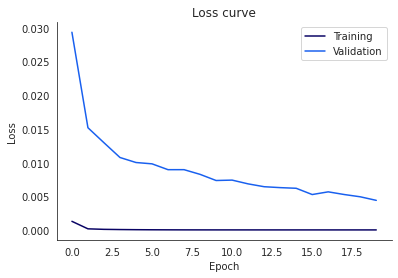

1/1 [==============================] - 0s 17ms/step


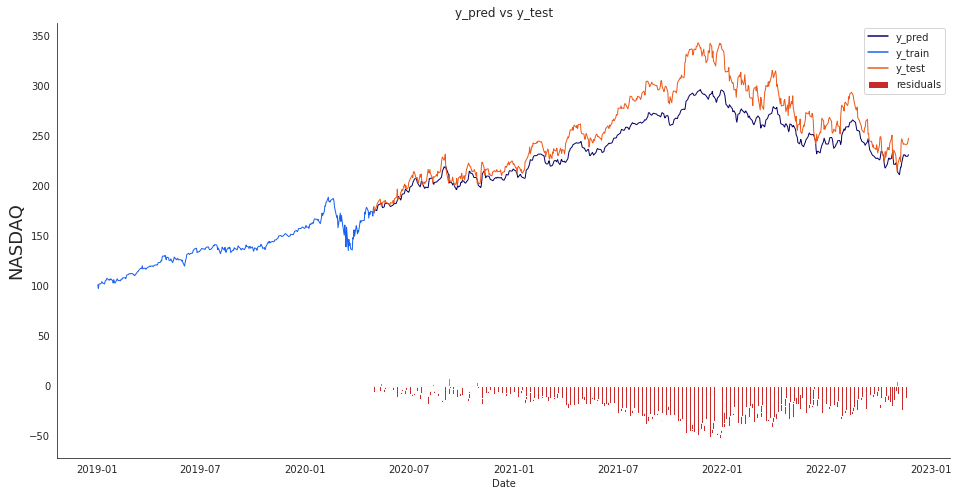

learning rate 1e-05
Epoch 1/20
163/163 [==============================] - 4s 9ms/step - loss: 0.0292 - val_loss: 0.5888
Epoch 2/20
163/163 [==============================] - 1s 5ms/step - loss: 0.0256 - val_loss: 0.5544
Epoch 3/20
163/163 [==============================] - 1s 5ms/step - loss: 0.0226 - val_loss: 0.5225
Epoch 4/20
163/163 [==============================] - 1s 6ms/step - loss: 0.0201 - val_loss: 0.4932
Epoch 5/20
163/163 [==============================] - 1s 5ms/step - loss: 0.0181 - val_loss: 0.4654
Epoch 6/20
163/163 [==============================] - 1s 5ms/step - loss: 0.0165 - val_loss: 0.4398
Epoch 7/20
163/163 [==============================] - 1s 5ms/step - loss: 0.0151 - val_loss: 0.4159
Epoch 8/20
163/163 [==============================] - 1s 5ms/step - loss: 0.0141 - val_loss: 0.3940
Epoch 9/20
163/163 [==============================] - 1s 5ms/step - loss: 0.0133 - val_loss: 0.3739
Epoch 10/20
163/163 [==============================] - 1s 6ms/step - loss: 0.012

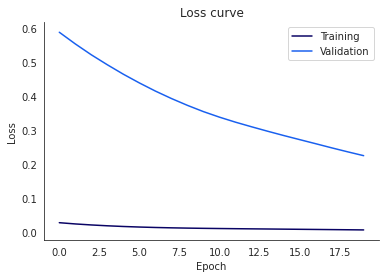

1/1 [==============================] - 0s 17ms/step


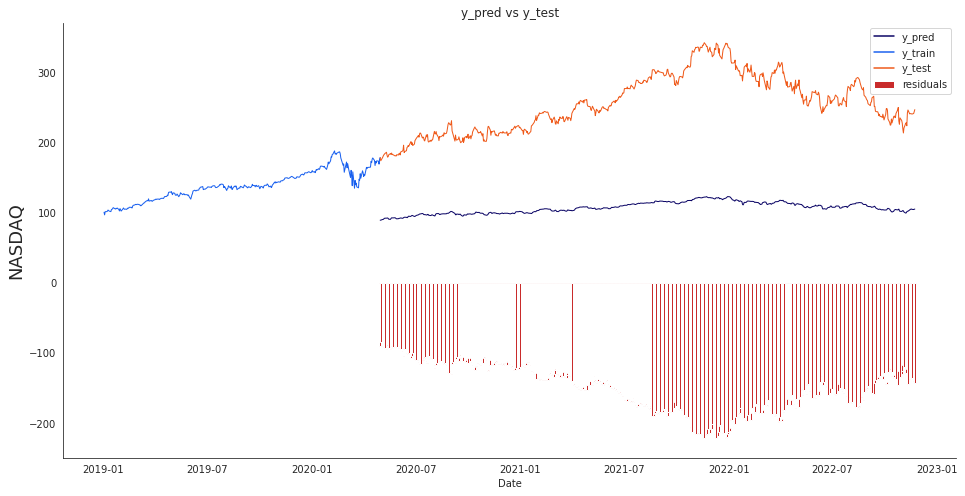

[{'epochs': 20, 'batch_size': 16, 'sequence_length': 2, 'mae': 27.83165243704255, 'mape': 9.72729126686025, 'mdape': 8.47953145210152, 'mse': 1359.80993109925, 'test_prediction_difference': 18.460004882812513, 'training_time': 22.929961, 'number_of_layers': 0, 'learning_rate': 0.1}, {'epochs': 20, 'batch_size': 16, 'sequence_length': 2, 'mae': 11.349652118418344, 'mape': 4.080339428111074, 'mdape': 3.7325285090311966, 'mse': 206.52697288592483, 'test_prediction_difference': 9.559995727539075, 'training_time': 22.870038, 'number_of_layers': 0, 'learning_rate': 0.001}, {'epochs': 20, 'batch_size': 16, 'sequence_length': 2, 'mae': 17.535937387146074, 'mape': 6.331593681352099, 'mdape': 6.041657717672752, 'mse': 451.64685991414774, 'test_prediction_difference': 14.919996337890638, 'training_time': 26.278577, 'number_of_layers': 0, 'learning_rate': 0.0001}, {'epochs': 20, 'batch_size': 16, 'sequence_length': 2, 'mae': 148.5293694541708, 'mape': 57.413917898727206, 'mdape': 57.62998491157063

In [ ]:
#Experiment for learning rates
random_seed()
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'
stockname = 'NASDAQ'
symbol = 'MSFT'
model_name = 'GRU'
epochs = 20
batch_size = 16
learning_rates = [0.1, 0.001, 0.0001, 0.00001]
number_of_layer = 0

loss_func = tf.keras.losses.MeanSquaredError()
sequence_length = 2
features = ['High', 'Low', 'Open', 'Close', 'Volume']
# features = ['High', 'Low', 'Open', 'Close']

# Train LSTM model
input_data_df = get_data(symbol, start_date, end_date)
results_gru_lr = []
for lr in learning_rates:
  print('learning rate', lr)
  optimizer = tf.keras.optimizers.Adam(lr)
  
  result = train_networks(input_data_df, features, model_name, epochs, batch_size, optimizer,loss_func, sequence_length, number_of_layer)

  result['learning_rate'] = lr  
  results_gru_lr.append(result)
print(results_gru_lr)



###Result

In [ ]:
results_gru_lr
result_df_gru_lr = pd.DataFrame(results_gru_lr)
result_df_gru_lr.sort_values(by=["mse"])

epochs  batch_size  sequence_length         mae       mape      mdape  \
1      20          16                2   11.349652   4.080339   3.732529   
2      20          16                2   17.535937   6.331594   6.041658   
0      20          16                2   27.831652   9.727291   8.479531   
3      20          16                2  148.529369  57.413918  57.629985   

            mse  test_prediction_difference  training_time  number_of_layers  \
1    206.526973                    9.559996      22.870038                 0   
2    451.646860                   14.919996      26.278577                 0   
0   1359.809931                   18.460005      22.929961                 0   
3  23168.749125                  141.599997      26.039526                 0   

   learning_rate  
1        0.00100  
2        0.00010  
0        0.10000  
3        0.00001

##Experiment for batch sizes

###Experiment

[*********************100%***********************]  1 of 1 completed
batch_size 2
Epoch 1/20
163/163 [==============================] - 4s 9ms/step - loss: 0.0027 - val_loss: 0.0010
Epoch 2/20
163/163 [==============================] - 1s 5ms/step - loss: 2.6987e-05 - val_loss: 0.0010
Epoch 3/20
163/163 [==============================] - 1s 5ms/step - loss: 2.4799e-05 - val_loss: 0.0014
Epoch 4/20
163/163 [==============================] - 1s 5ms/step - loss: 2.2776e-05 - val_loss: 8.6954e-04
Epoch 5/20
163/163 [==============================] - 1s 5ms/step - loss: 2.3134e-05 - val_loss: 0.0019
Epoch 6/20
163/163 [==============================] - 1s 5ms/step - loss: 2.5177e-05 - val_loss: 0.0024
Epoch 7/20
163/163 [==============================] - 1s 6ms/step - loss: 2.8099e-05 - val_loss: 0.0014
Epoch 8/20
163/163 [==============================] - 1s 7ms/step - loss: 2.4893e-05 - val_loss: 0.0020
Epoch 9/20
163/163 [==============================] - 1s 6ms/step - loss: 2.6333e-05 -

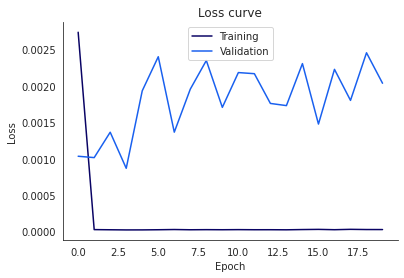

1/1 [==============================] - 0s 17ms/step


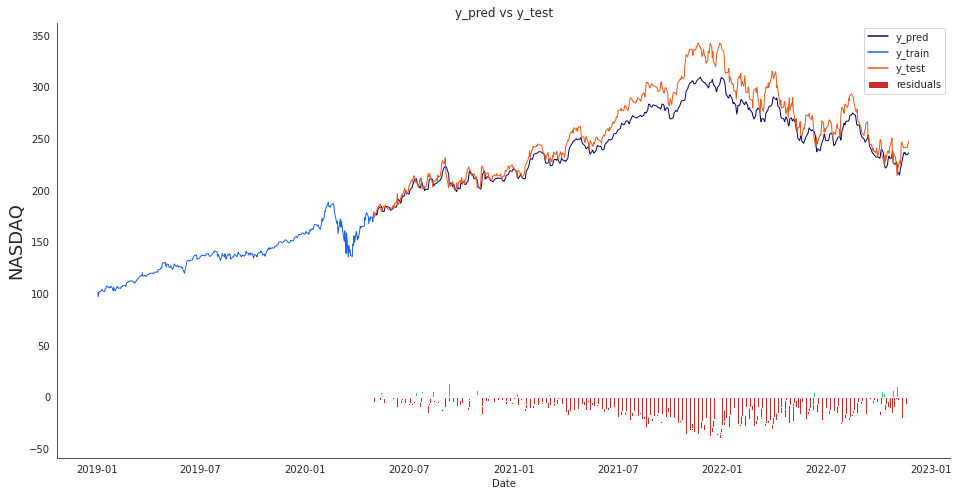

batch_size 8
Epoch 1/20
163/163 [==============================] - 4s 9ms/step - loss: 0.0050 - val_loss: 0.0015
Epoch 2/20
163/163 [==============================] - 1s 5ms/step - loss: 8.2490e-05 - val_loss: 0.0023
Epoch 3/20
163/163 [==============================] - 1s 5ms/step - loss: 4.6404e-05 - val_loss: 8.9087e-04
Epoch 4/20
163/163 [==============================] - 1s 5ms/step - loss: 3.5468e-05 - val_loss: 7.6299e-04
Epoch 5/20
163/163 [==============================] - 1s 5ms/step - loss: 2.9409e-05 - val_loss: 5.4704e-04
Epoch 6/20
163/163 [==============================] - 1s 5ms/step - loss: 2.7237e-05 - val_loss: 9.3933e-04
Epoch 7/20
163/163 [==============================] - 1s 5ms/step - loss: 2.7159e-05 - val_loss: 7.4992e-04
Epoch 8/20
163/163 [==============================] - 1s 5ms/step - loss: 2.3625e-05 - val_loss: 0.0015
Epoch 9/20
163/163 [==============================] - 1s 5ms/step - loss: 2.3418e-05 - val_loss: 0.0020
Epoch 10/20
163/163 [==============

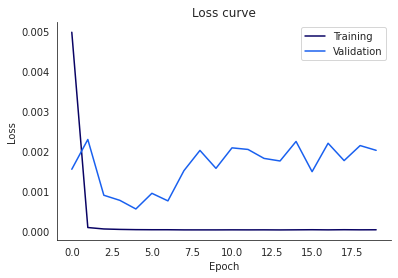

1/1 [==============================] - 0s 16ms/step


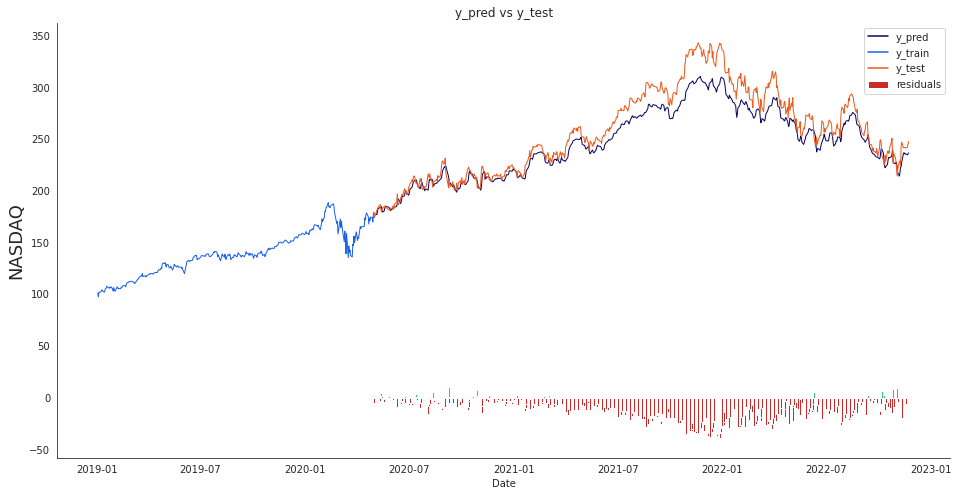

batch_size 16
Epoch 1/20
163/163 [==============================] - 4s 9ms/step - loss: 2.7024e-04 - val_loss: 0.0082
Epoch 2/20
163/163 [==============================] - 1s 6ms/step - loss: 2.5022e-05 - val_loss: 0.0058
Epoch 3/20
163/163 [==============================] - 1s 6ms/step - loss: 2.3547e-05 - val_loss: 0.0046
Epoch 4/20
163/163 [==============================] - 1s 6ms/step - loss: 2.5197e-05 - val_loss: 0.0026
Epoch 5/20
163/163 [==============================] - 1s 5ms/step - loss: 2.3879e-05 - val_loss: 0.0037
Epoch 6/20
163/163 [==============================] - 1s 5ms/step - loss: 2.5306e-05 - val_loss: 0.0045
Epoch 7/20
163/163 [==============================] - 1s 5ms/step - loss: 3.1802e-05 - val_loss: 0.0031
Epoch 8/20
163/163 [==============================] - 1s 5ms/step - loss: 2.5572e-05 - val_loss: 0.0026
Epoch 9/20
163/163 [==============================] - 1s 5ms/step - loss: 2.6747e-05 - val_loss: 0.0034
Epoch 10/20
163/163 [=============================

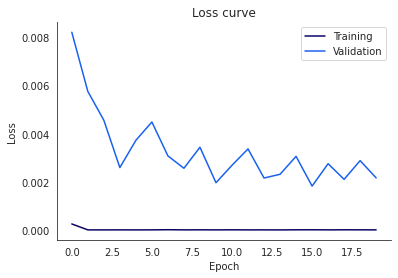

1/1 [==============================] - 0s 14ms/step


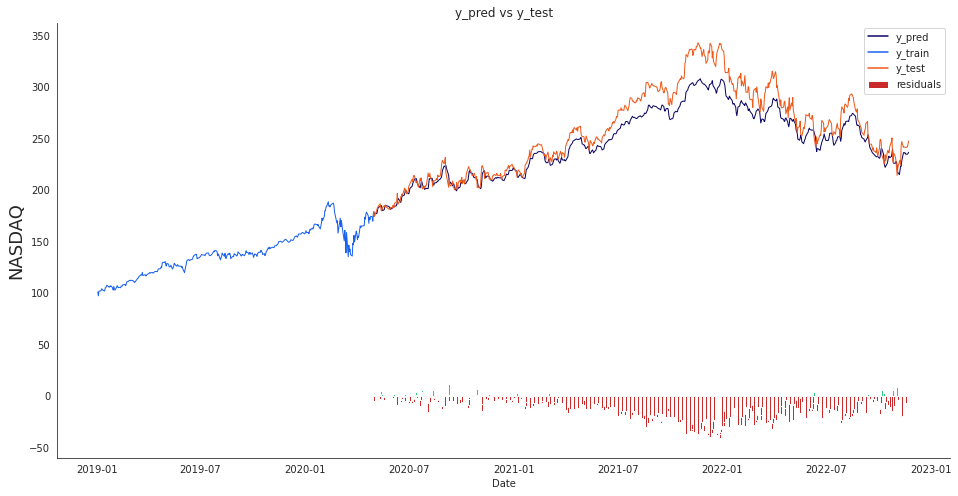

batch_size 32
Epoch 1/20
163/163 [==============================] - 5s 11ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 2/20
163/163 [==============================] - 1s 6ms/step - loss: 3.0138e-05 - val_loss: 0.0022
Epoch 3/20
163/163 [==============================] - 1s 5ms/step - loss: 2.4066e-05 - val_loss: 0.0023
Epoch 4/20
163/163 [==============================] - 1s 6ms/step - loss: 2.2719e-05 - val_loss: 0.0015
Epoch 5/20
163/163 [==============================] - 1s 6ms/step - loss: 2.3113e-05 - val_loss: 0.0025
Epoch 6/20
163/163 [==============================] - 1s 6ms/step - loss: 2.4783e-05 - val_loss: 0.0032
Epoch 7/20
163/163 [==============================] - 1s 6ms/step - loss: 2.8333e-05 - val_loss: 0.0018
Epoch 8/20
163/163 [==============================] - 1s 6ms/step - loss: 2.5019e-05 - val_loss: 0.0024
Epoch 9/20
163/163 [==============================] - 1s 6ms/step - loss: 2.6358e-05 - val_loss: 0.0028
Epoch 10/20
163/163 [==============================] 

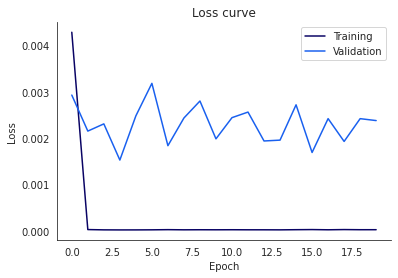

1/1 [==============================] - 0s 14ms/step


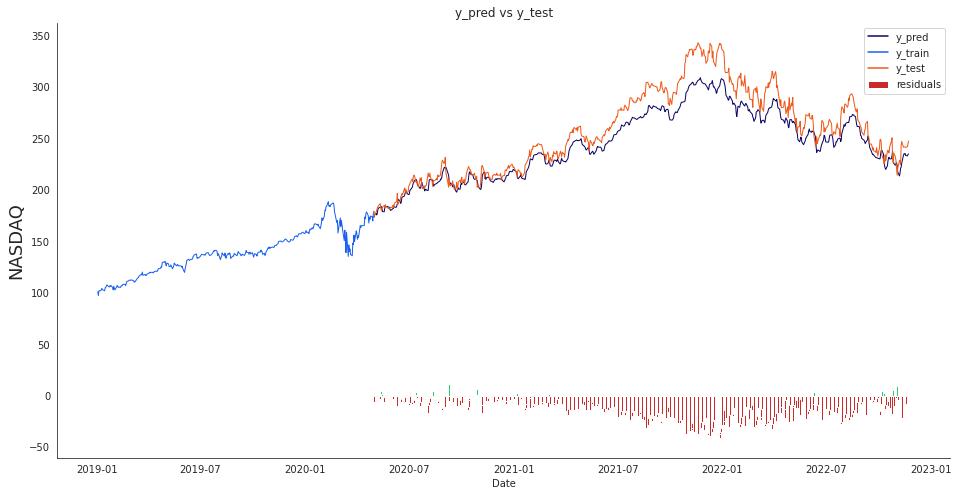

batch_size 64
Epoch 1/20
163/163 [==============================] - 4s 9ms/step - loss: 0.0014 - val_loss: 0.0065
Epoch 2/20
163/163 [==============================] - 1s 6ms/step - loss: 3.6418e-05 - val_loss: 0.0035
Epoch 3/20
163/163 [==============================] - 1s 5ms/step - loss: 2.4189e-05 - val_loss: 0.0035
Epoch 4/20
163/163 [==============================] - 1s 6ms/step - loss: 2.2763e-05 - val_loss: 0.0018
Epoch 5/20
163/163 [==============================] - 1s 5ms/step - loss: 2.3319e-05 - val_loss: 0.0028
Epoch 6/20
163/163 [==============================] - 1s 5ms/step - loss: 2.5164e-05 - val_loss: 0.0035
Epoch 7/20
163/163 [==============================] - 1s 5ms/step - loss: 2.8430e-05 - val_loss: 0.0017
Epoch 8/20
163/163 [==============================] - 1s 6ms/step - loss: 2.5367e-05 - val_loss: 0.0023
Epoch 9/20
163/163 [==============================] - 1s 5ms/step - loss: 2.6250e-05 - val_loss: 0.0026
Epoch 10/20
163/163 [==============================] -

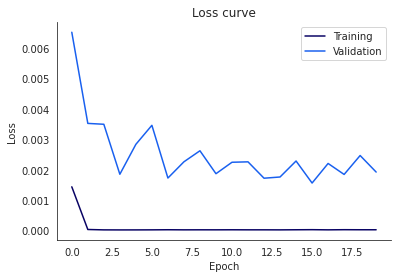

1/1 [==============================] - 0s 14ms/step


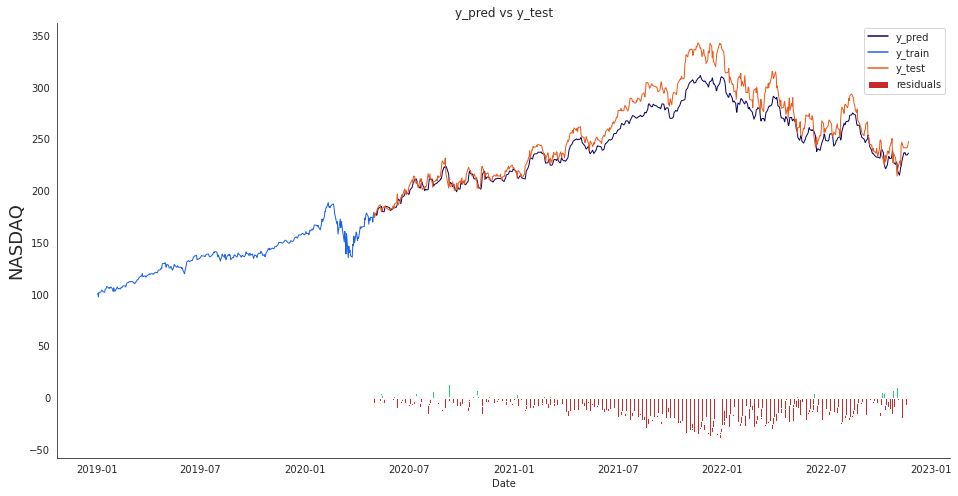

batch_size 128
Epoch 1/20
163/163 [==============================] - 4s 9ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 2/20
163/163 [==============================] - 1s 5ms/step - loss: 2.9623e-05 - val_loss: 6.6991e-04
Epoch 3/20
163/163 [==============================] - 1s 5ms/step - loss: 2.2276e-05 - val_loss: 8.2835e-04
Epoch 4/20
163/163 [==============================] - 1s 5ms/step - loss: 2.0732e-05 - val_loss: 4.9682e-04
Epoch 5/20
163/163 [==============================] - 1s 6ms/step - loss: 2.1439e-05 - val_loss: 0.0011
Epoch 6/20
163/163 [==============================] - 1s 6ms/step - loss: 2.2563e-05 - val_loss: 0.0017
Epoch 7/20
163/163 [==============================] - 1s 5ms/step - loss: 2.7284e-05 - val_loss: 7.3840e-04
Epoch 8/20
163/163 [==============================] - 1s 6ms/step - loss: 2.3096e-05 - val_loss: 0.0011
Epoch 9/20
163/163 [==============================] - 1s 6ms/step - loss: 2.4333e-05 - val_loss: 0.0014
Epoch 10/20
163/163 [================

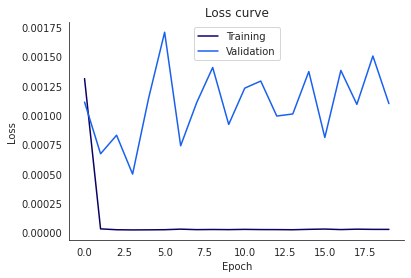

1/1 [==============================] - 0s 16ms/step


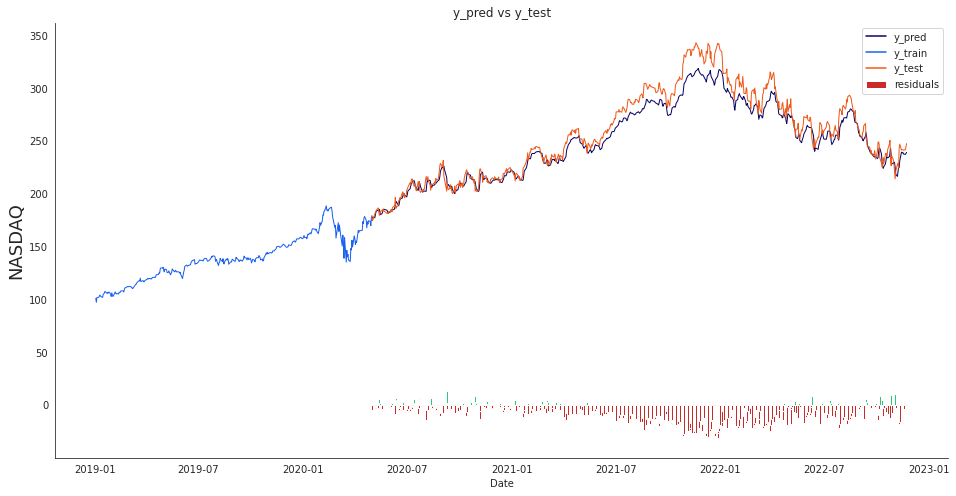

[{'epochs': 20, 'batch_size': 2, 'sequence_length': 2, 'mae': 11.433755812916791, 'mape': 4.117770410999425, 'mdape': 3.7385524604555465, 'mse': 208.8294050542785, 'test_prediction_difference': 9.60000427246095, 'training_time': 23.542719, 'number_of_layers': 0}, {'epochs': 20, 'batch_size': 8, 'sequence_length': 2, 'mae': 11.349652118418344, 'mape': 4.080339428111074, 'mdape': 3.7325285090311966, 'mse': 206.52697288592483, 'test_prediction_difference': 9.559995727539075, 'training_time': 23.063012, 'number_of_layers': 0}, {'epochs': 20, 'batch_size': 16, 'sequence_length': 2, 'mae': 11.720371052370218, 'mape': 4.197813668203483, 'mdape': 3.804706020089003, 'mse': 223.09970161273748, 'test_prediction_difference': 9.270002441406263, 'training_time': 24.051715, 'number_of_layers': 0}, {'epochs': 20, 'batch_size': 32, 'sequence_length': 2, 'mae': 12.602053626108962, 'mape': 4.552924548545375, 'mdape': 4.251707985573285, 'mse': 244.0575659530443, 'test_prediction_difference': 11.1900006103

In [ ]:
#Experiment for batch sizes
random_seed()
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'
stockname = 'NASDAQ'
symbol = 'MSFT'
model_name = 'GRU'
epochs = 20
batch_sizes = [2,8,16,32,64,128]
learning_rate = 0.001
number_of_layer = 0

loss_func = tf.keras.losses.MeanSquaredError()
sequence_length = 2
features = ['High', 'Low', 'Open', 'Close', 'Volume']
# features = ['High', 'Low', 'Open', 'Close']

# Train GRU model
input_data_df = get_data(symbol, start_date, end_date)
results_gru_bs = []
for bs in batch_sizes:
  print('batch_size', bs)
  optimizer = tf.keras.optimizers.Adam(learning_rate)
  result = train_networks(input_data_df, features, model_name, epochs, batch_size, optimizer,loss_func, sequence_length, number_of_layer)
  result['batch_size'] = bs
  results_gru_bs.append(result)
print(results_gru_bs)

###Result

In [ ]:
results_gru_bs
result_df_gru_bs = pd.DataFrame(results_gru_bs)
result_df_gru_bs.sort_values(by=["mse"])

epochs  batch_size  sequence_length        mae      mape     mdape  \
5      20         128                2   8.207087  2.970199  2.667273   
4      20          64                2  11.091100  3.996292  3.620589   
1      20           8                2  11.349652  4.080339  3.732529   
0      20           2                2  11.433756  4.117770  3.738552   
2      20          16                2  11.720371  4.197814  3.804706   
3      20          32                2  12.602054  4.552925  4.251708   

          mse  test_prediction_difference  training_time  number_of_layers  
5  112.486764                    6.449995      26.064476                 0  
4  196.877501                    9.740004      24.688103                 0  
1  206.526973                    9.559996      23.063012                 0  
0  208.829405                    9.600004      23.542719                 0  
2  223.099702                    9.270002      24.051715                 0  
3  244.057566                   11.190001      26.796761                 0

##Experiment for sequence lengths

###Experiment

[*********************100%***********************]  1 of 1 completed
sequence_length 2
Epoch 1/20
21/21 [==============================] - 4s 51ms/step - loss: 0.0120 - val_loss: 0.1558
Epoch 2/20
21/21 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0889
Epoch 3/20
21/21 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 4/20
21/21 [==============================] - 0s 6ms/step - loss: 1.2426e-04 - val_loss: 5.0392e-04
Epoch 5/20
21/21 [==============================] - 0s 6ms/step - loss: 7.2351e-05 - val_loss: 0.0015
Epoch 6/20
21/21 [==============================] - 0s 6ms/step - loss: 4.8442e-05 - val_loss: 0.0011
Epoch 7/20
21/21 [==============================] - 0s 6ms/step - loss: 3.6546e-05 - val_loss: 0.0010
Epoch 8/20
21/21 [==============================] - 0s 6ms/step - loss: 3.0069e-05 - val_loss: 0.0010
Epoch 9/20
21/21 [==============================] - 0s 6ms/step - loss: 2.6126e-05 - val_loss: 9.6135e-0

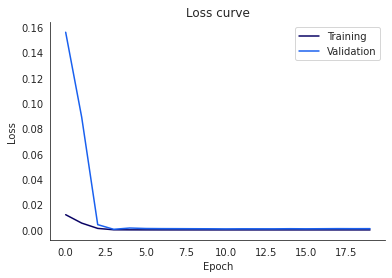

1/1 [==============================] - 0s 15ms/step


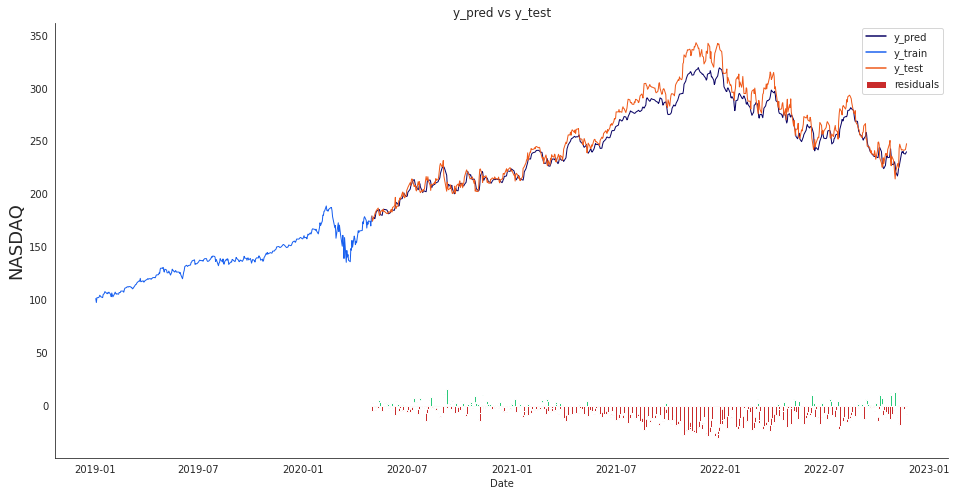

sequence_length 4
Epoch 1/20
21/21 [==============================] - 4s 37ms/step - loss: 0.0241 - val_loss: 0.1598
Epoch 2/20
21/21 [==============================] - 0s 6ms/step - loss: 0.0077 - val_loss: 0.0653
Epoch 3/20
21/21 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 4.4899e-04
Epoch 4/20
21/21 [==============================] - 0s 6ms/step - loss: 4.3289e-04 - val_loss: 0.0023
Epoch 5/20
21/21 [==============================] - 0s 6ms/step - loss: 3.1513e-04 - val_loss: 9.8639e-04
Epoch 6/20
21/21 [==============================] - 0s 6ms/step - loss: 2.1986e-04 - val_loss: 0.0011
Epoch 7/20
21/21 [==============================] - 0s 6ms/step - loss: 1.6199e-04 - val_loss: 0.0017
Epoch 8/20
21/21 [==============================] - 0s 6ms/step - loss: 1.2072e-04 - val_loss: 0.0019
Epoch 9/20
21/21 [==============================] - 0s 6ms/step - loss: 9.2684e-05 - val_loss: 0.0021
Epoch 10/20
21/21 [==============================] - 0s 6ms/step - 

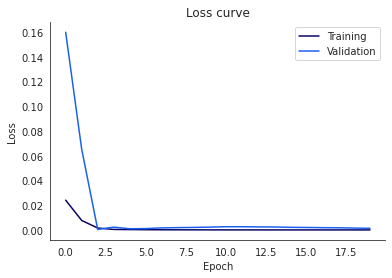

1/1 [==============================] - 0s 17ms/step


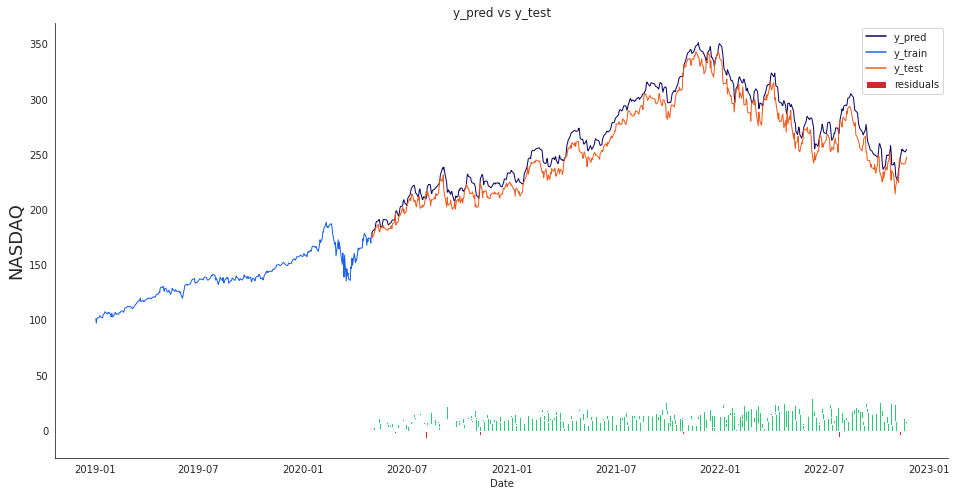

sequence_length 20
Epoch 1/20
21/21 [==============================] - 3s 37ms/step - loss: 0.0014 - val_loss: 0.0250
Epoch 2/20
21/21 [==============================] - 0s 7ms/step - loss: 2.1162e-04 - val_loss: 0.0104
Epoch 3/20
21/21 [==============================] - 0s 6ms/step - loss: 1.0798e-04 - val_loss: 0.0136
Epoch 4/20
21/21 [==============================] - 0s 6ms/step - loss: 7.3531e-05 - val_loss: 0.0102
Epoch 5/20
21/21 [==============================] - 0s 6ms/step - loss: 5.0734e-05 - val_loss: 0.0086
Epoch 6/20
21/21 [==============================] - 0s 7ms/step - loss: 3.7755e-05 - val_loss: 0.0084
Epoch 7/20
21/21 [==============================] - 0s 6ms/step - loss: 3.1751e-05 - val_loss: 0.0080
Epoch 8/20
21/21 [==============================] - 0s 6ms/step - loss: 2.6902e-05 - val_loss: 0.0070
Epoch 9/20
21/21 [==============================] - 0s 6ms/step - loss: 2.4430e-05 - val_loss: 0.0069
Epoch 10/20
21/21 [==============================] - 0s 7ms/step -

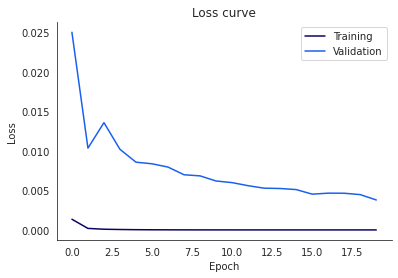

1/1 [==============================] - 0s 16ms/step


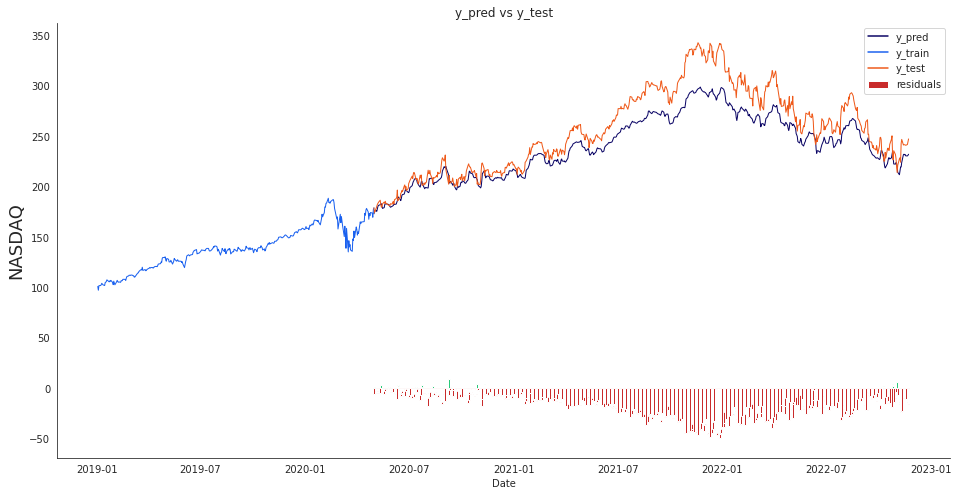

sequence_length 40
Epoch 1/20
21/21 [==============================] - 3s 37ms/step - loss: 0.0170 - val_loss: 0.2653
Epoch 2/20
21/21 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.1846
Epoch 3/20
21/21 [==============================] - 0s 6ms/step - loss: 0.0034 - val_loss: 0.0332
Epoch 4/20
21/21 [==============================] - 0s 6ms/step - loss: 2.8571e-04 - val_loss: 0.0011
Epoch 5/20
21/21 [==============================] - 0s 6ms/step - loss: 1.3045e-04 - val_loss: 0.0035
Epoch 6/20
21/21 [==============================] - 0s 6ms/step - loss: 6.5883e-05 - val_loss: 0.0033
Epoch 7/20
21/21 [==============================] - 0s 6ms/step - loss: 4.4542e-05 - val_loss: 0.0025
Epoch 8/20
21/21 [==============================] - 0s 6ms/step - loss: 3.3596e-05 - val_loss: 0.0023
Epoch 9/20
21/21 [==============================] - 0s 6ms/step - loss: 2.7110e-05 - val_loss: 0.0020
Epoch 10/20
21/21 [==============================] - 0s 7ms/step - loss: 2

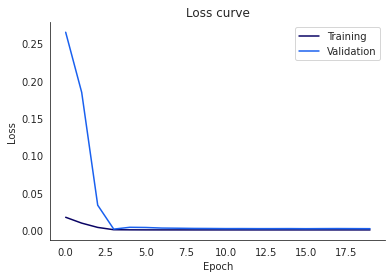

1/1 [==============================] - 0s 15ms/step


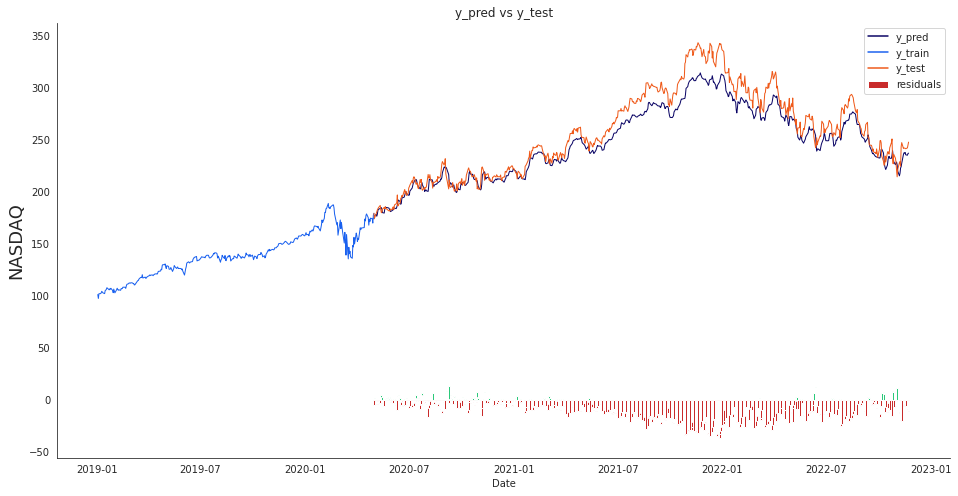

sequence_length 80
Epoch 1/20
21/21 [==============================] - 3s 37ms/step - loss: 0.0075 - val_loss: 0.0748
Epoch 2/20
21/21 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0225
Epoch 3/20
21/21 [==============================] - 0s 7ms/step - loss: 3.0444e-04 - val_loss: 0.0087
Epoch 4/20
21/21 [==============================] - 0s 6ms/step - loss: 2.2831e-04 - val_loss: 0.0103
Epoch 5/20
21/21 [==============================] - 0s 6ms/step - loss: 1.5941e-04 - val_loss: 0.0080
Epoch 6/20
21/21 [==============================] - 0s 6ms/step - loss: 1.1583e-04 - val_loss: 0.0067
Epoch 7/20
21/21 [==============================] - 0s 7ms/step - loss: 8.2985e-05 - val_loss: 0.0061
Epoch 8/20
21/21 [==============================] - 0s 6ms/step - loss: 5.9626e-05 - val_loss: 0.0053
Epoch 9/20
21/21 [==============================] - 0s 6ms/step - loss: 4.3349e-05 - val_loss: 0.0045
Epoch 10/20
21/21 [==============================] - 0s 7ms/step - los

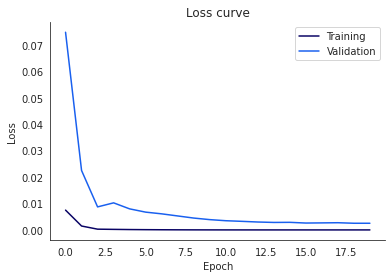

1/1 [==============================] - 0s 15ms/step


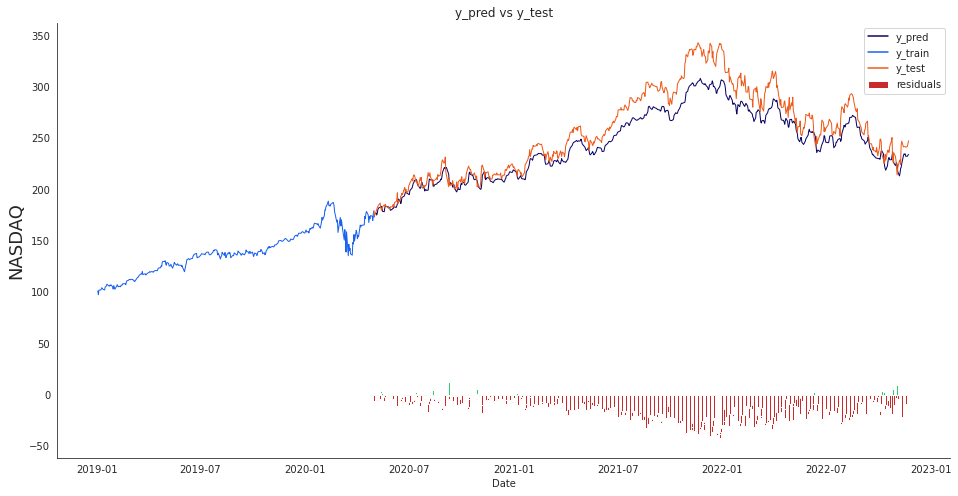

sequence_length 100
Epoch 1/20
21/21 [==============================] - 4s 53ms/step - loss: 0.0067 - val_loss: 0.0618
Epoch 2/20
21/21 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0139
Epoch 3/20
21/21 [==============================] - 0s 7ms/step - loss: 2.0394e-04 - val_loss: 9.7435e-04
Epoch 4/20
21/21 [==============================] - 0s 6ms/step - loss: 1.4419e-04 - val_loss: 0.0022
Epoch 5/20
21/21 [==============================] - 0s 6ms/step - loss: 9.6276e-05 - val_loss: 0.0015
Epoch 6/20
21/21 [==============================] - 0s 6ms/step - loss: 7.1346e-05 - val_loss: 0.0012
Epoch 7/20
21/21 [==============================] - 0s 7ms/step - loss: 5.3822e-05 - val_loss: 0.0011
Epoch 8/20
21/21 [==============================] - 0s 7ms/step - loss: 4.1213e-05 - val_loss: 9.1123e-04
Epoch 9/20
21/21 [==============================] - 0s 6ms/step - loss: 3.2024e-05 - val_loss: 7.7329e-04
Epoch 10/20
21/21 [==============================] - 0s 7

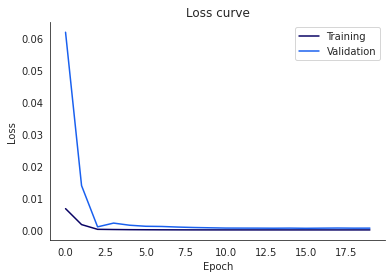

1/1 [==============================] - 0s 17ms/step


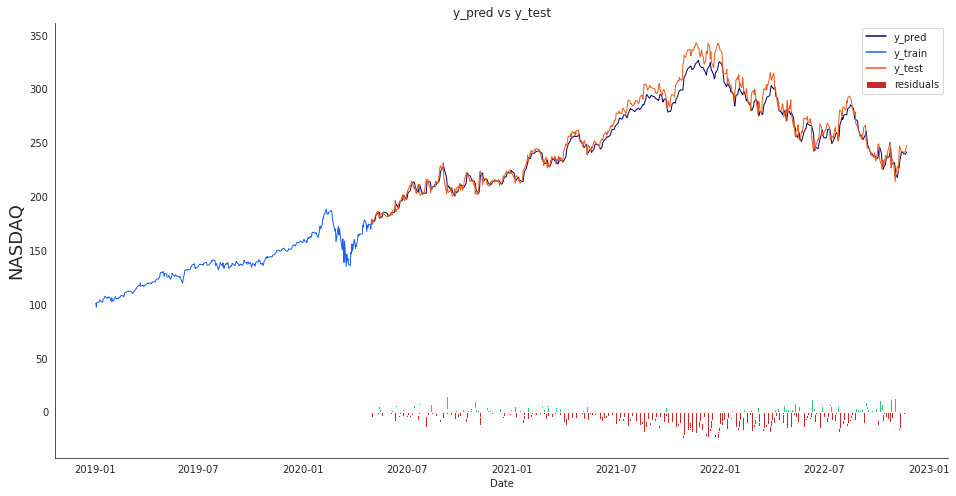

sequence_length 120
Epoch 1/20
21/21 [==============================] - 4s 38ms/step - loss: 0.0115 - val_loss: 0.1675
Epoch 2/20
21/21 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0727
Epoch 3/20
21/21 [==============================] - 0s 6ms/step - loss: 8.2666e-04 - val_loss: 0.0030
Epoch 4/20
21/21 [==============================] - 0s 6ms/step - loss: 6.6496e-05 - val_loss: 0.0012
Epoch 5/20
21/21 [==============================] - 0s 7ms/step - loss: 2.8957e-05 - val_loss: 0.0027
Epoch 6/20
21/21 [==============================] - 0s 7ms/step - loss: 2.2658e-05 - val_loss: 0.0020
Epoch 7/20
21/21 [==============================] - 0s 6ms/step - loss: 2.1363e-05 - val_loss: 0.0022
Epoch 8/20
21/21 [==============================] - 0s 7ms/step - loss: 2.0535e-05 - val_loss: 0.0020
Epoch 9/20
21/21 [==============================] - 0s 6ms/step - loss: 2.0002e-05 - val_loss: 0.0020
Epoch 10/20
21/21 [==============================] - 0s 7ms/step - lo

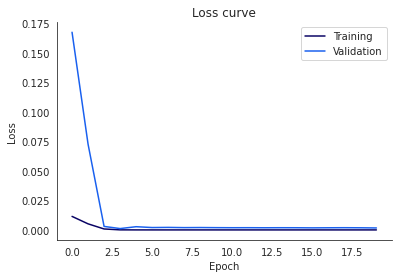

1/1 [==============================] - 0s 17ms/step


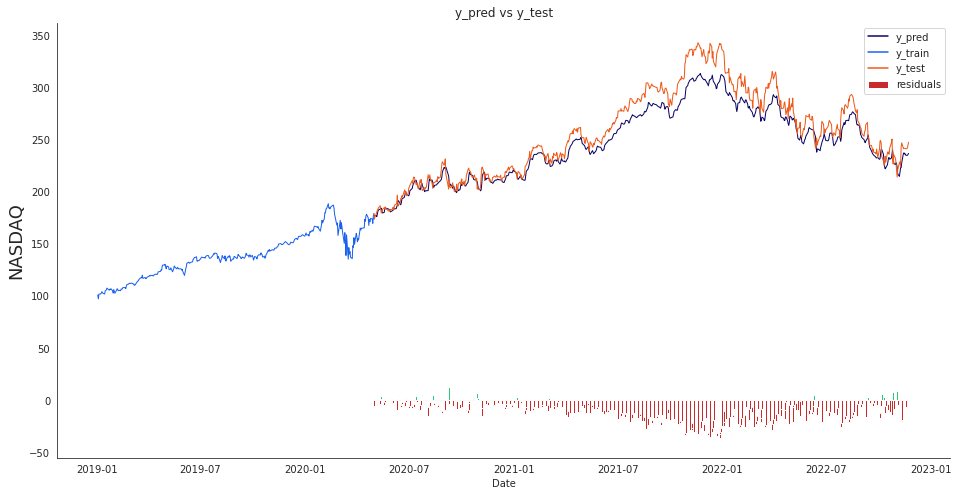

In [ ]:
#Experiment for sequence length
random_seed()

end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'
stockname = 'NASDAQ'
symbol = 'MSFT'
model_name = 'GRU'
epochs = 20
batch_size = 128
learning_rate = 0.001
number_of_layer = 0

loss_func = tf.keras.losses.MeanSquaredError()
sequence_lengths = [2, 4, 20, 40, 80, 100, 120]
features = ['High', 'Low', 'Open', 'Close', 'Volume']
# features = ['High', 'Low', 'Open', 'Close']

# Train GRU model
input_data_df = get_data(symbol, start_date, end_date)
results_gru_sl = []
for sl in sequence_lengths:
  print('sequence_length', sl)
  optimizer = tf.keras.optimizers.Adam(learning_rate)
  result = train_networks(input_data_df, features, model_name, epochs, batch_size, optimizer,loss_func, sequence_length, number_of_layer)
  result['sequence_length'] = sl
  results_gru_sl.append(result)


###Result

In [ ]:
results_gru_sl
result_df_gru_sl = pd.DataFrame(results_gru_sl)
result_df_gru_sl.sort_values(by=["mse"])

epochs  batch_size  sequence_length        mae      mape     mdape  \
5      20         128              100   5.906392  2.186097  1.870996   
0      20         128                2   7.907442  2.877359  2.555723   
1      20         128                4  10.344747  4.091008  4.012861   
6      20         128              120  10.438439  3.775656  3.457145   
3      20         128               40  10.392069  3.755115  3.384965   
4      20         128               80  13.140076  4.761428  4.498857   
2      20         128               20  16.159674  5.824554  5.539136   

          mse  test_prediction_difference  training_time  number_of_layers  
5   58.888426                    4.109999      11.073341                 0  
0  104.933587                    5.900007      10.482822                 0  
1  138.732052                    9.029985       9.203084                 0  
6  171.935254                    9.109999       9.551388                 0  
3  173.363647                    9.300001      10.807296                 0  
4  260.091875                   12.219999      10.855037                 0  
2  390.282174                   13.669996       9.143527                 0

# Experiement for Date Changing

## Experiement

Date 2010-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
163/163 [==============================] - 5s 12ms/step - loss: 0.0075 - val_loss: 5.5422e-04
Epoch 2/20
163/163 [==============================] - 1s 7ms/step - loss: 1.2018e-04 - val_loss: 5.5867e-04
Epoch 3/20
163/163 [==============================] - 1s 6ms/step - loss: 5.9382e-05 - val_loss: 0.0011
Epoch 4/20
163/163 [==============================] - 1s 6ms/step - loss: 4.4649e-05 - val_loss: 0.0020
Epoch 5/20
163/163 [==============================] - 1s 6ms/step - loss: 3.1264e-05 - val_loss: 0.0037
Epoch 6/20
163/163 [==============================] - 1s 5ms/step - loss: 2.8598e-05 - val_loss: 0.0051
Epoch 7/20
163/163 [==============================] - 1s 6ms/step - loss: 2.7252e-05 - val_loss: 0.0064
Epoch 8/20
163/163 [==============================] - 1s 5ms/step - loss: 2.6983e-05 - val_loss: 0.0052
Epoch 9/20
163/163 [==============================] - 1s 5ms/step - loss: 2.51

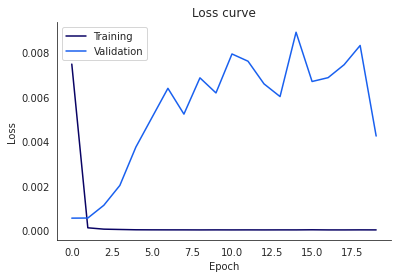

1/1 [==============================] - 0s 14ms/step


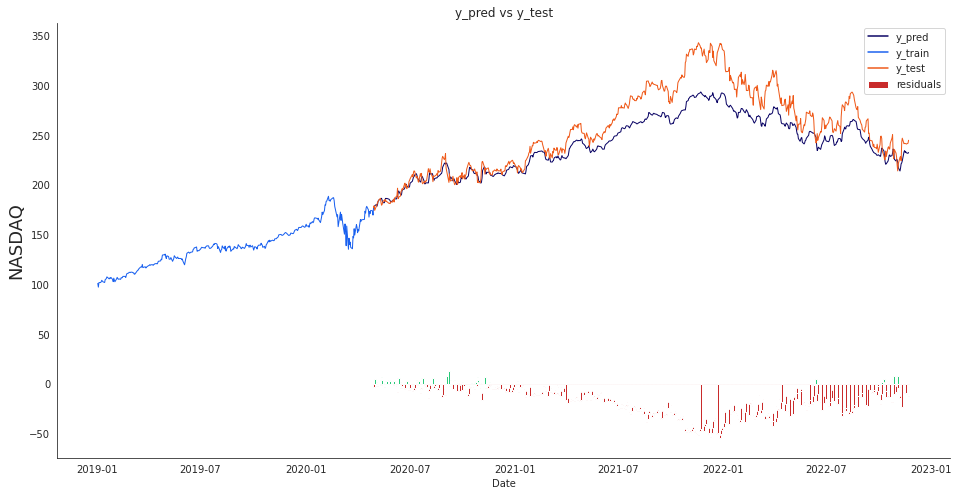

Date 2010-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
163/163 [==============================] - 6s 12ms/step - loss: 0.0071 - val_loss: 0.0041
Epoch 2/20
163/163 [==============================] - 1s 7ms/step - loss: 6.9467e-05 - val_loss: 5.2349e-04
Epoch 3/20
163/163 [==============================] - 1s 7ms/step - loss: 3.4803e-05 - val_loss: 0.0024
Epoch 4/20
163/163 [==============================] - 1s 7ms/step - loss: 3.4872e-05 - val_loss: 0.0025
Epoch 5/20
163/163 [==============================] - 1s 7ms/step - loss: 2.7459e-05 - val_loss: 0.0039
Epoch 6/20
163/163 [==============================] - 1s 7ms/step - loss: 3.0722e-05 - val_loss: 0.0034
Epoch 7/20
163/163 [==============================] - 1s 7ms/step - loss: 2.8555e-05 - val_loss: 0.0067
Epoch 8/20
163/163 [==============================] - 1s 7ms/step - loss: 2.8822e-05 - val_loss: 0.0036
Epoch 9/20
163/163 [==============================] - 1s 7ms/step - loss: 2.7441e-

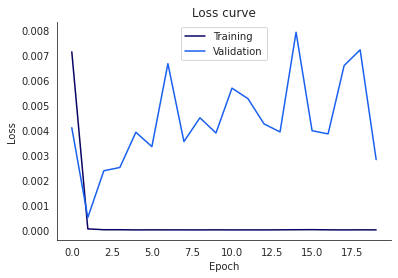

1/1 [==============================] - 0s 17ms/step


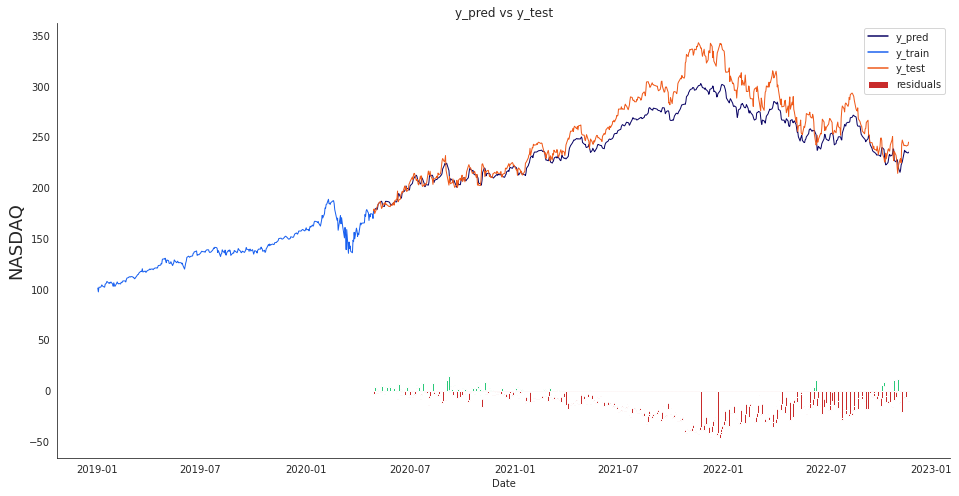

Date 2010-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
163/163 [==============================] - 8s 16ms/step - loss: 0.0090 - val_loss: 0.0054
Epoch 2/20
163/163 [==============================] - 1s 9ms/step - loss: 7.3639e-05 - val_loss: 0.0121
Epoch 3/20
163/163 [==============================] - 1s 8ms/step - loss: 4.9534e-05 - val_loss: 0.0177
Epoch 4/20
163/163 [==============================] - 1s 8ms/step - loss: 4.2828e-05 - val_loss: 0.0165
Epoch 5/20
163/163 [==============================] - 1s 8ms/step - loss: 4.1691e-05 - val_loss: 0.0181
Epoch 6/20
163/163 [==============================] - 1s 8ms/step - loss: 4.2276e-05 - val_loss: 0.0158
Epoch 7/20
163/163 [==============================] - 1s 8ms/step - loss: 3.9326e-05 - val_loss: 0.0232
Epoch 8/20
163/163 [==============================] - 1s 8ms/step - loss: 4.1505e-05 - val_loss: 0.0159
Epoch 9/20
163/163 [==============================] - 1s 9ms/step - loss: 4.0508e-05 -

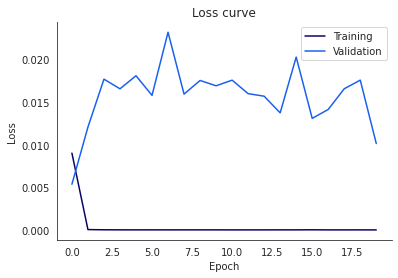

1/1 [==============================] - 0s 17ms/step


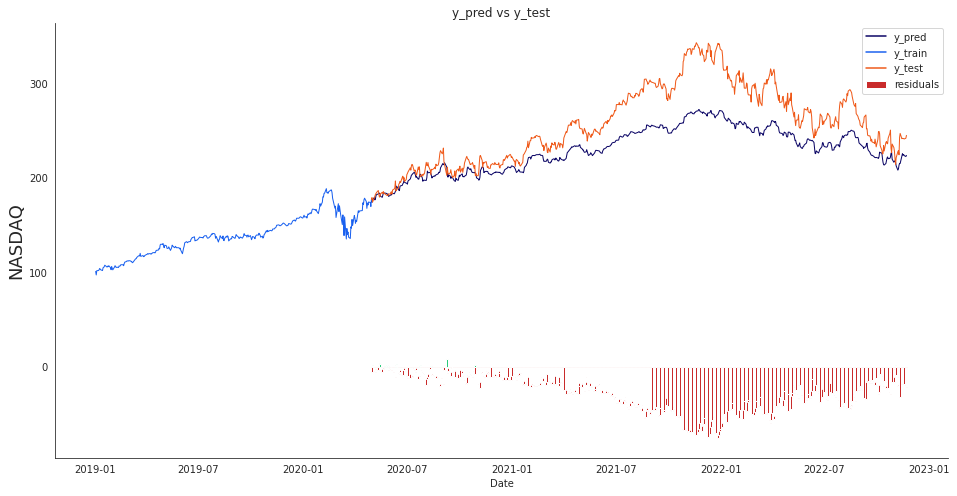

Date 2010-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
163/163 [==============================] - 3s 9ms/step - loss: 0.0088 - val_loss: 0.0869
Epoch 2/20
163/163 [==============================] - 1s 8ms/step - loss: 4.0777e-04 - val_loss: 0.0607
Epoch 3/20
163/163 [==============================] - 1s 7ms/step - loss: 1.9272e-04 - val_loss: 0.0398
Epoch 4/20
163/163 [==============================] - 1s 7ms/step - loss: 9.7392e-05 - val_loss: 0.0282
Epoch 5/20
163/163 [==============================] - 1s 7ms/step - loss: 5.4284e-05 - val_loss: 0.0199
Epoch 6/20
163/163 [==============================] - 1s 7ms/step - loss: 3.9261e-05 - val_loss: 0.0142
Epoch 7/20
163/163 [==============================] - 1s 7ms/step - loss: 3.2741e-05 - val_loss: 0.0124
Epoch 8/20
163/163 [==============================] - 1s 7ms/step - loss: 2.9175e-05 - val_loss: 0.0077
Epoch 9/20
163/163 [==============================] - 1s 8ms/step - loss: 2.6494e-05 - 

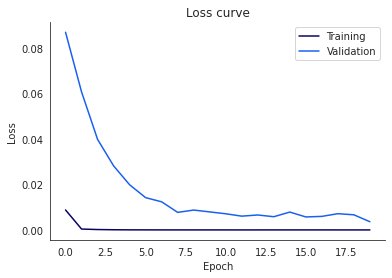

1/1 [==============================] - 0s 18ms/step


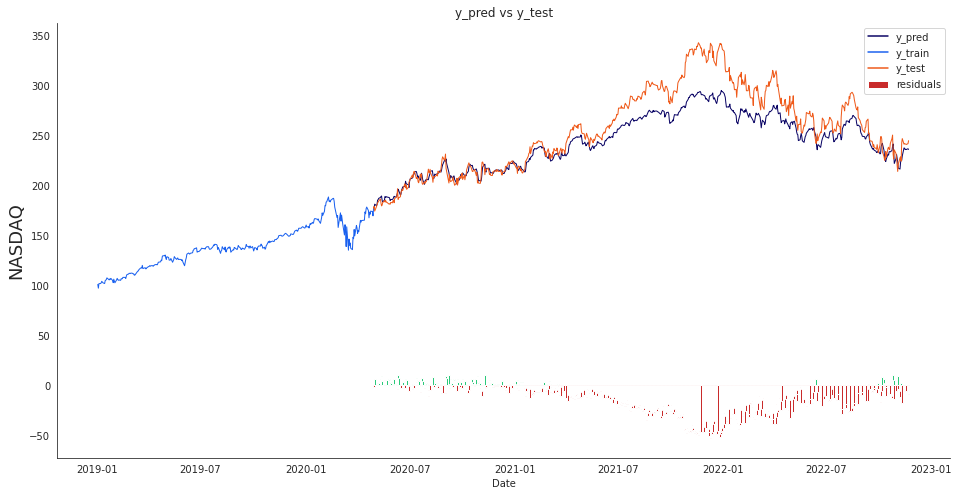

Date 2010-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
163/163 [==============================] - 4s 12ms/step - loss: 0.0055 - val_loss: 0.2317
Epoch 2/20
163/163 [==============================] - 2s 9ms/step - loss: 5.0177e-04 - val_loss: 0.1143
Epoch 3/20
163/163 [==============================] - 2s 10ms/step - loss: 1.6186e-04 - val_loss: 0.0700
Epoch 4/20
163/163 [==============================] - 2s 9ms/step - loss: 6.7337e-05 - val_loss: 0.0478
Epoch 5/20
163/163 [==============================] - 2s 10ms/step - loss: 5.2446e-05 - val_loss: 0.0453
Epoch 6/20
163/163 [==============================] - 2s 10ms/step - loss: 5.0905e-05 - val_loss: 0.0372
Epoch 7/20
163/163 [==============================] - 2s 10ms/step - loss: 4.4293e-05 - val_loss: 0.0382
Epoch 8/20
163/163 [==============================] - 2s 10ms/step - loss: 4.3673e-05 - val_loss: 0.0355
Epoch 9/20
163/163 [==============================] - 2s 10ms/step - loss: 5.2005

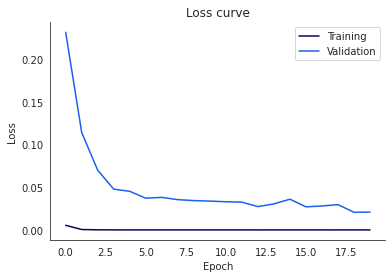

1/1 [==============================] - 0s 15ms/step


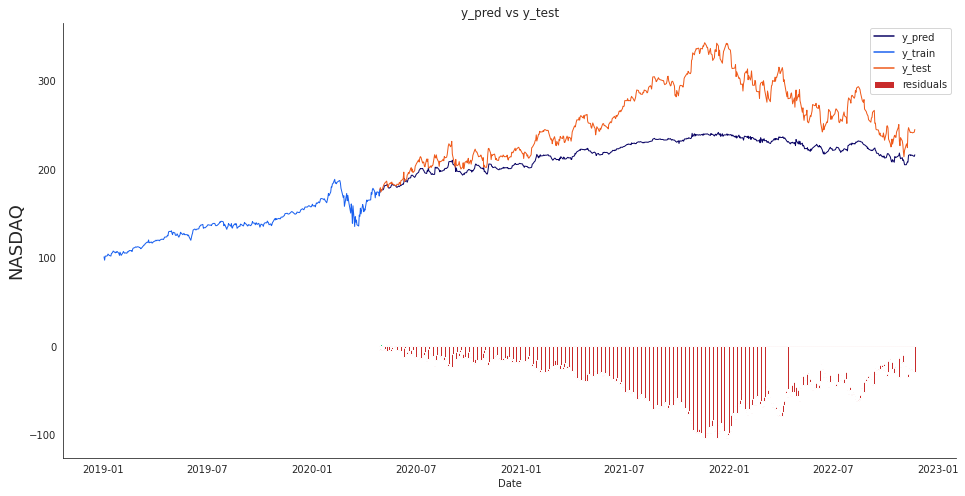

Date 2010-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
163/163 [==============================] - 5s 15ms/step - loss: 0.0020 - val_loss: 0.0749
Epoch 2/20
163/163 [==============================] - 2s 12ms/step - loss: 1.8828e-04 - val_loss: 0.0547
Epoch 3/20
163/163 [==============================] - 2s 12ms/step - loss: 1.2744e-04 - val_loss: 0.0429
Epoch 4/20
163/163 [==============================] - 2s 12ms/step - loss: 1.0444e-04 - val_loss: 0.0305
Epoch 5/20
163/163 [==============================] - 2s 12ms/step - loss: 8.2088e-05 - val_loss: 0.0269
Epoch 6/20
163/163 [==============================] - 2s 12ms/step - loss: 8.2732e-05 - val_loss: 0.0240
Epoch 7/20
163/163 [==============================] - 2s 12ms/step - loss: 5.6421e-05 - val_loss: 0.0190
Epoch 8/20
163/163 [==============================] - 2s 12ms/step - loss: 5.0997e-05 - val_loss: 0.0141
Epoch 9/20
163/163 [==============================] - 2s 12ms/step - loss: 5.47

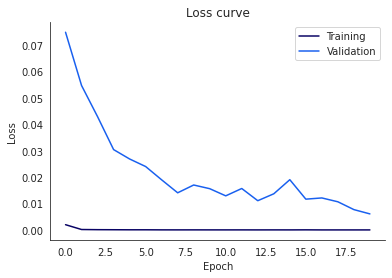

1/1 [==============================] - 0s 17ms/step


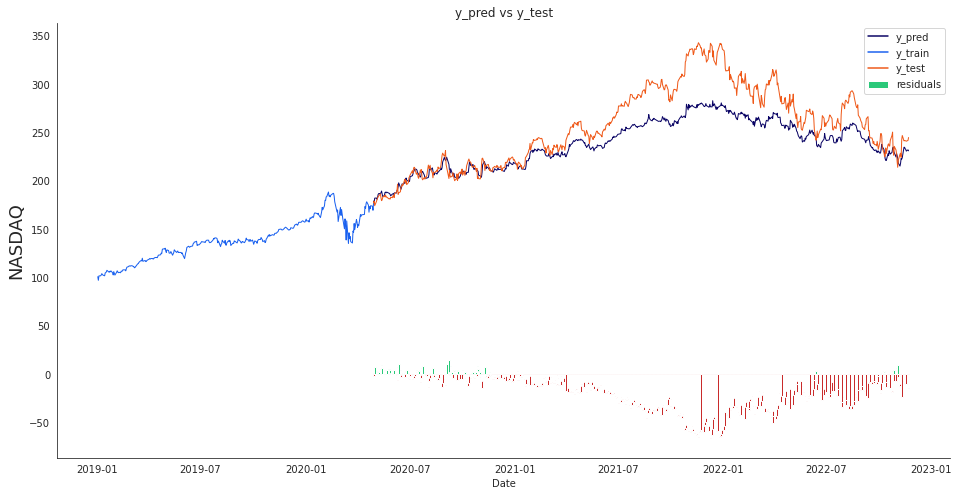

Date 2010-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
163/163 [==============================] - 4s 9ms/step - loss: 0.0020 - val_loss: 0.0053
Epoch 2/20
163/163 [==============================] - 1s 6ms/step - loss: 2.9555e-05 - val_loss: 0.0038
Epoch 3/20
163/163 [==============================] - 1s 5ms/step - loss: 2.6587e-05 - val_loss: 0.0048
Epoch 4/20
163/163 [==============================] - 1s 5ms/step - loss: 2.9312e-05 - val_loss: 0.0024
Epoch 5/20
163/163 [==============================] - 1s 5ms/step - loss: 2.6207e-05 - val_loss: 0.0029
Epoch 6/20
163/163 [==============================] - 1s 5ms/step - loss: 2.8850e-05 - val_loss: 0.0017
Epoch 7/20
163/163 [==============================] - 1s 5ms/step - loss: 2.7586e-05 - val_loss: 0.0030
Epoch 8/20
163/163 [==============================] - 1s 5ms/step - loss: 2.6360e-05 - val_loss: 0.0013
Epoch 9/20
163/163 [==============================] - 1s 5ms/step - loss: 2.6963e-05 - 

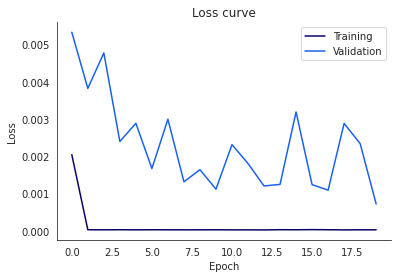

1/1 [==============================] - 0s 14ms/step


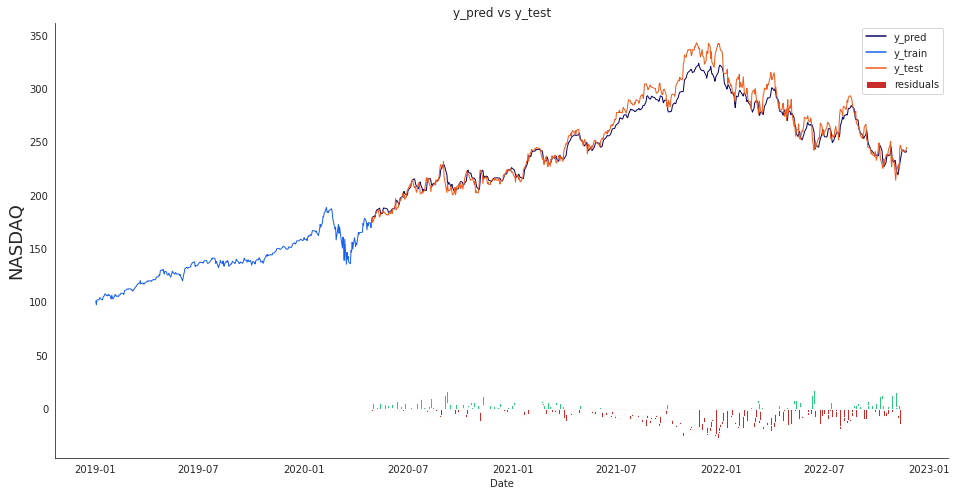

Date 2010-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
163/163 [==============================] - 6s 14ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 2/20
163/163 [==============================] - 1s 7ms/step - loss: 2.7667e-05 - val_loss: 0.0021
Epoch 3/20
163/163 [==============================] - 1s 6ms/step - loss: 2.4723e-05 - val_loss: 0.0037
Epoch 4/20
163/163 [==============================] - 1s 6ms/step - loss: 3.0205e-05 - val_loss: 0.0024
Epoch 5/20
163/163 [==============================] - 1s 7ms/step - loss: 2.5350e-05 - val_loss: 0.0032
Epoch 6/20
163/163 [==============================] - 1s 7ms/step - loss: 2.9899e-05 - val_loss: 0.0026
Epoch 7/20
163/163 [==============================] - 1s 7ms/step - loss: 2.7568e-05 - val_loss: 0.0046
Epoch 8/20
163/163 [==============================] - 1s 7ms/step - loss: 2.7111e-05 - val_loss: 0.0024
Epoch 9/20
163/163 [==============================] - 1s 7ms/step - loss: 2.7926e-05 -

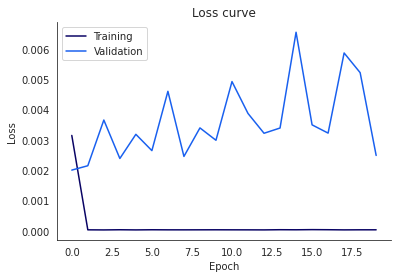

1/1 [==============================] - 0s 18ms/step


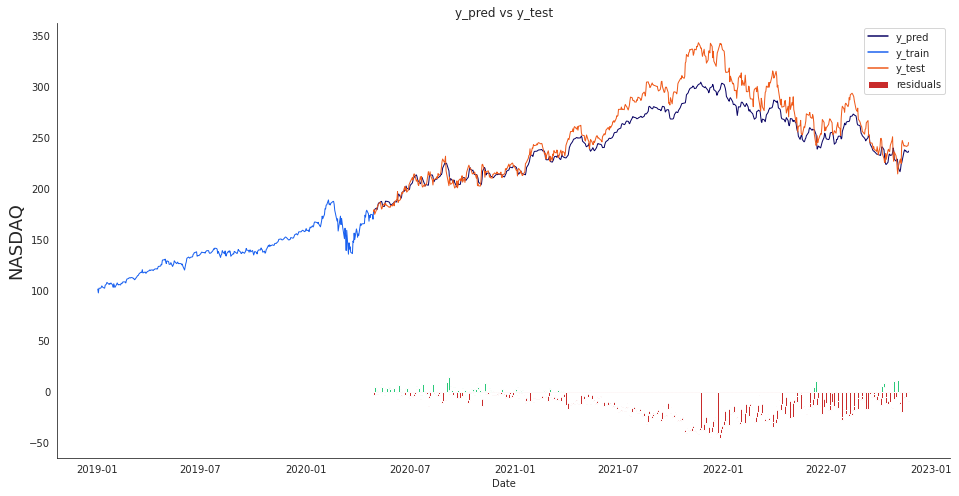

Date 2010-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
163/163 [==============================] - 8s 18ms/step - loss: 0.0050 - val_loss: 0.0115
Epoch 2/20
163/163 [==============================] - 1s 8ms/step - loss: 2.9884e-05 - val_loss: 0.0126
Epoch 3/20
163/163 [==============================] - 1s 8ms/step - loss: 2.9467e-05 - val_loss: 0.0140
Epoch 4/20
163/163 [==============================] - 1s 8ms/step - loss: 3.2070e-05 - val_loss: 0.0106
Epoch 5/20
163/163 [==============================] - 1s 8ms/step - loss: 3.0461e-05 - val_loss: 0.0113
Epoch 6/20
163/163 [==============================] - 1s 8ms/step - loss: 3.7502e-05 - val_loss: 0.0106
Epoch 7/20
163/163 [==============================] - 1s 8ms/step - loss: 3.1312e-05 - val_loss: 0.0123
Epoch 8/20
163/163 [==============================] - 1s 8ms/step - loss: 3.2603e-05 - val_loss: 0.0080
Epoch 9/20
163/163 [==============================] - 1s 8ms/step - loss: 3.2680e-05 -

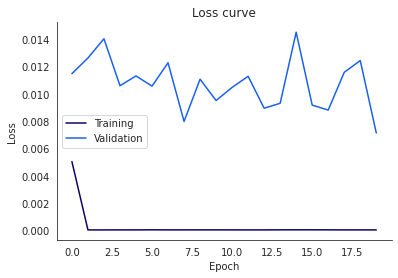

1/1 [==============================] - 0s 16ms/step


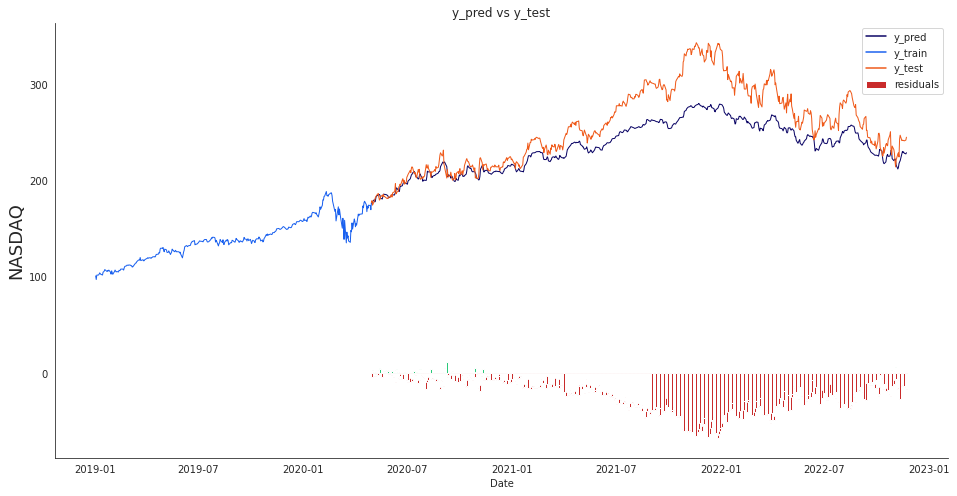

Date 2015-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
100/100 [==============================] - 4s 13ms/step - loss: 0.0329 - val_loss: 0.0622
Epoch 2/20
100/100 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 5.8285e-04
Epoch 3/20
100/100 [==============================] - 1s 6ms/step - loss: 1.1258e-04 - val_loss: 7.6352e-04
Epoch 4/20
100/100 [==============================] - 1s 6ms/step - loss: 9.5579e-05 - val_loss: 0.0010
Epoch 5/20
100/100 [==============================] - 1s 6ms/step - loss: 8.7358e-05 - val_loss: 0.0015
Epoch 6/20
100/100 [==============================] - 1s 6ms/step - loss: 8.4473e-05 - val_loss: 0.0015
Epoch 7/20
100/100 [==============================] - 1s 6ms/step - loss: 8.3544e-05 - val_loss: 0.0020
Epoch 8/20
100/100 [==============================] - 1s 6ms/step - loss: 8.2327e-05 - val_loss: 0.0013
Epoch 9/20
100/100 [==============================] - 1s 6ms/step - loss: 8.5725e-

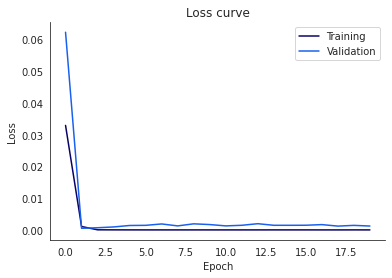

1/1 [==============================] - 0s 14ms/step


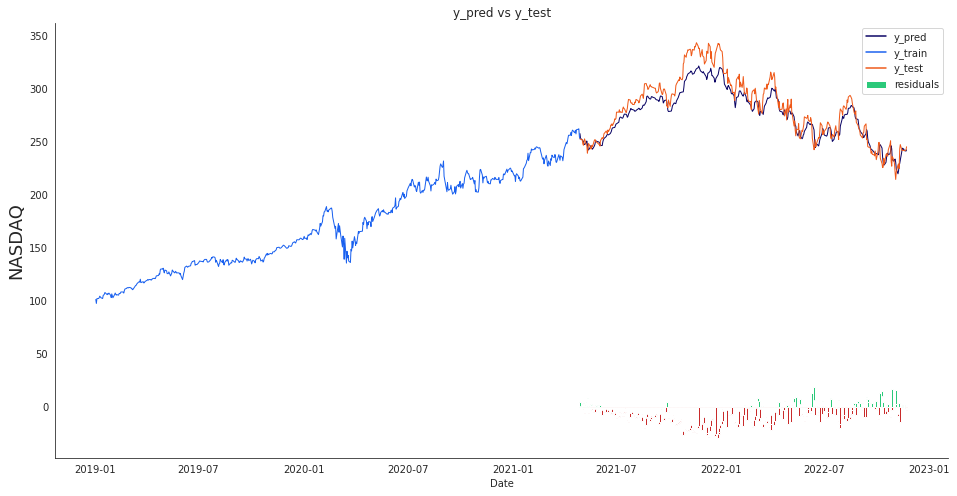

Date 2015-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
100/100 [==============================] - 6s 17ms/step - loss: 0.0325 - val_loss: 0.0418
Epoch 2/20
100/100 [==============================] - 1s 7ms/step - loss: 7.2511e-04 - val_loss: 8.9062e-04
Epoch 3/20
100/100 [==============================] - 1s 8ms/step - loss: 1.7069e-04 - val_loss: 0.0014
Epoch 4/20
100/100 [==============================] - 1s 8ms/step - loss: 1.2316e-04 - val_loss: 0.0023
Epoch 5/20
100/100 [==============================] - 1s 9ms/step - loss: 1.0690e-04 - val_loss: 0.0032
Epoch 6/20
100/100 [==============================] - 1s 8ms/step - loss: 1.0472e-04 - val_loss: 0.0031
Epoch 7/20
100/100 [==============================] - 1s 8ms/step - loss: 1.0141e-04 - val_loss: 0.0034
Epoch 8/20
100/100 [==============================] - 1s 7ms/step - loss: 1.0065e-04 - val_loss: 0.0032
Epoch 9/20
100/100 [==============================] - 1s 7ms/step - loss: 1.0597e-

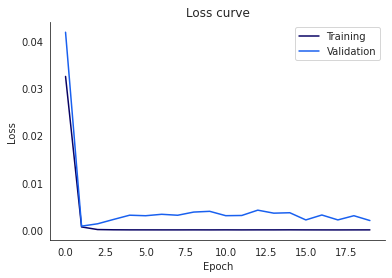

1/1 [==============================] - 0s 17ms/step


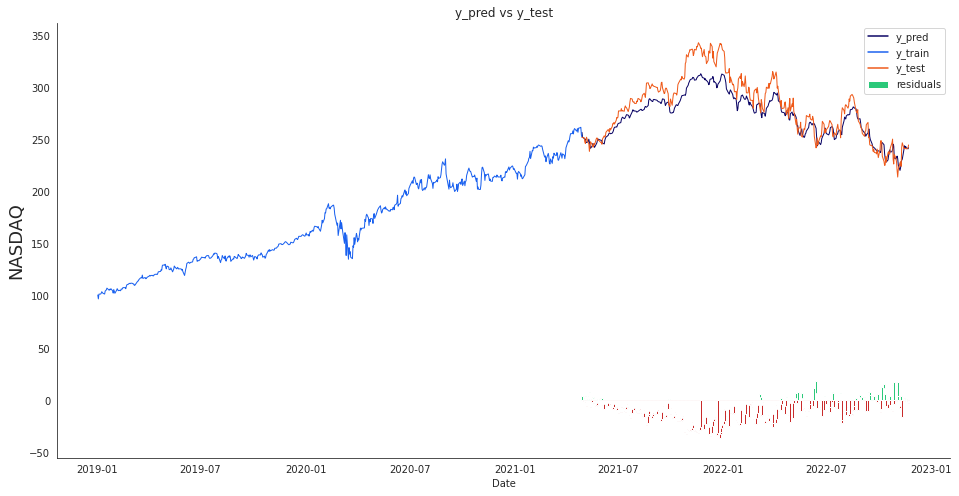

Date 2015-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
100/100 [==============================] - 7s 21ms/step - loss: 0.0374 - val_loss: 0.1020
Epoch 2/20
100/100 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 3/20
100/100 [==============================] - 1s 9ms/step - loss: 2.7896e-04 - val_loss: 0.0032
Epoch 4/20
100/100 [==============================] - 1s 9ms/step - loss: 1.8202e-04 - val_loss: 0.0053
Epoch 5/20
100/100 [==============================] - 1s 9ms/step - loss: 1.4930e-04 - val_loss: 0.0054
Epoch 6/20
100/100 [==============================] - 1s 9ms/step - loss: 1.4960e-04 - val_loss: 0.0047
Epoch 7/20
100/100 [==============================] - 1s 10ms/step - loss: 1.3341e-04 - val_loss: 0.0049
Epoch 8/20
100/100 [==============================] - 1s 9ms/step - loss: 1.3215e-04 - val_loss: 0.0050
Epoch 9/20
100/100 [==============================] - 1s 9ms/step - loss: 1.3589e-04 - va

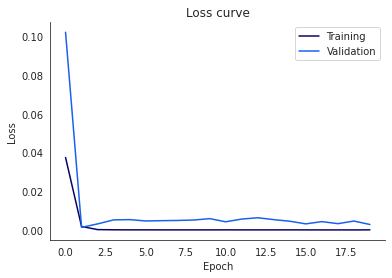

1/1 [==============================] - 0s 16ms/step


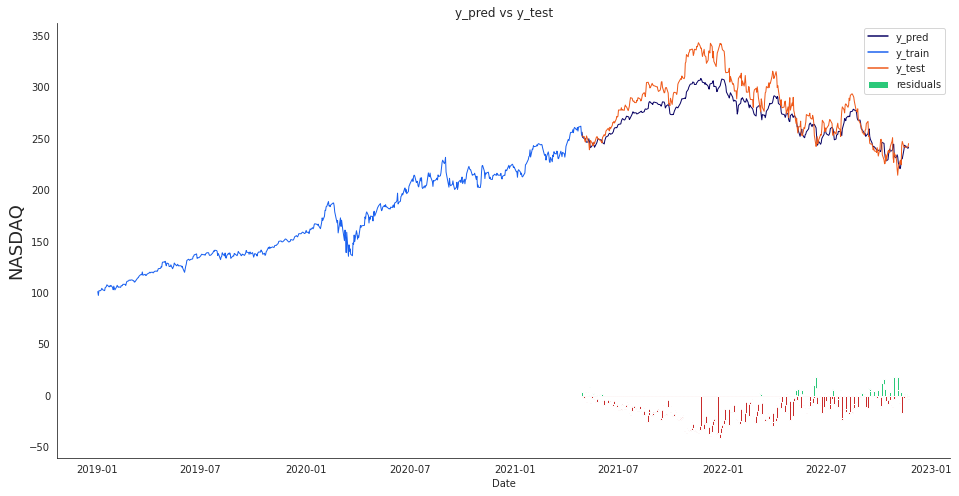

Date 2015-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
100/100 [==============================] - 2s 11ms/step - loss: 0.0490 - val_loss: 0.0318
Epoch 2/20
100/100 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0222
Epoch 3/20
100/100 [==============================] - 1s 8ms/step - loss: 7.3392e-04 - val_loss: 0.0211
Epoch 4/20
100/100 [==============================] - 1s 8ms/step - loss: 5.3129e-04 - val_loss: 0.0188
Epoch 5/20
100/100 [==============================] - 1s 8ms/step - loss: 4.1638e-04 - val_loss: 0.0147
Epoch 6/20
100/100 [==============================] - 1s 8ms/step - loss: 3.4365e-04 - val_loss: 0.0129
Epoch 7/20
100/100 [==============================] - 1s 8ms/step - loss: 2.9109e-04 - val_loss: 0.0137
Epoch 8/20
100/100 [==============================] - 1s 8ms/step - loss: 2.4979e-04 - val_loss: 0.0085
Epoch 9/20
100/100 [==============================] - 1s 8ms/step - loss: 2.3037e-04 - val

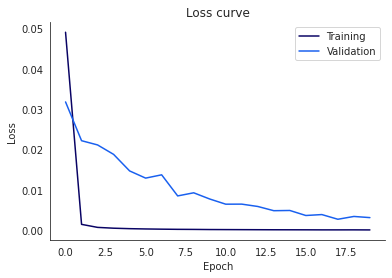

1/1 [==============================] - 0s 14ms/step


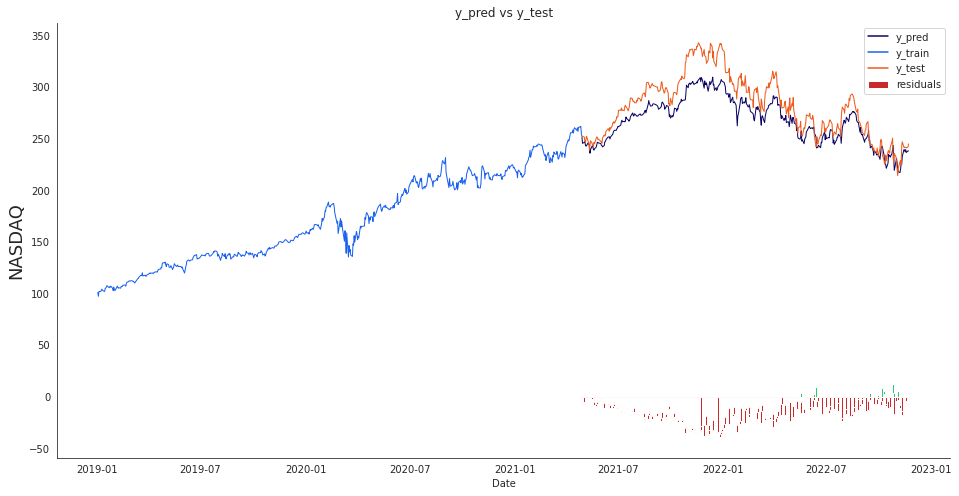

Date 2015-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
100/100 [==============================] - 3s 14ms/step - loss: 0.0174 - val_loss: 0.0113
Epoch 2/20
100/100 [==============================] - 1s 10ms/step - loss: 2.6666e-04 - val_loss: 0.0078
Epoch 3/20
100/100 [==============================] - 1s 10ms/step - loss: 2.3727e-04 - val_loss: 0.0061
Epoch 4/20
100/100 [==============================] - 1s 10ms/step - loss: 2.1322e-04 - val_loss: 0.0078
Epoch 5/20
100/100 [==============================] - 1s 11ms/step - loss: 2.0227e-04 - val_loss: 0.0049
Epoch 6/20
100/100 [==============================] - 1s 10ms/step - loss: 1.8871e-04 - val_loss: 0.0041
Epoch 7/20
100/100 [==============================] - 1s 10ms/step - loss: 1.6816e-04 - val_loss: 0.0043
Epoch 8/20
100/100 [==============================] - 1s 10ms/step - loss: 1.6094e-04 - val_loss: 0.0029
Epoch 9/20
100/100 [==============================] - 1s 10ms/step - loss: 1.49

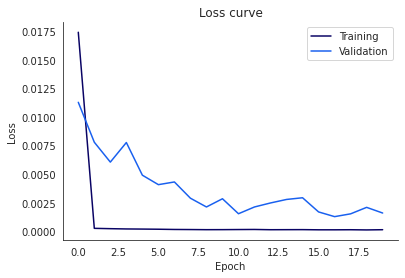

1/1 [==============================] - 0s 16ms/step


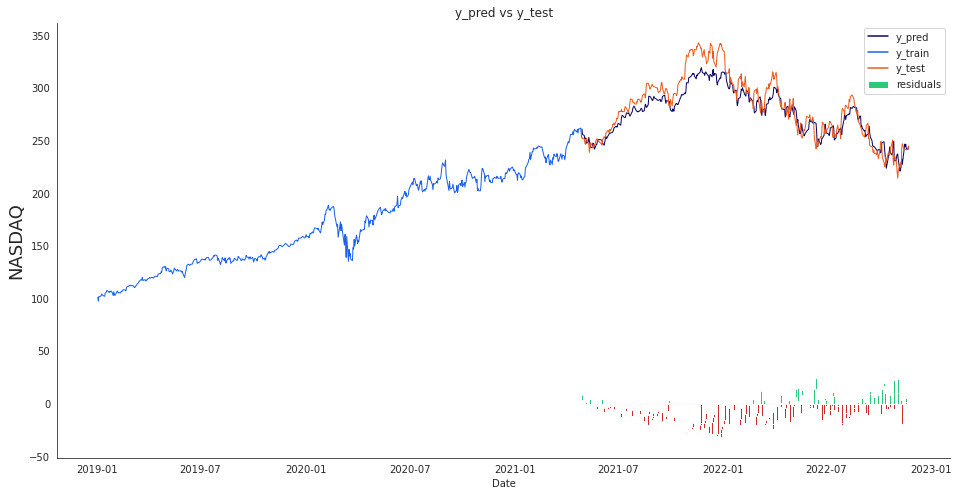

Date 2015-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
100/100 [==============================] - 5s 18ms/step - loss: 0.0363 - val_loss: 0.0443
Epoch 2/20
100/100 [==============================] - 1s 14ms/step - loss: 0.0022 - val_loss: 0.0260
Epoch 3/20
100/100 [==============================] - 1s 14ms/step - loss: 9.8317e-04 - val_loss: 0.0207
Epoch 4/20
100/100 [==============================] - 1s 13ms/step - loss: 5.3367e-04 - val_loss: 0.0196
Epoch 5/20
100/100 [==============================] - 1s 13ms/step - loss: 3.8092e-04 - val_loss: 0.0133
Epoch 6/20
100/100 [==============================] - 1s 13ms/step - loss: 3.3970e-04 - val_loss: 0.0139
Epoch 7/20
100/100 [==============================] - 1s 13ms/step - loss: 2.8687e-04 - val_loss: 0.0109
Epoch 8/20
100/100 [==============================] - 1s 13ms/step - loss: 2.6249e-04 - val_loss: 0.0129
Epoch 9/20
100/100 [==============================] - 1s 14ms/step - loss: 2.3136e-

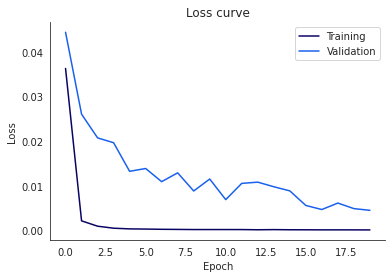

1/1 [==============================] - 0s 15ms/step


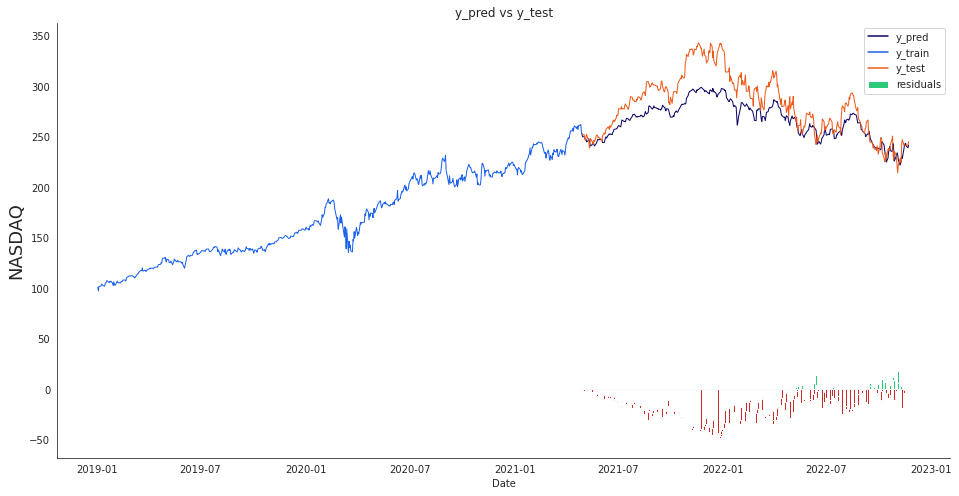

Date 2015-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
100/100 [==============================] - 4s 12ms/step - loss: 0.0270 - val_loss: 0.0092
Epoch 2/20
100/100 [==============================] - 1s 6ms/step - loss: 1.6682e-04 - val_loss: 5.1551e-04
Epoch 3/20
100/100 [==============================] - 1s 6ms/step - loss: 8.1877e-05 - val_loss: 5.2280e-04
Epoch 4/20
100/100 [==============================] - 1s 6ms/step - loss: 8.0001e-05 - val_loss: 5.4450e-04
Epoch 5/20
100/100 [==============================] - 1s 6ms/step - loss: 7.8533e-05 - val_loss: 6.7301e-04
Epoch 6/20
100/100 [==============================] - 1s 6ms/step - loss: 7.5997e-05 - val_loss: 6.2790e-04
Epoch 7/20
100/100 [==============================] - 1s 6ms/step - loss: 7.6409e-05 - val_loss: 8.9900e-04
Epoch 8/20
100/100 [==============================] - 1s 6ms/step - loss: 7.5170e-05 - val_loss: 6.7233e-04
Epoch 9/20
100/100 [==============================] - 1s 6

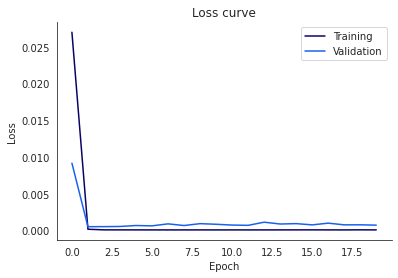

1/1 [==============================] - 0s 14ms/step


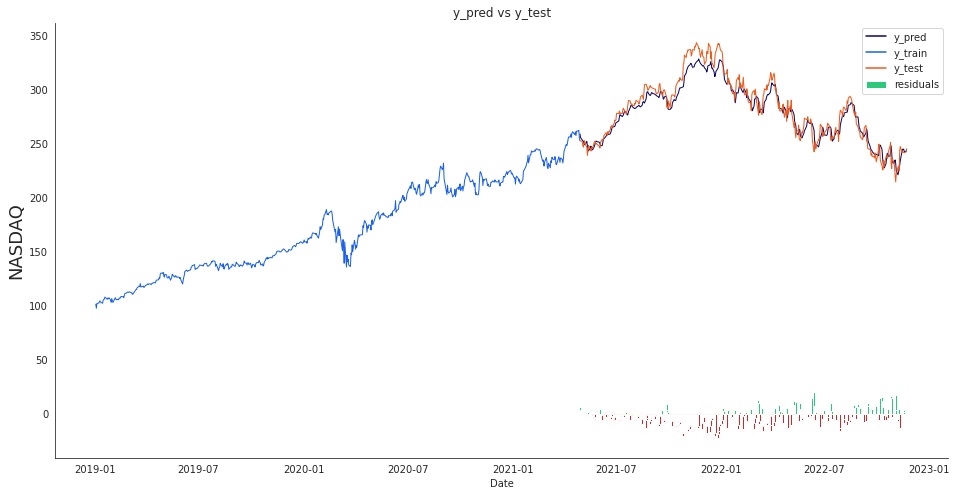

Date 2015-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
100/100 [==============================] - 6s 16ms/step - loss: 0.0133 - val_loss: 5.8144e-04
Epoch 2/20
100/100 [==============================] - 1s 8ms/step - loss: 7.9544e-05 - val_loss: 7.2807e-04
Epoch 3/20
100/100 [==============================] - 1s 7ms/step - loss: 7.8132e-05 - val_loss: 8.9605e-04
Epoch 4/20
100/100 [==============================] - 1s 8ms/step - loss: 8.0028e-05 - val_loss: 0.0011
Epoch 5/20
100/100 [==============================] - 1s 7ms/step - loss: 8.2662e-05 - val_loss: 0.0010
Epoch 6/20
100/100 [==============================] - 1s 7ms/step - loss: 8.1254e-05 - val_loss: 9.7382e-04
Epoch 7/20
100/100 [==============================] - 1s 8ms/step - loss: 7.9244e-05 - val_loss: 0.0012
Epoch 8/20
100/100 [==============================] - 1s 7ms/step - loss: 8.0290e-05 - val_loss: 0.0011
Epoch 9/20
100/100 [==============================] - 1s 7ms/step - lo

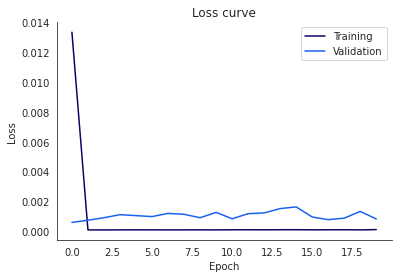

1/1 [==============================] - 0s 16ms/step


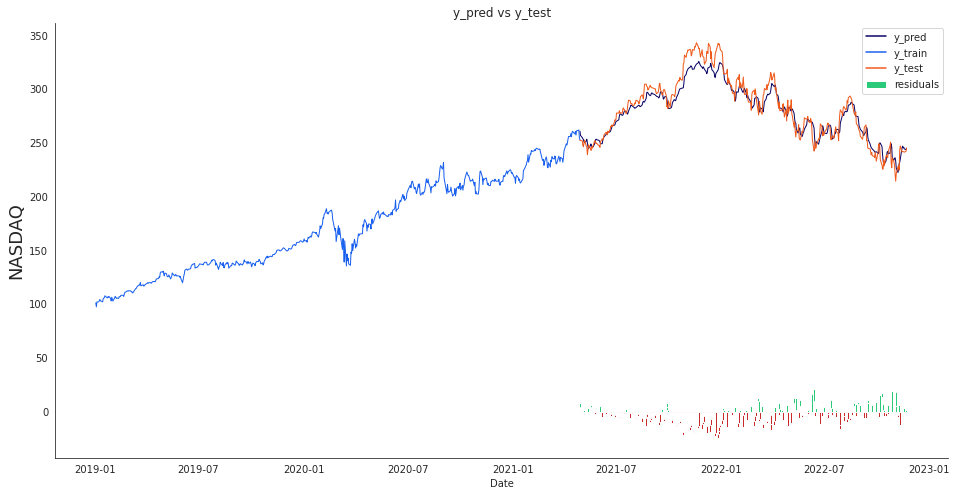

Date 2015-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
100/100 [==============================] - 7s 19ms/step - loss: 0.0212 - val_loss: 0.0015
Epoch 2/20
100/100 [==============================] - 1s 8ms/step - loss: 1.5233e-04 - val_loss: 0.0039
Epoch 3/20
100/100 [==============================] - 1s 8ms/step - loss: 1.1180e-04 - val_loss: 0.0039
Epoch 4/20
100/100 [==============================] - 1s 9ms/step - loss: 1.0980e-04 - val_loss: 0.0050
Epoch 5/20
100/100 [==============================] - 1s 8ms/step - loss: 1.0888e-04 - val_loss: 0.0045
Epoch 6/20
100/100 [==============================] - 1s 8ms/step - loss: 1.1395e-04 - val_loss: 0.0042
Epoch 7/20
100/100 [==============================] - 1s 8ms/step - loss: 1.0481e-04 - val_loss: 0.0040
Epoch 8/20
100/100 [==============================] - 1s 8ms/step - loss: 1.0784e-04 - val_loss: 0.0045
Epoch 9/20
100/100 [==============================] - 1s 9ms/step - loss: 1.0705e-04 -

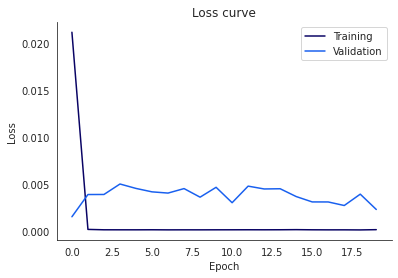

1/1 [==============================] - 0s 16ms/step


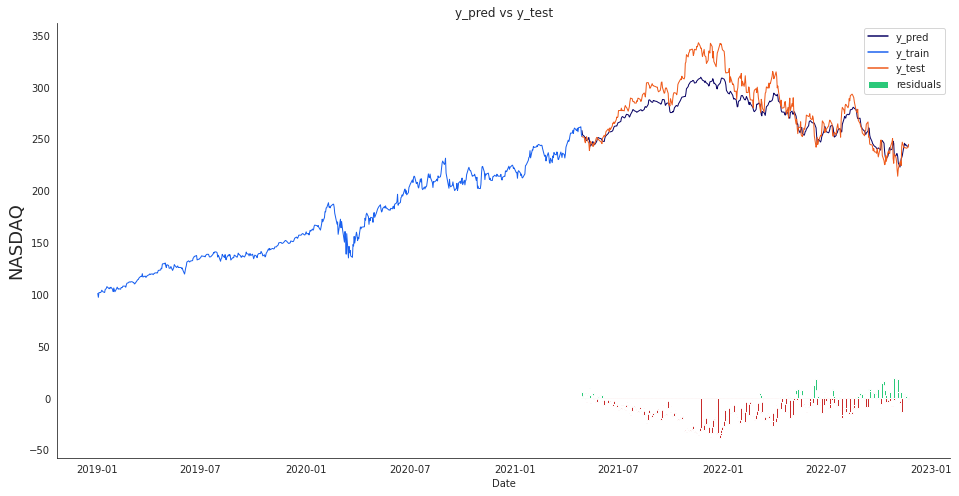

Date 2018-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
62/62 [==============================] - 4s 18ms/step - loss: 0.0796 - val_loss: 0.0327
Epoch 2/20
62/62 [==============================] - 0s 7ms/step - loss: 0.0123 - val_loss: 0.0010
Epoch 3/20
62/62 [==============================] - 0s 7ms/step - loss: 5.8203e-04 - val_loss: 0.0019
Epoch 4/20
62/62 [==============================] - 0s 7ms/step - loss: 4.2274e-04 - val_loss: 0.0012
Epoch 5/20
62/62 [==============================] - 0s 7ms/step - loss: 3.5305e-04 - val_loss: 0.0010
Epoch 6/20
62/62 [==============================] - 0s 7ms/step - loss: 3.0946e-04 - val_loss: 0.0012
Epoch 7/20
62/62 [==============================] - 0s 6ms/step - loss: 2.8543e-04 - val_loss: 0.0012
Epoch 8/20
62/62 [==============================] - 0s 7ms/step - loss: 2.7679e-04 - val_loss: 0.0012
Epoch 9/20
62/62 [==============================] - 0s 7ms/step - loss: 2.7706e-04 - val_loss: 0.0012
Epoc

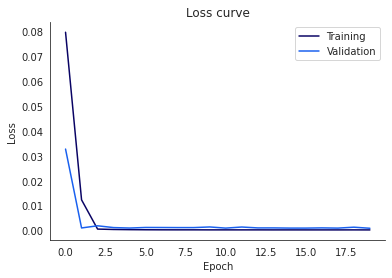

1/1 [==============================] - 0s 15ms/step


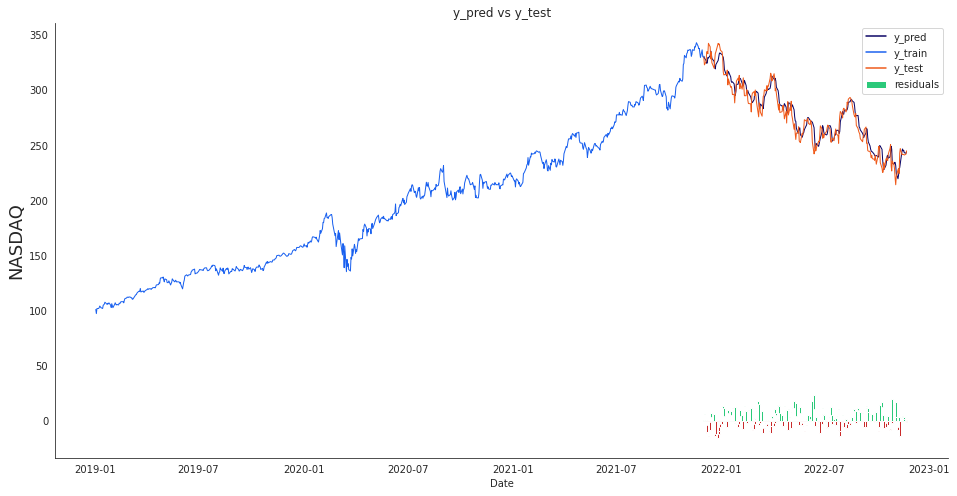

Date 2018-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
62/62 [==============================] - 5s 24ms/step - loss: 0.1008 - val_loss: 0.0619
Epoch 2/20
62/62 [==============================] - 1s 9ms/step - loss: 0.0193 - val_loss: 0.0010
Epoch 3/20
62/62 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 4/20
62/62 [==============================] - 1s 8ms/step - loss: 7.3312e-04 - val_loss: 0.0012
Epoch 5/20
62/62 [==============================] - 1s 8ms/step - loss: 6.0178e-04 - val_loss: 0.0012
Epoch 6/20
62/62 [==============================] - 1s 8ms/step - loss: 5.5140e-04 - val_loss: 0.0012
Epoch 7/20
62/62 [==============================] - 0s 8ms/step - loss: 5.2438e-04 - val_loss: 0.0015
Epoch 8/20
62/62 [==============================] - 1s 8ms/step - loss: 5.0830e-04 - val_loss: 0.0017
Epoch 9/20
62/62 [==============================] - 1s 8ms/step - loss: 5.0848e-04 - val_loss: 0.0016
Epoch 10

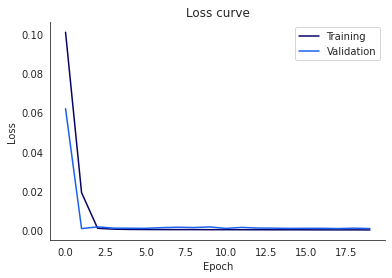

1/1 [==============================] - 0s 18ms/step


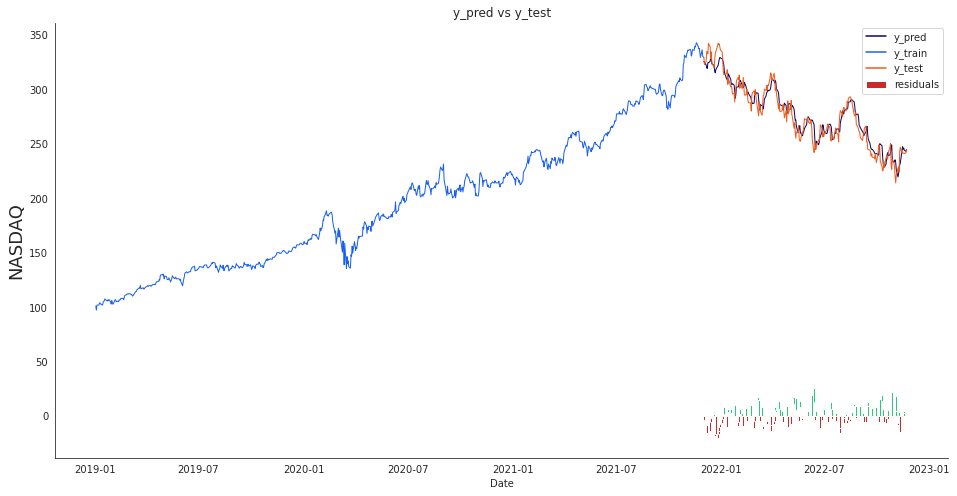

Date 2018-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
62/62 [==============================] - 8s 37ms/step - loss: 0.0962 - val_loss: 0.1275
Epoch 2/20
62/62 [==============================] - 1s 13ms/step - loss: 0.0343 - val_loss: 0.0016
Epoch 3/20
62/62 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 4/20
62/62 [==============================] - 1s 10ms/step - loss: 6.6307e-04 - val_loss: 0.0012
Epoch 5/20
62/62 [==============================] - 1s 10ms/step - loss: 5.7935e-04 - val_loss: 0.0013
Epoch 6/20
62/62 [==============================] - 1s 10ms/step - loss: 5.4649e-04 - val_loss: 0.0012
Epoch 7/20
62/62 [==============================] - 1s 9ms/step - loss: 5.1395e-04 - val_loss: 0.0015
Epoch 8/20
62/62 [==============================] - 1s 10ms/step - loss: 4.9076e-04 - val_loss: 0.0017
Epoch 9/20
62/62 [==============================] - 1s 10ms/step - loss: 4.6926e-04 - val_loss: 0.0013
E

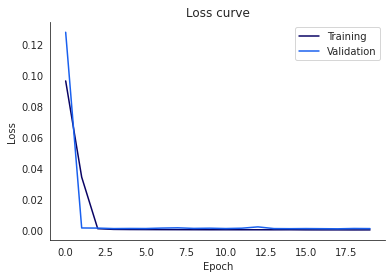

1/1 [==============================] - 0s 19ms/step


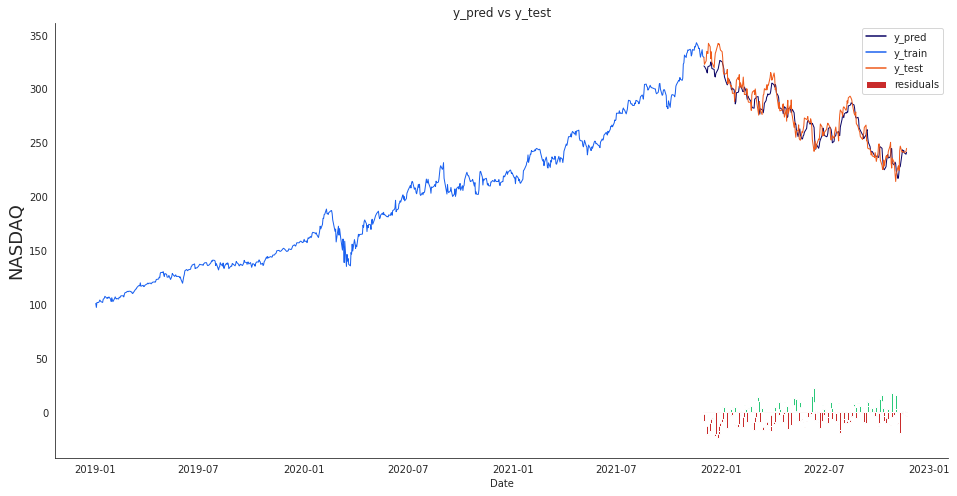

Date 2018-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
62/62 [==============================] - 2s 13ms/step - loss: 0.2092 - val_loss: 0.0089
Epoch 2/20
62/62 [==============================] - 1s 9ms/step - loss: 0.0065 - val_loss: 0.0042
Epoch 3/20
62/62 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 4/20
62/62 [==============================] - 1s 10ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 5/20
62/62 [==============================] - 1s 9ms/step - loss: 7.8970e-04 - val_loss: 0.0015
Epoch 6/20
62/62 [==============================] - 1s 9ms/step - loss: 5.2757e-04 - val_loss: 0.0012
Epoch 7/20
62/62 [==============================] - 1s 10ms/step - loss: 4.2200e-04 - val_loss: 0.0011
Epoch 8/20
62/62 [==============================] - 1s 10ms/step - loss: 3.6870e-04 - val_loss: 9.3974e-04
Epoch 9/20
62/62 [==============================] - 1s 9ms/step - loss: 3.4534e-04 - val_loss: 9.5621e-04
E

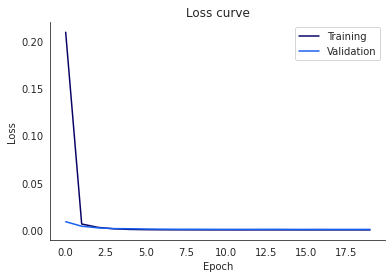

1/1 [==============================] - 0s 15ms/step


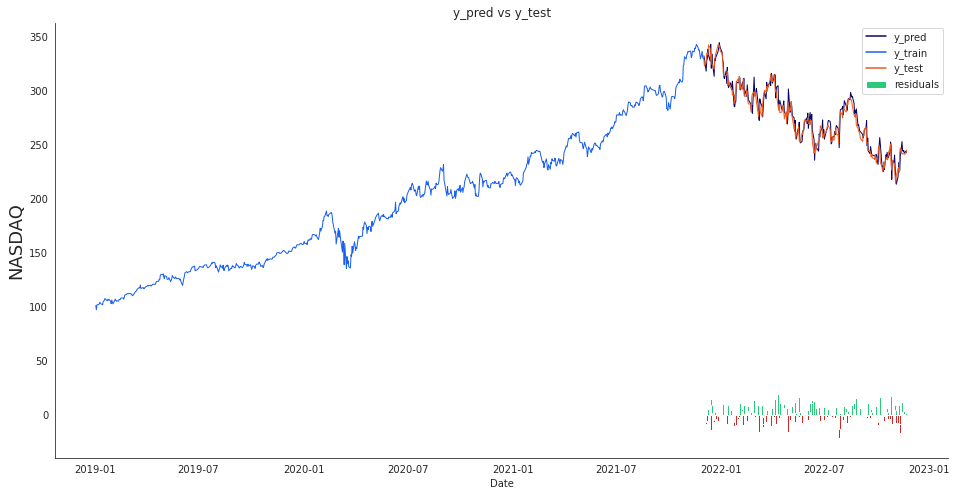

Date 2018-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
62/62 [==============================] - 3s 18ms/step - loss: 0.0091 - val_loss: 0.0026
Epoch 2/20
62/62 [==============================] - 1s 13ms/step - loss: 8.0778e-04 - val_loss: 0.0016
Epoch 3/20
62/62 [==============================] - 1s 13ms/step - loss: 6.1964e-04 - val_loss: 0.0017
Epoch 4/20
62/62 [==============================] - 1s 13ms/step - loss: 5.3544e-04 - val_loss: 0.0020
Epoch 5/20
62/62 [==============================] - 1s 13ms/step - loss: 4.7732e-04 - val_loss: 0.0019
Epoch 6/20
62/62 [==============================] - 1s 12ms/step - loss: 5.3637e-04 - val_loss: 0.0014
Epoch 7/20
62/62 [==============================] - 1s 12ms/step - loss: 4.4872e-04 - val_loss: 0.0013
Epoch 8/20
62/62 [==============================] - 1s 12ms/step - loss: 4.2725e-04 - val_loss: 0.0012
Epoch 9/20
62/62 [==============================] - 1s 12ms/step - loss: 3.7014e-04 - val_loss:

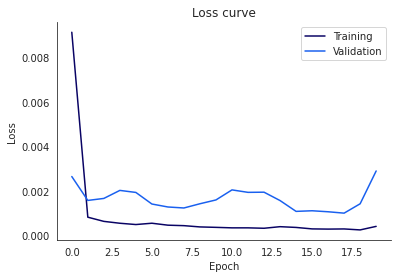

1/1 [==============================] - 0s 15ms/step


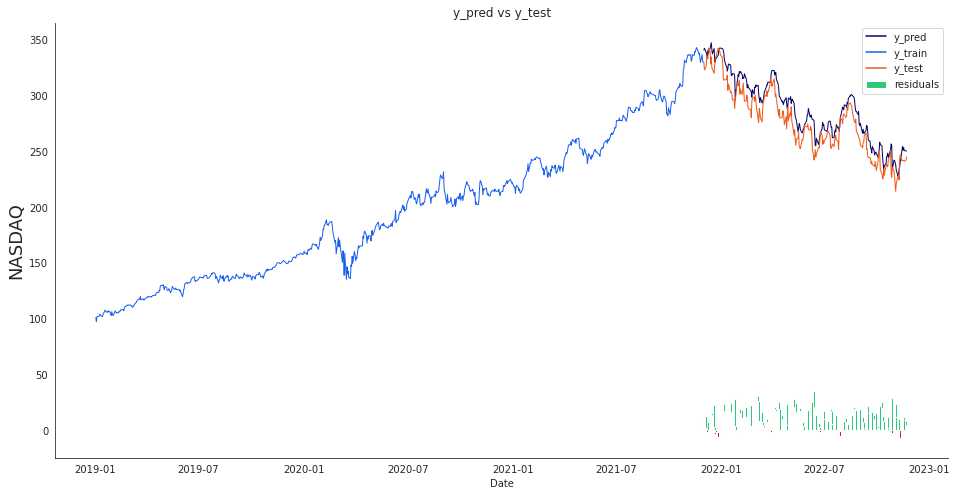

Date 2018-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
62/62 [==============================] - 4s 21ms/step - loss: 0.0085 - val_loss: 0.0080
Epoch 2/20
62/62 [==============================] - 1s 15ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 3/20
62/62 [==============================] - 1s 16ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 4/20
62/62 [==============================] - 1s 15ms/step - loss: 7.7635e-04 - val_loss: 0.0029
Epoch 5/20
62/62 [==============================] - 1s 16ms/step - loss: 5.7372e-04 - val_loss: 0.0027
Epoch 6/20
62/62 [==============================] - 1s 15ms/step - loss: 4.6469e-04 - val_loss: 0.0020
Epoch 7/20
62/62 [==============================] - 1s 15ms/step - loss: 4.3847e-04 - val_loss: 0.0017
Epoch 8/20
62/62 [==============================] - 1s 15ms/step - loss: 3.9602e-04 - val_loss: 0.0017
Epoch 9/20
62/62 [==============================] - 1s 15ms/step - loss: 3.5370e-04 - val_loss: 0.0017


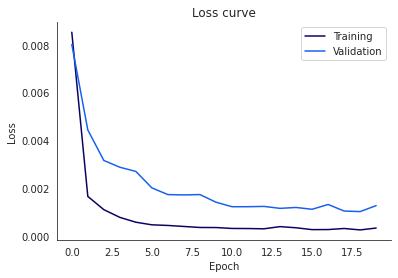

1/1 [==============================] - 0s 15ms/step


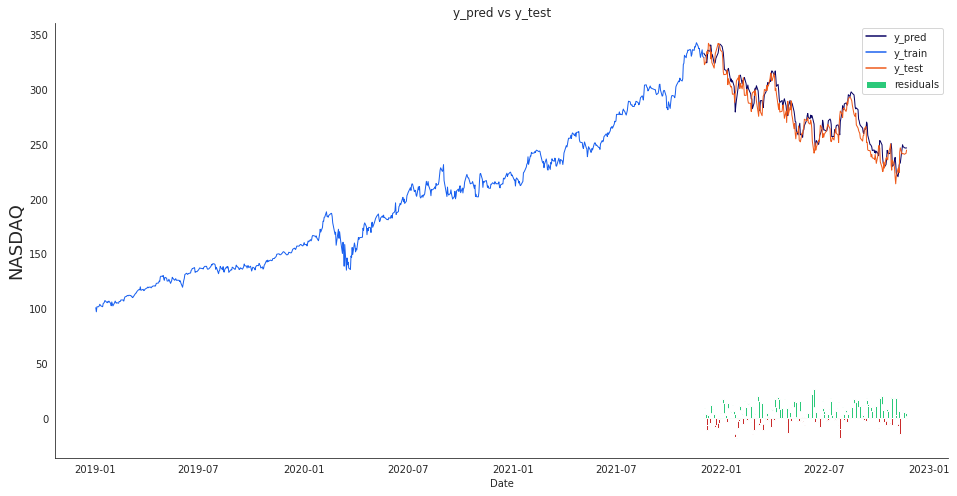

Date 2018-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
62/62 [==============================] - 4s 16ms/step - loss: 0.0731 - val_loss: 0.0445
Epoch 2/20
62/62 [==============================] - 0s 6ms/step - loss: 0.0120 - val_loss: 0.0029
Epoch 3/20
62/62 [==============================] - 0s 6ms/step - loss: 5.8763e-04 - val_loss: 0.0011
Epoch 4/20
62/62 [==============================] - 0s 7ms/step - loss: 3.2371e-04 - val_loss: 0.0011
Epoch 5/20
62/62 [==============================] - 0s 6ms/step - loss: 2.9420e-04 - val_loss: 0.0011
Epoch 6/20
62/62 [==============================] - 0s 6ms/step - loss: 2.7751e-04 - val_loss: 0.0010
Epoch 7/20
62/62 [==============================] - 0s 6ms/step - loss: 2.6211e-04 - val_loss: 9.7872e-04
Epoch 8/20
62/62 [==============================] - 0s 6ms/step - loss: 2.5273e-04 - val_loss: 9.5968e-04
Epoch 9/20
62/62 [==============================] - 0s 6ms/step - loss: 2.5371e-04 - val_loss: 9.3

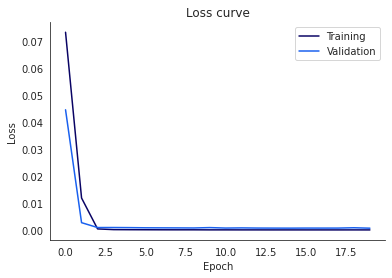

1/1 [==============================] - 0s 16ms/step


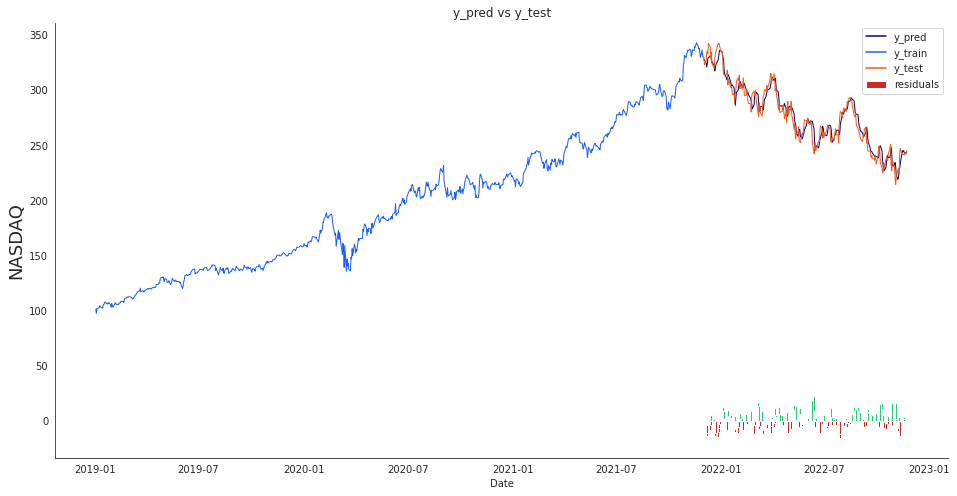

Date 2018-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
62/62 [==============================] - 5s 26ms/step - loss: 0.0413 - val_loss: 0.0046
Epoch 2/20
62/62 [==============================] - 0s 7ms/step - loss: 9.7970e-04 - val_loss: 0.0014
Epoch 3/20
62/62 [==============================] - 0s 8ms/step - loss: 5.1021e-04 - val_loss: 0.0013
Epoch 4/20
62/62 [==============================] - 0s 8ms/step - loss: 3.9103e-04 - val_loss: 0.0012
Epoch 5/20
62/62 [==============================] - 0s 8ms/step - loss: 3.1035e-04 - val_loss: 0.0011
Epoch 6/20
62/62 [==============================] - 0s 8ms/step - loss: 2.7190e-04 - val_loss: 9.8527e-04
Epoch 7/20
62/62 [==============================] - 0s 8ms/step - loss: 2.5058e-04 - val_loss: 9.5544e-04
Epoch 8/20
62/62 [==============================] - 0s 7ms/step - loss: 2.4242e-04 - val_loss: 0.0011
Epoch 9/20
62/62 [==============================] - 0s 8ms/step - loss: 2.3919e-04 - val_loss:

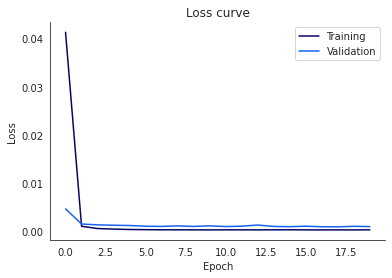

1/1 [==============================] - 0s 17ms/step


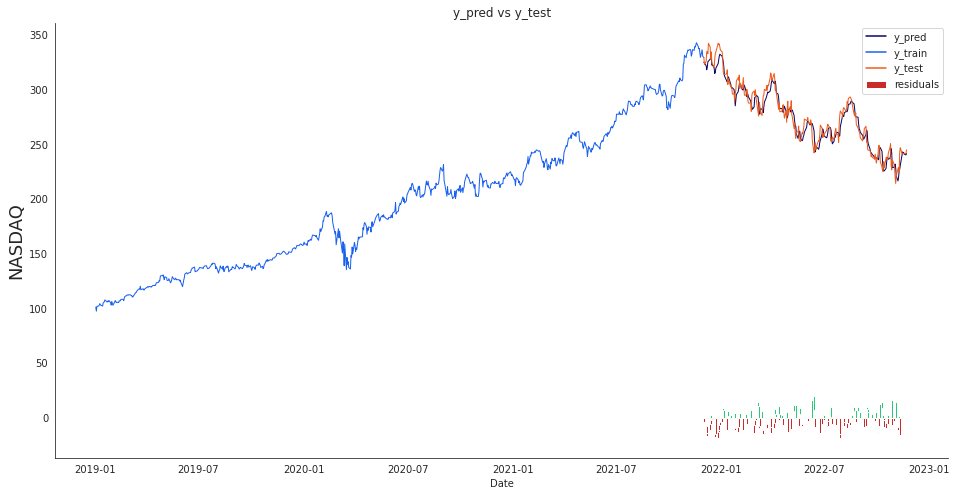

Date 2018-01-01
[*********************100%***********************]  1 of 1 completed
Epoch 1/20
62/62 [==============================] - 7s 27ms/step - loss: 0.0544 - val_loss: 0.0082
Epoch 2/20
62/62 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 3/20
62/62 [==============================] - 1s 9ms/step - loss: 3.8985e-04 - val_loss: 0.0012
Epoch 4/20
62/62 [==============================] - 1s 9ms/step - loss: 3.1012e-04 - val_loss: 0.0012
Epoch 5/20
62/62 [==============================] - 1s 9ms/step - loss: 2.6980e-04 - val_loss: 0.0010
Epoch 6/20
62/62 [==============================] - 1s 9ms/step - loss: 2.4671e-04 - val_loss: 0.0010
Epoch 7/20
62/62 [==============================] - 1s 9ms/step - loss: 2.4401e-04 - val_loss: 0.0010
Epoch 8/20
62/62 [==============================] - 1s 9ms/step - loss: 2.4739e-04 - val_loss: 0.0011
Epoch 9/20
62/62 [==============================] - 1s 9ms/step - loss: 2.3665e-04 - val_loss: 0.0010
Epoc

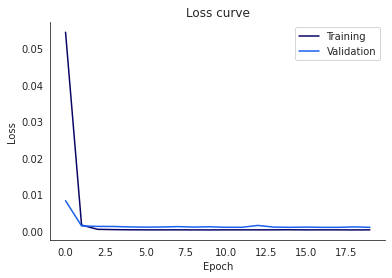

1/1 [==============================] - 0s 15ms/step


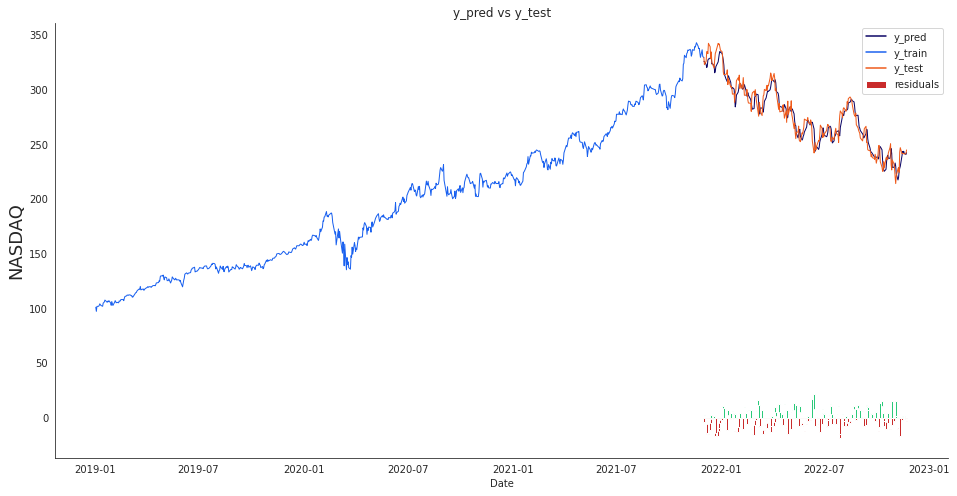

[{'epochs': 20, 'batch_size': 16, 'sequence_length': 2, 'mae': 16.233158293784292, 'mape': 5.7540463607916665, 'mdape': 5.125160716624896, 'mse': 434.6817353108192, 'test_prediction_difference': 11.669999389648439, 'training_time': 26.29886, 'number_of_layers': 0, 'model_names': 'LSTM', 'start_date': '2010-01-01'}, {'epochs': 20, 'batch_size': 16, 'sequence_length': 2, 'mae': 13.112905775637381, 'mape': 4.660977360487912, 'mdape': 4.064407070476147, 'mse': 290.24738135333996, 'test_prediction_difference': 9.130006103515626, 'training_time': 48.286776, 'number_of_layers': 1, 'model_names': 'LSTM', 'start_date': '2010-01-01'}, {'epochs': 20, 'batch_size': 16, 'sequence_length': 2, 'mae': 26.45773769196448, 'mape': 9.487513519630514, 'mdape': 9.244329060831575, 'mse': 1038.8979028499534, 'test_prediction_difference': 20.85000732421875, 'training_time': 37.914224, 'number_of_layers': 2, 'model_names': 'LSTM', 'start_date': '2010-01-01'}, {'epochs': 20, 'batch_size': 16, 'sequence_length': 

In [ ]:
#Experiment for Date Changing
random_seed()
end_date =  date.today().strftime("%Y-%m-%d")
start_dates = ['2010-01-01','2015-01-01','2018-01-01']
stockname = 'NASDAQ'
symbol = 'MSFT'
model_names = ['LSTM', 'SimpleRNN', 'GRU']
epochs = 20
batch_size = 16
learning_rate = 0.001
number_of_layers = [0,1,2]

loss_func = tf.keras.losses.MeanSquaredError()
sequence_length = 2
features = ['High', 'Low', 'Open', 'Close', 'Volume']
# features = ['High', 'Low', 'Open', 'Close']

# Train LSTM model

results_model_dates = []
for start_date in start_dates:
  for model in model_names:
    for layer in number_of_layers:
        print('Date', start_date)
        input_data_df = get_data(symbol, start_date, end_date)
        optimizer = tf.keras.optimizers.Adam(learning_rate)
        
        result = train_networks(input_data_df, features, model, epochs, batch_size, optimizer,loss_func, sequence_length, layer)

        result['model_names'] = model
        result['start_date'] = start_date

        results_model_dates.append(result)
print(results_model_dates)



## Result

In [ ]:
results_model_dates
result_df_model_date = pd.DataFrame(results_model_dates)
result_df_model_date.sort_values(by=["model_names","mse", "start_date"])

epochs  batch_size  sequence_length        mae       mape      mdape  \
24      20          16                2   6.104268   2.242141   1.831023   
25      20          16                2   6.313961   2.289112   2.070812   
26      20          16                2   6.417870   2.342490   1.953738   
15      20          16                2   6.582679   2.296952   1.995144   
6       20          16                2   6.506728   2.394129   2.048440   
16      20          16                2   6.902011   2.404806   2.003389   
17      20          16                2  11.404989   3.847002   3.342294   
7       20          16                2  12.088255   4.287186   3.767224   
8       20          16                2  21.402995   7.598663   7.014974   
18      20          16                2   6.301262   2.321617   1.899245   
19      20          16                2   6.724407   2.465561   2.084924   
20      20          16                2   7.200151   2.582953   2.247853   
9       20          16                2   8.806842   3.009641   2.737067   
10      20          16                2  11.037157   3.734781   3.231198   
11      20          16                2  13.164761   4.437642   4.154023   
1       20          16                2  13.112906   4.660977   4.064407   
0       20          16                2  16.233158   5.754046   5.125161   
2       20          16                2  26.457738   9.487514   9.244329   
21      20          16                2   5.671329   2.073122   1.577920   
23      20          16                2   7.420464   2.747207   2.343992   
13      20          16                2   9.723423   3.345111   2.944830   
22      20          16                2  11.704878   4.316053   3.963843   
12      20          16                2  14.380306   4.877132   4.742754   
3       20          16                2  14.253459   5.004897   4.014876   
14      20          16                2  16.519028   5.545191   5.260404   
5       20          16                2  18.947748   6.657345   5.760647   
4       20          16                2  38.185441  13.689283  13.008916   

            mse  test_prediction_difference  training_time  number_of_layers  \
24    56.790780                    0.110002      15.126567                 0   
25    60.861573                    2.679994      26.643082                 1   
26    62.485826                    1.880006      28.709686                 2   
15    66.446318                    0.860002      18.125680                 0   
6     73.823355                    2.669999      26.196689                 0   
16    74.811671                    0.529998      22.771769                 1   
17   208.951501                    0.500001      26.945589                 2   
7    254.301768                    7.839998      30.014154                 1   
8    731.154134                   15.800004      36.379265                 2   
18    60.485876                    0.410005      14.574626                 0   
19    69.079242                    0.309996      27.269282                 1   
20    78.811477                    3.250001      22.779397                 2   
9    119.287361                    2.199998      18.703851                 0   
10   190.048897                    1.929994      27.498984                 1   
11   266.808509                    2.720002      28.344692                 2   
1    290.247381                    9.130006      48.286776                 1   
0    434.681735                   11.669999      26.298860                 0   
2   1038.897903                   20.850007      37.914224                 2   
21    54.379792                    5.350005      15.164921                 0   
23    84.434396                    4.639998      24.719941                 2   
13   147.144235                    2.259996      25.336823                 1   
22   192.227513                    8.169997      23.732978                 1   
12   288.956938                    